In [1]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
mpl.rcParams['figure.dpi'] = 100
import pickle

In [2]:
conn = sqlite3.connect('dataset/rerun-with-captures-useast-web-performance-youtube.db')

#### remove measurements where googlevideo subdomain changed

In [3]:
#googlevideo_subdomains = pd.read_sql_query("SELECT msm_id, name FROM page_resources", conn)
#googlevideo_subdomains['googlevideo'] = googlevideo_subdomains.name.str.split('/').str[2]
#googlevideo_subdomains
all_subdomains = pd.read_sql_query("SELECT * FROM page_resources", conn)
googlevideo_subdomains = all_subdomains[all_subdomains.name.str.contains(".googlevideo.com/videoplayback")].copy()
googlevideo_subdomains.reset_index(drop=True, inplace=True)
googlevideo_subdomains['googlevideo'] = googlevideo_subdomains.name.str.split('/').str[2]
googlevideo_subdomains

connectEnd  connectStart  decodedBodySize  domainLookupEnd  \
0      5233.000000   5233.000000             2532      5233.000000   
1      5283.200000   5283.200000           123684      5283.200000   
2      8716.400000   8716.400000           212153      8716.400000   
3      4547.200000   4547.200000            66880      4547.200000   
4      7593.300000   7593.300000          1632683      7593.300000   
...            ...           ...              ...              ...   
10660  4539.400001   4539.400001           155796      4539.400001   
10661  4163.100000   4163.100000            66139      4163.100000   
10662  4333.600000   4326.500000           191876      4326.500000   
10663  4369.900001   4369.900001              847      4369.900001   
10664  4414.000000   4414.000000          1851196      4414.000000   

       domainLookupStart    duration  encodedBodySize entryType   fetchStart  \
0            5233.000000   35.000000             2532  resource  5233.000000   
1            5283.200000    6.800000           123684  resource  5283.200000   
2            8716.400000    9.200000           212153  resource  8716.400000   
3            4547.200000  671.600000            66880  resource  4547.200000   
4            7593.300000   79.200000          1632683  resource  7593.300000   
...                  ...         ...              ...       ...          ...   
10660        4539.400001   16.000000           155796  resource  4539.400001   
10661        4163.100000  185.500000            66139  resource  4163.100000   
10662        4163.000000  187.300000           191876  resource  4161.000000   
10663        4369.900001    5.000000              847  resource  4369.900001   
10664        4414.000000   90.400001          1851196  resource  4414.000000   

        initiatorType                                               name  \
0      xmlhttprequest  https://rr2---sn-p5qs7nel.googlevideo.com/vide...   
1      xmlhttprequest  https://rr2---sn-p5qs7nel.googlevideo.com/vide...   
2      xmlhttprequest  https://rr2---sn-p5qs7nel.googlevideo.com/vide...   
3      xmlhttprequest  https://rr2---sn-p5qs7nel.googlevideo.com/vide...   
4      xmlhttprequest  https://rr2---sn-p5qs7nel.googlevideo.com/vide...   
...               ...                                                ...   
10660  xmlhttprequest  https://rr4---sn-p5qlsn76.googlevideo.com/vide...   
10661  xmlhttprequest  https://rr4---sn-p5qlsn76.googlevideo.com/vide...   
10662  xmlhttprequest  https://rr4---sn-p5qlsn76.googlevideo.com/vide...   
10663  xmlhttprequest  https://rr4---sn-p5qlsn76.googlevideo.com/vide...   
10664  xmlhttprequest  https://rr4---sn-p5qlsn76.googlevideo.com/vide...   

      nextHopProtocol  requestStart  responseEnd  responseStart  \
0                  h3   5234.300000  5268.000000    5266.700000   
1                  h3   5284.300000  5290.000000    5286.900000   
2                  h3   8717.300000  8725.599999    8719.599999   
3                  h3   5171.599999  5218.800000    5217.200000   
4                  h3   7594.000000  7672.500000    7596.500000   
...               ...           ...          ...            ...   
10660              h3   4542.400001  4555.400001    4545.900001   
10661              h3   4334.500000  4348.600000    4341.600000   
10662              h3   4334.300000  4348.300000    4337.300000   
10663              h3   4371.000000  4374.900001    4374.000000   
10664              h3   4414.700000  4504.400001    4417.300000   

       secureConnectionStart    startTime  transferSize  \
0                5233.000000  5233.000000          2832   
1                5283.200000  5283.200000        123984   
2                8716.400000  8716.400000        212453   
3                4547.200000  4547.200000         67180   
4                7593.300000  7593.300000       1632983   
...                      ...          ...           ...   
10660            4539.400001  4539.400001        156096   
10661           

In [4]:
googlevideo_subdomains.groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo').googlevideo.value_counts()

1    2262
2      15
3       4
Name: googlevideo, dtype: int64

In [897]:
#pickle.dump(googlevideo_subdomains.groupby('msm_id', as_index=False).filter(lambda x: pd.Series.nunique(x['googlevideo']) > 1).msm_id.unique().tolist() , 
            open( "googlevideo_changed_during_msm.pickle", "wb" ) )

In [5]:
msm_ids_to_remove = googlevideo_subdomains.groupby('msm_id', as_index=False).filter(lambda x: pd.Series.nunique(x['googlevideo']) > 1).msm_id.unique().tolist()

#### remove measurement runs where resolution failed in the lookups table -- sadly the timestamps of dnsproxy are not reliable, so we cannot know from just looking at the lookups at which point of playback it failed -- in this run no googlevideo.com resolution failed, however removing them anyway in case it skews results -- also all errors happened over DoUDP

In [6]:
failed_lookups = pd.read_sql_query('SELECT measurement_id as msm_id FROM lookups WHERE status <> "NOERROR"', conn).msm_id.tolist()

In [7]:
len(failed_lookups)

396

In [898]:
#pickle.dump(failed_lookups, open( "servfail_during_msm.pickle", "wb" ) )

In [8]:
msm_ids_to_remove.extend(failed_lookups)

In [9]:
#conn = sqlite3.connect('web-performance-youtube-two-videos.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

msm_id              py_time       js_time  \
0     54e4f0a0-ed59-b179-21c2-8794968a4c1f                   -1 -1.000000e+00   
1     175c1fe0-56d9-1932-394b-669e321ff5a2  1651507009632915762  1.651507e+12   
2     7d8ead9c-b743-0ad8-05fe-ac0fccb94c80                   -1 -1.000000e+00   
3     35e33170-6e07-35d3-3d0f-a639b31b7219  1651507043321472000  1.651507e+12   
4     30bdd1c3-c2c6-de7f-e728-469ab7728144                   -1 -1.000000e+00   
...                                    ...                  ...           ...   
4969  22fa487e-bfd7-6f46-083a-9d3a2298232e  1651586557101439080  1.651587e+12   
4970  47264aaf-2577-e2b8-54b4-2feb2c26307d                   -1 -1.000000e+00   
4971  8776d083-2cac-7500-8890-a1bc75d63d68  1651586589192727116  1.651587e+12   
4972  d3d0e733-213d-d7c1-1845-7c260544587b                   -1 -1.000000e+00   
4973  50f21835-da05-8d4b-59b4-154322f21189  1651586620317598921  1.651587e+12   

      resource_time_origin protocol          server       domain vantagePoint  \
0            -1.000000e+00      tls  34.101.136.158  aqz-KE-bpKQ      US East   
1             1.651507e+12      tls  34.101.136.158  aqz-KE-bpKQ      US East   
2            -1.000000e+00    https  34.101.136.158  aqz-KE-bpKQ      US East   
3             1.651507e+12    https  34.101.136.158  aqz-KE-bpKQ      US East   
4            -1.000000e+00     quic  34.101.136.158  aqz-KE-bpKQ      US East   
...                    ...      ...             ...          ...          ...   
4969          1.651587e+12     quic    168.138.50.5  lqiN98z6Dak      US East   
4970         -1.000000e+00      tcp    168.138.50.5  lqiN98z6Dak      US East   
4971          1.651587e+12      tcp    168.138.50.5  lqiN98z6Dak      US East   
4972         -1.000000e+00      udp    168.138.50.5  lqiN98z6Dak      US East   
4973          1.651587e+12      udp    168.138.50.5  lqiN98z6Dak      US East   

                       timestamp suggested_quality  player_width  \
0     2022-05-02 15:56:29.973683              auto          1280   
1     2022-05-02 15:56:37.107909              auto          1280   
2     2022-05-02 15:57:03.608937              auto          1280   
3     2022-05-02 15:57:10.610558              auto          1280   
4     2022-05-02 15:57:37.370906              auto          1280   
...                          ...               ...           ...   
4969  2022-05-03 14:02:25.299352              auto          1280   
4970  2022-05-03 14:02:51.013641              auto          1280   
4971  2022-05-03 14:02:57.236170              auto          1280   
4972  2022-05-03 14:03:23.002842              auto          1280   
4973  2022-05-03 14:03:28.962782              auto          1280   

      player_height  start_time  play_time    video_ids  cacheWarming error  
0               720           0          5  aqz-KE-bpKQ             1        
1               720           0          5  aqz-KE-bpKQ             0        
2               720           0          5  aqz-KE-bpKQ             1        
3               720           0          5  aqz-KE-bpKQ             0        
4               720           0          5  aqz-KE-bpKQ             1        
...             ...         ...        ...          ...           ...   ...  
4969            720           0          5  lqiN98z6Dak             0        
4970            720           0          5  lqiN98z6Dak             1        
4971            720           0          5  lqiN98z6Dak             0        
4972            720           0          5  lqiN98z6Dak             1        
4973            720           0          5  lqiN98z6Dak             0        

[4974 rows x 17 columns]

# data pre-processing

In [10]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [11]:
measurements = measurements[measurements.cacheWarming == 0]

In [12]:
measurements.groupby('vantagePoint', as_index=False).agg({'msm_id':pd.Series.nunique})

vantagePoint  msm_id
0      US East    2304

In [13]:
measurements = measurements[~measurements.msm_id.isin(msm_ids_to_remove)]

In [14]:
measurements['timestamp'] = pd.to_datetime(measurements['timestamp'])

In [15]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [16]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [17]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [18]:
cache_warming_failed = pd.read_sql_query("SELECT msm_id as cw_msm_id, protocol, server, domain, vantagePoint, suggested_quality, (player_width || 'x' || player_height) as player_dimensions, timestamp, start_time, play_time, video_ids FROM measurements WHERE error <> '' AND cacheWarming = 1", conn)
cache_warming_failed['timestamp'] = pd.to_datetime(cache_warming_failed['timestamp'])
cache_warming_failed

cw_msm_id protocol          server  \
0    805142f5-e35e-b345-92ff-80634272b8c7      tls  194.177.23.120   
1    4d35a549-cde5-390d-83d9-6bb380a9f6c1    https  194.177.23.120   
2    1d7a7e38-d0ad-ff5a-db8a-facdd67e287e     quic  194.177.23.120   
3    8a34fa16-d60f-aecf-bdf2-b64e6d37a7ba      tcp  194.177.23.120   
4    600299e4-c2ff-3eca-2339-c5cf5a59ac93      udp  194.177.23.120   
..                                    ...      ...             ...   
361  ba0b6502-7368-2960-212e-5f2c843f1f02      udp   210.16.120.48   
362  a3ddc9e4-51f5-7aaa-f523-f3d9cf682a87      tcp  39.105.150.214   
363  4f526155-cca8-a393-cc37-9df1a5278032      udp  39.105.150.214   
364  5ba441e9-2f38-2562-f419-c443e580c5b2      tcp  39.105.150.214   
365  7e923c84-611b-5f7a-1329-402b58b86d05      udp  39.105.150.214   

          domain vantagePoint suggested_quality player_dimensions  \
0    aqz-KE-bpKQ      US East              auto          1280x720   
1    aqz-KE-bpKQ      US East              auto          1280x720   
2    aqz-KE-bpKQ      US East              auto          1280x720   
3    aqz-KE-bpKQ      US East              auto          1280x720   
4    aqz-KE-bpKQ      US East              auto          1280x720   
..           ...          ...               ...               ...   
361  lqiN98z6Dak      US East              auto          1280x720   
362  aqz-KE-bpKQ      US East              auto          1280x720   
363  aqz-KE-bpKQ      US East              auto          1280x720   
364  lqiN98z6Dak      US East              auto          1280x720   
365  lqiN98z6Dak      US East              auto          1280x720   

                     timestamp  start_time  play_time    video_ids  
0   2022-05-02 16:11:31.892789           0          5  aqz-KE-bpKQ  
1   2022-05-02 16:12:05.235339           0          5  aqz-KE-bpKQ  
2   2022-05-02 16:12:38.398647           0          5  aqz-KE-bpKQ  
3   2022-05-02 16:13:11.570131           0          5  aqz-KE-bpKQ  
4   2022-05-02 16:13:44.563134           0          5  aqz-KE-bpKQ  
..                         ...         ...        ...          ...  
361 2022-05-03 10:22:13.499364           0          5  lqiN98z6Dak  
362 2022-05-03 11:59:28.512996           0          5  aqz-KE-bpKQ  
363 2022-05-03 11:59:58.337087           0          5  aqz-KE-bpKQ  
364 2022-05-03 12:02:29.023558           0          5  lqiN98z6Dak  
365 2022-05-03 12:02:58.597529           0          5  lqiN98z6Dak  

[366 rows x 11 columns]

## find the optimal resolution as determined by the youtube player for each run

In [47]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [48]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [49]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [50]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [51]:
s_filter_msm[s_filter_msm > 1].index.tolist()

[]

In [52]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

Empty DataFrame
Columns: [time]
Index: []

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [53]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [54]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [55]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

Empty DataFrame
Columns: [msm_id, opt_res_num, opt_res_list]
Index: []

In [56]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [57]:
measurements_to_remove

[]

In [58]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

Series([], Name: player_dimensions, dtype: int64)

In [59]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

Series([], Name: protocol, dtype: int64)

In [60]:
#measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

In [61]:
measurements[measurements.player_dimensions == "1280x720"].protocol.value_counts()

DoQ      461
DoT      459
DoH      456
DoTCP    453
DoUDP    448
Name: protocol, dtype: int64

In [62]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [63]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [64]:
df_optimal_resolutions

msm_id optimal_res
0     175c1fe0-56d9-1932-394b-669e321ff5a2    1280x720
1     35e33170-6e07-35d3-3d0f-a639b31b7219    1280x720
2     7fbb3528-bde9-647e-d74e-af53a88a98e6    1280x720
3     23bc6b14-1cf8-cd7a-1d73-bd23483f6ffb    1280x720
4     b90cb4cb-e9b1-d4fa-3571-91623a81110f    1280x720
...                                    ...         ...
2299  1bcd77ad-3df2-3713-dcf9-88bc261a7dee    1280x720
2300  401dc640-c33b-7821-7be0-cd2d5f01402d    1280x720
2301  22fa487e-bfd7-6f46-083a-9d3a2298232e    1280x720
2302  8776d083-2cac-7500-8890-a1bc75d63d68    1280x720
2303  50f21835-da05-8d4b-59b4-154322f21189    1280x720

[2304 rows x 2 columns]

In [65]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     175c1fe0-56d9-1932-394b-669e321ff5a2    1280x720          1280x720
1     35e33170-6e07-35d3-3d0f-a639b31b7219    1280x720          1280x720
2     7fbb3528-bde9-647e-d74e-af53a88a98e6    1280x720          1280x720
3     23bc6b14-1cf8-cd7a-1d73-bd23483f6ffb    1280x720          1280x720
4     b90cb4cb-e9b1-d4fa-3571-91623a81110f    1280x720          1280x720
...                                    ...         ...               ...
2272  1bcd77ad-3df2-3713-dcf9-88bc261a7dee    1280x720          1280x720
2273  401dc640-c33b-7821-7be0-cd2d5f01402d    1280x720          1280x720
2274  22fa487e-bfd7-6f46-083a-9d3a2298232e    1280x720          1280x720
2275  8776d083-2cac-7500-8890-a1bc75d63d68    1280x720          1280x720
2276  50f21835-da05-8d4b-59b4-154322f21189    1280x720          1280x720

[2277 rows x 3 columns]

### make sure the optimal resolutions match what we set as the player size

In [66]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

Empty DataFrame
Columns: [msm_id, optimal_res, player_dimensions]
Index: []

### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [67]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [68]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: curr_play_time, dtype: float64

In [69]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    2298.000000
mean        0.024847
std         0.015616
min         0.002875
25%         0.018487
50%         0.022042
75%         0.026253
max         0.342487
Name: curr_play_time, dtype: float64

In [70]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [71]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

## apparently some measurements didnt start playing but also did not errror out...

In [43]:
df_player_state_intial_playback[~df_player_state_intial_playback.msm_id.isin(measurements.msm_id.unique())]

Empty DataFrame
Columns: [time, msm_id, curr_play_time]
Index: []

In [44]:
measurements[~measurements.msm_id.isin(df_player_state_intial_playback.msm_id.unique())]

msm_id              py_time       js_time  \
4469  86ae37e1-521e-62ad-0637-d8f1e948388d  1651579295968771739  1.651579e+12   
4471  b3ab5ca8-4c0b-a610-f842-3d911a95fe01  1651579335152500783  1.651579e+12   

      resource_time_origin protocol          server       domain vantagePoint  \
4469          1.651579e+12      DoH  39.105.150.214  lqiN98z6Dak      US East   
4471          1.651579e+12      DoQ  39.105.150.214  lqiN98z6Dak      US East   

                      timestamp suggested_quality player_width player_height  \
4469 2022-05-03 12:01:20.505310              auto         1280           720   
4471 2022-05-03 12:01:59.771728              auto         1280           720   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
4469           0          5  lqiN98z6Dak             0                1280x720  
4471           0          5  lqiN98z6Dak             0                1280x720

In [45]:
measurements = measurements[measurements.msm_id.isin(df_player_state_intial_playback.msm_id.unique())]
measurements.reset_index(drop=True, inplace=True)

## as below in the case that we do not have a quality change event, start again at finding optimal resolutions

In [46]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [72]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [73]:
df_start_time

start_time                     play_time  \
0    2022-05-02 15:56:43.144600064 2022-05-02 15:56:44.365499904   
1    2022-05-02 15:57:16.697600000 2022-05-02 15:57:17.565699840   
2    2022-05-02 15:57:50.322700032 2022-05-02 15:57:51.177900032   
3    2022-05-02 15:58:23.908700160 2022-05-02 15:58:24.990500096   
4    2022-05-02 15:58:56.331300096 2022-05-02 15:58:57.171699968   
...                            ...                           ...   
2293 2022-05-03 14:01:26.495600128 2022-05-03 14:01:27.354900224   
2294 2022-05-03 14:01:58.552800000 2022-05-03 14:01:59.316199936   
2295 2022-05-03 14:02:30.629099776 2022-05-03 14:02:31.311500032   
2296 2022-05-03 14:03:02.594200320 2022-05-03 14:03:03.452900096   
2297 2022-05-03 14:03:33.892400128 2022-05-03 14:03:34.585299968   

                                    msm_id initial_quality  startup_delay  
0     175c1fe0-56d9-1932-394b-669e321ff5a2           hd720         1.2209  
1     35e33170-6e07-35d3-3d0f-a639b31b7219           hd720         0.8681  
2     7fbb3528-bde9-647e-d74e-af53a88a98e6           hd720         0.8552  
3     23bc6b14-1cf8-cd7a-1d73-bd23483f6ffb           hd720         1.0818  
4     b90cb4cb-e9b1-d4fa-3571-91623a81110f           hd720         0.8404  
...                                    ...             ...            ...  
2293  1bcd77ad-3df2-3713-dcf9-88bc261a7dee           hd720         0.8593  
2294  401dc640-c33b-7821-7be0-cd2d5f01402d           hd720         0.7634  
2295  22fa487e-bfd7-6f46-083a-9d3a2298232e           hd720         0.6824  
2296  8776d083-2cac-7500-8890-a1bc75d63d68           hd720         0.8587  
2297  50f21835-da05-8d4b-59b4-154322f21189           hd720         0.6929  

[2277 rows x 5 columns]

### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [74]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [75]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [76]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000    4435
0.017900       1
0.020261       1
0.020296       1
0.021154       1
0.022188       1
0.022220       1
0.023992       1
0.023997       1
0.024003       1
0.024138       1
0.024212       1
0.026369       1
0.026551       1
0.027480       1
0.028349       1
0.029516       1
0.030186       1
0.030330       1
0.030620       1
0.030622       1
0.031998       1
0.032460       1
0.032543       1
0.033405       1
0.034286       1
0.036421       1
0.039693       1
0.043536       1
0.044039       1
0.044167       1
0.050873       1
0.056004       1
0.056027       1
0.056515       1
0.069696       1
0.073031       1
0.076656       1
0.086040       1
0.091770       1
0.092157       1
0.103988       1
0.108172       1
0.123899       1
0.135664       1
0.160798       1
1.037629       1
Name: curr_play_time, dtype: int64

In [77]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

175c1fe0-56d9-1932-394b-669e321ff5a2    2
bfaa54aa-eab7-9bcd-6f21-ee691c22541a    2
f2684ec9-9682-d375-b7e0-20a13f4f7bce    2
411dda9d-1790-c8a9-fc8b-92b6b2b6bcc7    2
8660b9f7-a096-24dc-1f04-794115945ba4    2
                                       ..
982f28c0-b281-ce15-58fe-23c45309a268    1
04b040dc-df0d-c6cb-5adc-a0df97101f59    1
347d1757-2fcc-2bff-c89d-33b510537c03    1
2c0f74a3-771a-8aae-0546-a0d885fa7cca    1
54a5aa9c-8d59-0524-46fe-f0d4c5db0f4d    1
Name: msm_id, Length: 2277, dtype: int64

In [78]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [79]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [80]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [81]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [82]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

msm_id                     play_time  \
54    05238ee3-0d73-2d75-c5a5-031bcdde96ae 2022-05-02 17:12:20.999400192   
139   0fbd7d93-04b3-8f4c-2b70-454a487f5d3f 2022-05-03 01:36:27.467399936   
175   13cae0d0-0d07-961d-1cac-6fb4fb764dfc 2022-05-03 08:46:02.165299968   
218   186b3015-8fc3-72e8-b87b-7b835d1e20af 2022-05-02 22:02:39.037900032   
280   1f3ef5cd-17a2-3b55-824f-4bbaddddc291 2022-05-03 02:32:10.521199872   
361   27a72a65-a153-1cee-8aa8-a96648a5ab7b 2022-05-03 01:53:57.683100160   
373   28b8cf0d-3d18-e02c-6ce6-1e62061e52ae 2022-05-02 23:06:55.097100032   
384   29a6da65-678c-fbba-40fb-72d3178c7bb8 2022-05-02 19:42:00.896800000   
416   2de2f70a-5bc7-0749-0af4-f0c60f9f711c 2022-05-02 23:53:48.164900096   
473   32c53c82-4273-4596-7844-ff388aff0f46 2022-05-03 10:55:34.608599808   
603   404cfcac-9a4f-cb32-2791-efc8576abee8 2022-05-02 23:10:13.893400064   
629   427fd80a-59ce-4c03-10bd-c9b22016141d 2022-05-03 04:04:39.189799936   
661   470690cf-ce9a-d8f5-8e4e-afa2ffe9da9c 2022-05-03 00:13:40.990200064   
662   4721465b-8b52-8810-a3cb-668599ab9fa4 2022-05-02 23:45:36.084199936   
787   543470d7-0b4f-4e45-6303-02bddfbb725c 2022-05-02 16:38:00.235600128   
1034  71a7597b-e2ed-f457-b72a-48e5c7aa22cf 2022-05-02 18:46:01.462599936   
1187  85bef5cc-a894-59c9-bb60-4c0b2cfc6867 2022-05-02 20:55:13.992000000   
1300  91588038-bff6-e021-b7c0-fa672ca73375 2022-05-03 01:29:27.196699904   
1354  982f28c0-b281-ce15-58fe-23c45309a268 2022-05-03 04:28:39.009600000   
1371  9a314583-2715-b536-2cf8-977b37c3d89e 2022-05-03 00:31:01.965299712   
1590  b2148c5d-0490-d0c2-982e-0a04edd72e80 2022-05-02 23:35:34.857299968   
1659  bb41feae-f6d8-48be-c08a-e1882d1c89ac 2022-05-03 01:03:10.921299968   
1814  cca91cfa-e4aa-bdb8-8b0e-f96db8865538 2022-05-03 09:19:50.234700032   
2047  e5ec5c93-97d2-7e8c-ad07-866178df28b5 2022-05-02 20:52:39.368399872   
2061  e7bb3f0e-52f8-30ff-2c99-958c71f1b911 2022-05-03 04:03:20.886900224   
2093  eab2f784-7d75-abb0-a04b-0f4e48e2585b 2022-05-02 19:43:19.118500096   
2149  f279b162-cb9f-8889-5008-ae861514a687 2022-05-02 22:45:55.971900160   
2155  f3087e03-e1e8-182d-ecfd-89649631d242 2022-05-03 00:11:18.596899840   
2261  fde7de91-70ae-dfd7-70dc-f2c5efeff8ca 2022-05-03 10:17:15.277199872   

     initial_quality                          time current_quality  \
54             hd720 2022-05-02 17:12:20.822900224           large   
139            hd720 2022-05-03 01:36:26.936399872           large   
175            hd720 2022-05-03 08:46:02.021399808           large   
218            hd720 2022-05-02 22:02:38.793200128           large   
280            hd720 2022-05-03 02:32:10.266800128           large   
361            hd720 2022-05-03 01:53:57.465600000           large   
373            hd720 2022-05-02 23:06:54.545900032           large   
384            hd720 2022-05-02 19:42:00.641999872           large   
416            hd720 2022-05-02 23:53:47.732499968           large   
473            hd720 2022-05-03 10:55:33.929199872           large   
603            hd720 2022-05-02 23:10:13.633100032           large   
629            hd720 2022-05-03 04:04:39.085700096           large   
661            hd720 2022-05-03 00:13:40.620399872           large   
662            hd720 2022-05-02 23:45:35.802700032           large   
787            hd720 2022-05-02 16:37:59.704800000           large   
1034           hd720 2022-05-02 18:46:00.950099968           large   
1187           hd720 2022-05-02 20:55:13.590300160           large   
1300           hd720 2022-05-03 01:29:26.992999936           large   
1354           hd720 2022-05-03 04:28:38.691500032           large   
1371           hd720 2022-05-03 00:31:01.613799680           large   
1590           hd720 2022-05-02 23:35:34.588699904           large   
1659           hd720 2022-05-03 01:03:10.342800128           large   
1814           hd720 2022-05-03 09:19:49.868000000           large   
2047           hd720 2022-05-02 20:52:38.963099904           large   
2061 

In [83]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [84]:
df_true_initial_quality

msm_id                     play_time  \
0     002f9bec-f805-eccd-a7a0-8c93195f423b 2022-05-02 20:20:41.876000000   
1     0053b03d-948e-e777-9848-8f880b5596d2 2022-05-02 22:38:20.414099968   
2     005878b6-83e5-f985-cbd8-c8dce2ace8fa 2022-05-03 07:23:04.123699968   
3     005f1815-de05-6bd8-f95a-055e9172dff3 2022-05-03 06:32:15.593999872   
4     00647d1d-c136-9de4-60be-10aaba3dfb5a 2022-05-02 17:40:24.272099840   
...                                    ...                           ...   
2272  ff199197-3e7c-cbfd-d1f0-22cc4656bb11 2022-05-03 11:29:57.119399936   
2273  ff28b4a9-28bd-f8f2-6e09-9d8210882e85 2022-05-03 09:08:56.625299712   
2274  ffcd2c91-09cf-d38b-dd8a-7cdf9f9fdace 2022-05-02 19:26:41.039299840   
2275  ffe280d9-195b-7023-11f1-ecd7d893205c 2022-05-03 07:38:10.473299968   
2276  fffd2e79-af5f-2d06-3fd9-d59220105cb7 2022-05-03 10:04:37.802800128   

     initial_quality                          time true_initial_quality  \
0              hd720 2022-05-02 20:20:41.815300096                hd720   
1              hd720 2022-05-02 22:38:20.279799808                hd720   
2              hd720 2022-05-03 07:23:04.050799872                hd720   
3              hd720 2022-05-03 06:32:15.580999936                hd720   
4              hd720 2022-05-02 17:40:24.271599872                hd720   
...              ...                           ...                  ...   
2272           hd720 2022-05-03 11:29:56.922500096                hd720   
2273           hd720 2022-05-03 09:08:56.509099776                hd720   
2274           hd720 2022-05-02 19:26:40.893699840                hd720   
2275           hd720 2022-05-03 07:38:10.395300096                hd720   
2276           hd720 2022-05-03 10:04:37.667699968                hd720   

      delay_to_play_time  
0                 0.0607  
1                 0.1343  
2                 0.0729  
3                 0.0130  
4                 0.0005  
...                  ...  
2272              0.1969  
2273              0.1162  
2274              0.1456  
2275              0.0780  
2276              0.1351  

[2277 rows x 6 columns]

### helper functions

In [85]:
res_to_quality = {
    "unknown":"auto","256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [86]:
quality_to_res

{'auto': 'unknown',
 'tiny': '256x144',
 'small': '426x240',
 'medium': '640x360',
 'large': '854x480',
 'hd720': '1280x720',
 'hd1080': '1920x1080',
 'hd1440': '2560x1440',
 'hd2160': '3840x2160'}

In [87]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name, nextHopProtocol, domainLookupStart, domainLookupEnd FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [88]:
df_resource_timing = df_resource_timing[df_resource_timing.name.str.contains(".googlevideo.com/videoplayback")]
df_resource_timing.reset_index(drop=True, inplace=True)
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [89]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-p5qs7nel.googlevideo.com',
       'rr4---sn-p5qs7nsr.googlevideo.com',
       'rr4---sn-p5qlsn76.googlevideo.com',
       'rr2---sn-p5qlsndd.googlevideo.com',
       'rr6---sn-ab5l6n6s.googlevideo.com',
       'r2---sn-p5qs7nel.googlevideo.com', 'redirector.googlevideo.com',
       'r4---sn-p5qs7nsr.googlevideo.com',
       'rr4---sn-vgqsrnlz.googlevideo.com',
       'rr4---sn-vgqsknld.googlevideo.com',
       'rr4---sn-ab5l6nzr.googlevideo.com',
       'rr2---sn-vgqsknld.googlevideo.com'], dtype=object)

In [90]:
def find_initial_requests(url_):
    parse_res = urlparse(url_)
    opts = parse_qs(parse_res.query)
    if opts['range'][0][0] == '0':
        return True
    return False
df_resource_timing['first_request'] = df_resource_timing['name'].map(find_initial_requests)

In [91]:
df_resource_timing['h1_first_request'] = False
df_resource_timing['h1_first_request'] = np.where((df_resource_timing.nextHopProtocol == 'http/1.1') & (df_resource_timing.first_request == True), True, df_resource_timing['h1_first_request'])

In [92]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp, vantagePoint, protocol, server, domain FROM measurements", conn))

In [93]:
df_resource_timing[df_resource_timing.cacheWarming == 0].groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo')

msm_id  googlevideo
0     002f9bec-f805-eccd-a7a0-8c93195f423b            1
1525  a9d8dd4a-75e5-6f14-cde4-c5e4b43e9f42            1
1524  a9ce8d1b-3ff4-57c9-0a6a-3b4b3e4b9e61            1
1523  a9bb6ec4-fa69-0d48-f5e9-a4c0df17bac6            1
1522  a98ed2b4-b291-4e63-98d4-ca619b418d47            1
...                                    ...          ...
567   3b99b86e-1eaf-6621-f32d-c0b015f60d6d            2
1148  8000b479-3077-b47c-a868-19f832fecb12            3
1712  c02e6578-1b60-f8d9-c8f8-f49fb3f4c86f            3
1669  bc5e4e1f-fb62-222c-37b0-b6a0b305ba49            3
107   0bcfc06e-d5e5-d668-cabb-a0e854b055e8            3

[2281 rows x 2 columns]

In [94]:
df_caught_first_request = df_resource_timing.groupby('msm_id', as_index=False).agg({'first_request': lambda x: sum(x) > 0, 'h1_first_request': lambda x: sum(x) > 0})

In [95]:
print(df_caught_first_request[df_caught_first_request.first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())

777
1504
2281
0
2281
2281


In [96]:
df_caught_first_request = pd.merge(df_caught_first_request, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [97]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())

777
1504
2281
0
2281
2281


In [98]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())

0
0
0
0
0
0


In [99]:
df_resource_timing.msm_id.nunique()

2281

In [100]:
df_resource_timing.domainLookupStart.describe()

count    10665.000000
mean      5467.697196
std       2302.888092
min          0.000000
25%       3504.900000
50%       4723.700000
75%       7412.800000
max      14163.800000
Name: domainLookupStart, dtype: float64

In [101]:
df_resource_timing.domainLookupEnd.describe()

count    10665.000000
mean      5484.583685
std       2294.250787
min          0.000000
25%       3529.400001
50%       4802.500000
75%       7415.800000
max      14163.800000
Name: domainLookupEnd, dtype: float64

In [102]:
df_resource_timing[df_resource_timing.domainLookupStart == 0]

msm_id  \
2947  ca355993-db2b-6f3e-df89-5e3d7a69082a   
6835  bc5e4e1f-fb62-222c-37b0-b6a0b305ba49   
6839  bc5e4e1f-fb62-222c-37b0-b6a0b305ba49   
6880  0bcfc06e-d5e5-d668-cabb-a0e854b055e8   
6946  c02e6578-1b60-f8d9-c8f8-f49fb3f4c86f   
6949  c02e6578-1b60-f8d9-c8f8-f49fb3f4c86f   
9542  57c57afc-65e8-bdea-c25a-96473b874006   
9543  57c57afc-65e8-bdea-c25a-96473b874006   
9544  57c57afc-65e8-bdea-c25a-96473b874006   
9545  57c57afc-65e8-bdea-c25a-96473b874006   
9546  57c57afc-65e8-bdea-c25a-96473b874006   
9547  08cf7621-2add-1bc7-00af-310fd7dba1ea   
9548  08cf7621-2add-1bc7-00af-310fd7dba1ea   
9549  08cf7621-2add-1bc7-00af-310fd7dba1ea   
9550  08cf7621-2add-1bc7-00af-310fd7dba1ea   
9551  24c01608-848c-581a-55df-b714f3ca356c   
9552  24c01608-848c-581a-55df-b714f3ca356c   
9553  24c01608-848c-581a-55df-b714f3ca356c   
9554  24c01608-848c-581a-55df-b714f3ca356c   
9555  24c01608-848c-581a-55df-b714f3ca356c   
9556  24c01608-848c-581a-55df-b714f3ca356c   
9557  09699bc5-eb9b-6a47-5267-07280612eaa7   
9558  09699bc5-eb9b-6a47-5267-07280612eaa7   
9559  09699bc5-eb9b-6a47-5267-07280612eaa7   
9560  09699bc5-eb9b-6a47-5267-07280612eaa7   
9561  09699bc5-eb9b-6a47-5267-07280612eaa7   
9562  09699bc5-eb9b-6a47-5267-07280612eaa7   
9563  86ae37e1-521e-62ad-0637-d8f1e948388d   
9564  86ae37e1-521e-62ad-0637-d8f1e948388d   
9565  b3ab5ca8-4c0b-a610-f842-3d911a95fe01   
9566  b3ab5ca8-4c0b-a610-f842-3d911a95fe01   

                                                   name nextHopProtocol  \
2947  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
6835  https://rr4---sn-vgqsrnlz.googlevideo.com/vide...                   
6839  https://rr4---sn-vgqsrnlz.googlevideo.com/vide...                   
6880  https://rr4---sn-vgqsrnlz.googlevideo.com/vide...                   
6946  https://rr4---sn-vgqsrnlz.googlevideo.com/vide...                   
6949  https://rr4---sn-vgqsrnlz.googlevideo.com/vide...                   
9542  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9543  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9544  https://rr2---sn-p5qlsndd.googlevideo.com/vide...                   
9545  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9546  https://rr2---sn-p5qlsndd.googlevideo.com/vide...                   
9547  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
9548  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
9549  https://rr2---sn-p5qlsndd.googlevideo.com/vide...                   
9550  https://rr2---sn-p5qlsndd.googlevideo.com/vide...                   
9551  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
9552  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
9553  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9554  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9555  https://rr6---sn-ab5l6n6s.googlevideo.com/vide...                   
9556  https://rr2---sn-p5qs7nel.googlevideo.com/vide...                   
9557  https://rr4---sn-p5qlsn76.googlevideo.com/vide...                   
9558  https://rr4---sn-ab5l6nzr.googlevideo.com/vide...                   
9559  https://rr4---sn-p5qlsn76.googlevideo.com/vide...                   
9560  https://rr4---sn-ab5l6nzr.googlevideo.com/vide...                   
9561  https://rr4---sn-ab5l6nzr.googlevideo.com/vide...                   
9562  https://rr4---sn-ab5l6nzr.googlevideo.com/vide...                   
9563  https://rr4---sn-p5qs7nsr.googlevideo.com/vide...                   
9564  https://rr4---sn-p5qs7nsr.googlevideo.com/vide...                   
9565  https://rr4---sn-p5qs7nsr.googlevideo.com/vide...                   
9566  https://rr4---sn-p5qs7nsr.googlevideo.com/vide...                   

      domainLookupStart  domainLookupEnd                        googlevideo  \
2947                0.0              0.0  rr2---sn-p5qs7nel.googlevideo.com   
6835

In [103]:
all_measurements = pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn)

In [104]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [105]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [106]:
df_start_time.protocol.value_counts()

DoQ      461
DoT      459
DoH      456
DoTCP    453
DoUDP    448
Name: protocol, dtype: int64

In [107]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [108]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

start_time                     play_time  \
69   2022-05-02 16:37:59.321199872 2022-05-02 16:38:00.235600128   
110  2022-05-02 17:12:20.564900096 2022-05-02 17:12:20.999400192   
249  2022-05-02 18:46:00.587099904 2022-05-02 18:46:01.462599936   
334  2022-05-02 19:42:00.107699968 2022-05-02 19:42:00.896800000   
336  2022-05-02 19:43:18.352699904 2022-05-02 19:43:19.118500096   
437  2022-05-02 20:52:38.617699840 2022-05-02 20:52:39.368399872   
442  2022-05-02 20:55:13.431400192 2022-05-02 20:55:13.992000000   
556  2022-05-02 22:02:38.616100096 2022-05-02 22:02:39.037900032   
623  2022-05-02 22:45:55.512800000 2022-05-02 22:45:55.971900160   
651  2022-05-02 23:06:54.322400256 2022-05-02 23:06:55.097100032   
658  2022-05-02 23:10:13.400999936 2022-05-02 23:10:13.893400064   
708  2022-05-02 23:35:34.370100224 2022-05-02 23:35:34.857299968   
730  2022-05-02 23:45:35.501199872 2022-05-02 23:45:36.084199936   
748  2022-05-02 23:53:47.449499904 2022-05-02 23:53:48.164900096   
784  2022-05-03 00:11:18.110500096 2022-05-03 00:11:18.596899840   
789  2022-05-03 00:13:40.273299968 2022-05-03 00:13:40.990200064   
825  2022-05-03 00:31:01.441499904 2022-05-03 00:31:01.965299712   
879  2022-05-03 01:03:09.903399936 2022-05-03 01:03:10.921299968   
931  2022-05-03 01:29:26.761499904 2022-05-03 01:29:27.196699904   
944  2022-05-03 01:36:26.659099904 2022-05-03 01:36:27.467399936   
979  2022-05-03 01:53:57.179300096 2022-05-03 01:53:57.683100160   
1038 2022-05-03 02:32:10.034400256 2022-05-03 02:32:10.521199872   
1176 2022-05-03 04:03:20.308499968 2022-05-03 04:03:20.886900224   
1179 2022-05-03 04:04:38.855700224 2022-05-03 04:04:39.189799936   
1227 2022-05-03 04:28:38.505999872 2022-05-03 04:28:39.009600000   
1652 2022-05-03 08:46:01.640000000 2022-05-03 08:46:02.165299968   
1723 2022-05-03 09:19:49.614200064 2022-05-03 09:19:50.234700032   
1836 2022-05-03 10:17:14.930299904 2022-05-03 10:17:15.277199872   
1905 2022-05-03 10:55:33.546599936 2022-05-03 10:55:34.608599808   

                                    msm_id initial_quality  startup_delay  \
69    543470d7-0b4f-4e45-6303-02bddfbb725c           hd720         0.9144   
110   05238ee3-0d73-2d75-c5a5-031bcdde96ae           hd720         0.4345   
249   71a7597b-e2ed-f457-b72a-48e5c7aa22cf           hd720         0.8755   
334   29a6da65-678c-fbba-40fb-72d3178c7bb8           hd720         0.7891   
336   eab2f784-7d75-abb0-a04b-0f4e48e2585b           hd720         0.7658   
437   e5ec5c93-97d2-7e8c-ad07-866178df28b5           hd720         0.7507   
442   85bef5cc-a894-59c9-bb60-4c0b2cfc6867           hd720         0.5606   
556   186b3015-8fc3-72e8-b87b-7b835d1e20af           hd720         0.4218   
623   f279b162-cb9f-8889-5008-ae861514a687           hd720         0.4591   
651   28b8cf0d-3d18-e02c-6ce6-1e62061e52ae           hd720         0.7747   
658   404cfcac-9a4f-cb32-2791-efc8576abee8           hd720         0.4924   
708   b2148c5d-0490-d0c2-982e-0a04edd72e80           hd720         0.4872   
730   4721465b-8b52-8810-a3cb-668599ab9fa4           hd720         0.5830   
748   2de2f70a-5bc7-0749-0af4-f0c60f9f711c           hd720         0.7154   
784   f3087e03-e1e8-182d-ecfd-89649631d242           hd720         0.4864   
789   470690cf-ce9a-d8f5-8e4e-afa2ffe9da9c           hd720         0.7169   
825   9a314583-2715-b536-2cf8-977b37c3d89e           hd720         0.5238   
879   bb41feae-f6d8-48be-c08a-e1882d1c89ac           hd720         1.0179   
931   91588038-bff6-e021-b7c0-fa672ca73375           hd720         0.4352   
944   0fbd7d93-04b3-8f4c-2b70-454a487f5d3f           hd720         0.8083   
979   27a72a65-a153-1cee-8aa8-a96648a5ab7b           hd720         0.5038   
1038  1f3ef5cd-17a2-3b55-824f-4bbaddddc291           hd720         0.4868   
1176  e7bb3f0e-52f8-30ff-2c99-958c71f1b911           hd720         0.5784   
1179  427fd80a-59ce-4c03-10bd-c9b22016141d           hd720         0.3341   
1227  982f28c0-b281-ce15-58fe-23c45309a268           hd720

In [109]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [110]:
df_start_time['player_dimensions_as_quality'] = df_start_time['player_dimensions'].map(map_res_to_quality)

In [111]:
pd.set_option('display.max_rows', 100)

In [112]:
df_start_time['suggested_with_initial_quality'] = df_start_time['player_dimensions_as_quality'].astype(str) +'<-'+ df_start_time['true_initial_quality'].astype(str)

In [113]:
df_start_time[df_start_time.domain == 'aqz-KE-bpKQ'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd720<-hd720                   DoH          223
                               DoQ          224
                               DoT          227
                               DoTCP        225
                               DoUDP        222
hd720<-large                   DoH            5
                               DoQ            7
                               DoT            3
                               DoTCP          3
                               DoUDP          1

In [114]:
df_start_time[df_start_time.domain == 'lqiN98z6Dak'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd720<-hd720                   DoH          223
                               DoQ          223
                               DoT          222
                               DoTCP        222
                               DoUDP        220
hd720<-large                   DoH            5
                               DoQ            7
                               DoT            7
                               DoTCP          3
                               DoUDP          5

In [115]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [116]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [117]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

msm_id                          time  \
0     175c1fe0-56d9-1932-394b-669e321ff5a2 2022-05-02 15:56:43.513400064   
1     175c1fe0-56d9-1932-394b-669e321ff5a2 2022-05-02 15:56:44.288199936   
2     35e33170-6e07-35d3-3d0f-a639b31b7219 2022-05-02 15:57:17.087500032   
3     35e33170-6e07-35d3-3d0f-a639b31b7219 2022-05-02 15:57:17.527100160   
4     7fbb3528-bde9-647e-d74e-af53a88a98e6 2022-05-02 15:57:50.755100160   
...                                    ...                           ...   
4476  22fa487e-bfd7-6f46-083a-9d3a2298232e 2022-05-03 14:02:31.234400000   
4477  8776d083-2cac-7500-8890-a1bc75d63d68 2022-05-03 14:03:02.941100032   
4478  8776d083-2cac-7500-8890-a1bc75d63d68 2022-05-03 14:03:03.427200256   
4479  50f21835-da05-8d4b-59b4-154322f21189 2022-05-03 14:03:34.236600064   
4480  50f21835-da05-8d4b-59b4-154322f21189 2022-05-03 14:03:34.464000000   

      curr_play_time current_quality curr_qual_as_res optimal_res  
0                0.0           large          854x480    1280x720  
1                0.0           hd720         1280x720    1280x720  
2                0.0           large          854x480    1280x720  
3                0.0           hd720         1280x720    1280x720  
4                0.0           large          854x480    1280x720  
...              ...             ...              ...         ...  
4476             0.0           hd720         1280x720    1280x720  
4477             0.0           large          854x480    1280x720  
4478             0.0           hd720         1280x720    1280x720  
4479             0.0           large          854x480    1280x720  
4480             0.0           hd720         1280x720    1280x720  

[4481 rows x 6 columns]

In [118]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

2277

In [119]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [120]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    2231
0.103988       1
0.056027       1
0.050873       1
0.026551       1
0.076656       1
0.021154       1
0.027480       1
0.017900       1
1.037629       1
0.022220       1
0.160798       1
0.086040       1
0.032460       1
0.135664       1
0.043536       1
0.039693       1
0.033405       1
0.030186       1
0.020296       1
0.026369       1
0.030620       1
0.056515       1
0.056004       1
0.091770       1
0.028349       1
0.032543       1
0.073031       1
0.023997       1
0.036421       1
0.030622       1
0.092157       1
0.034286       1
0.044039       1
0.044167       1
0.029516       1
0.069696       1
0.030330       1
0.024003       1
0.031998       1
0.024138       1
0.023992       1
0.022188       1
0.108172       1
0.123899       1
0.020261       1
0.024212       1
Name: curr_play_time, dtype: int64

In [121]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique()

2277

In [122]:
measurements.msm_id.nunique()

2277

In [123]:
measurements_without_any_quality_change_events = list(set(measurements.msm_id.unique()) - set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.unique()))


In [124]:
measurements[measurements.msm_id.isin(measurements_without_any_quality_change_events)].vantagePoint.value_counts()

Series([], Name: vantagePoint, dtype: int64)

In [125]:
measurements[measurements.msm_id.isin(measurements_without_any_quality_change_events)].domain.value_counts()

Series([], Name: domain, dtype: int64)

In [126]:
measurements[measurements.msm_id.isin(measurements_without_any_quality_change_events)].timestamp.value_counts()

Series([], Name: timestamp, dtype: int64)

In [127]:
measurements_without_any_quality_change_events

[]

In [128]:
pickle.dump(measurements_without_any_quality_change_events, 
            open( "no_quality_change_event_during_msm.pickle", "wb" ) )

# if this assert fails, go back to the top to finding optimal resolutions

In [129]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [219]:
measurements = measurements[~measurements.msm_id.isin(measurements_without_any_quality_change_events)]

In [130]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [131]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

msm_id                          time  \
0     002f9bec-f805-eccd-a7a0-8c93195f423b 2022-05-02 20:20:41.815300096   
1     0053b03d-948e-e777-9848-8f880b5596d2 2022-05-02 22:38:20.279799808   
2     005878b6-83e5-f985-cbd8-c8dce2ace8fa 2022-05-03 07:23:04.050799872   
3     005f1815-de05-6bd8-f95a-055e9172dff3 2022-05-03 06:32:15.580999936   
4     00647d1d-c136-9de4-60be-10aaba3dfb5a 2022-05-02 17:40:24.271599872   
...                                    ...                           ...   
2272  ff199197-3e7c-cbfd-d1f0-22cc4656bb11 2022-05-03 11:29:56.922500096   
2273  ff28b4a9-28bd-f8f2-6e09-9d8210882e85 2022-05-03 09:08:56.509099776   
2274  ffcd2c91-09cf-d38b-dd8a-7cdf9f9fdace 2022-05-02 19:26:40.893699840   
2275  ffe280d9-195b-7023-11f1-ecd7d893205c 2022-05-03 07:38:10.395300096   
2276  fffd2e79-af5f-2d06-3fd9-d59220105cb7 2022-05-03 10:04:37.667699968   

     optimal_res                    start_time  optimal_quality_delay  
0       1280x720 2022-05-02 20:20:41.492600064                 0.3227  
1       1280x720 2022-05-02 22:38:19.707500032                 0.5723  
2       1280x720 2022-05-03 07:23:03.570299904                 0.4805  
3       1280x720 2022-05-03 06:32:14.814600192                 0.7664  
4       1280x720 2022-05-02 17:40:23.671500032                 0.6001  
...          ...                           ...                    ...  
2272    1280x720 2022-05-03 11:29:56.059200000                 0.8633  
2273    1280x720 2022-05-03 09:08:56.140299776                 0.3688  
2274    1280x720 2022-05-02 19:26:40.252999936                 0.6407  
2275    1280x720 2022-05-03 07:38:09.915900160                 0.4794  
2276    1280x720 2022-05-03 10:04:37.319899904                 0.3478  

[2277 rows x 5 columns]

In [132]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [133]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [134]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [135]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [136]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [137]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array([], dtype=object)

filter out buffering events that happened before the player started playing

In [138]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [139]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [140]:
df_playback_started

play_time                                msm_id  \
0    2022-05-02 15:56:44.365499904  175c1fe0-56d9-1932-394b-669e321ff5a2   
1    2022-05-02 15:57:17.565699840  35e33170-6e07-35d3-3d0f-a639b31b7219   
2    2022-05-02 15:57:51.177900032  7fbb3528-bde9-647e-d74e-af53a88a98e6   
3    2022-05-02 15:58:24.990500096  23bc6b14-1cf8-cd7a-1d73-bd23483f6ffb   
4    2022-05-02 15:58:57.171699968  b90cb4cb-e9b1-d4fa-3571-91623a81110f   
...                            ...                                   ...   
2293 2022-05-03 14:01:27.354900224  1bcd77ad-3df2-3713-dcf9-88bc261a7dee   
2294 2022-05-03 14:01:59.316199936  401dc640-c33b-7821-7be0-cd2d5f01402d   
2295 2022-05-03 14:02:31.311500032  22fa487e-bfd7-6f46-083a-9d3a2298232e   
2296 2022-05-03 14:03:03.452900096  8776d083-2cac-7500-8890-a1bc75d63d68   
2297 2022-05-03 14:03:34.585299968  50f21835-da05-8d4b-59b4-154322f21189   

     current_quality  
0              hd720  
1              hd720  
2              hd720  
3              hd720  
4              hd720  
...              ...  
2293           hd720  
2294           hd720  
2295           hd720  
2296           hd720  
2297           hd720  

[2277 rows x 3 columns]

In [141]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [142]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [143]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


Empty DataFrame
Columns: [time, curr_play_time, current_quality, play_time, msm_id, player_dimensions, protocol, vantagePoint, domain]
Index: []

In [144]:
df_buffering_events_time.domain.value_counts()

Series([], Name: domain, dtype: int64)

In [145]:
df_buffering_events_time.msm_id.value_counts().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: msm_id, dtype: float64

In [146]:
df_buffering_events_time.msm_id.nunique()

0

In [147]:
df_buffering_events_time[df_buffering_events_time.domain == "aqz-KE-bpKQ"].groupby('player_dimensions').msm_id.nunique()

Series([], Name: msm_id, dtype: int64)

In [148]:
measurements[(measurements.player_dimensions == "3840x2160") & (measurements.domain == "aqz-KE-bpKQ")].msm_id.nunique()

0

In [149]:
measurements[(measurements.player_dimensions == "2560x1440") & (measurements.domain == "aqz-KE-bpKQ")].msm_id.nunique()

0

In [150]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [151]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [152]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [153]:
df_stall_times = pd.merge_asof(df_playback_restarted.sort_values('play_time'), df_buffering_events.sort_values('time'), by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [154]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

Empty DataFrame
Columns: [play_time, current_quality_x, time, curr_play_time, current_quality_y, msm_id, player_dimensions, protocol, vantagePoint, domain]
Index: []

In [155]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [156]:
df_stall_times

Empty DataFrame
Columns: [play_time, current_quality_x, time, curr_play_time, current_quality_y, msm_id, player_dimensions, protocol, vantagePoint, domain, stall_time]
Index: []

In [162]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, draw_all=False):
    if col_name_ == 'protocol':
        line_order =['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in sorted(df_['vantagePoint'].unique().tolist()):
        print(vp)
        for video in sorted(df_['domain'].unique().tolist()):
            for log in log_list:
                for col_grp_ in df_[(df_['vantagePoint'] == vp) & (df_['domain'] == video)][col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_+'('+str(len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_]))+')',
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.tick_params(axis='x', which='minor', labelsize=6)


                    ax.set_title(vp+' '+title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)


                    #plt.show()
    if draw_all:
        print('all vantage points')
        for video in sorted(df_['domain'].unique().tolist()):
            for log in log_list:
                for col_grp_ in df_[(df_['domain'] == video)][col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_+'('+str(len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_]))+')',
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.tick_params(axis='x', which='minor', labelsize=6)


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    #plt.show()

In [163]:
def draw_cdf_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, draw_all=False):
    if col_name_ == 'protocol':
        line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in sorted(df_['vantagePoint'].unique().tolist()):
        print(vp)
        for video in sorted(df_['domain'].unique().tolist()):
            for log in log_list:
                num_rows = math.ceil(df_[(df_['vantagePoint'] == vp) & (df_['domain'] == video)][col_outer_groupby_].nunique()/2)
                print(num_rows)
                #if col_outer_groupby_ == 'true_initial_quality':
                #    num_rows = 2
                if df_[(df_['vantagePoint'] == vp) & (df_['domain'] == video)][col_outer_groupby_].nunique() > 1:
                    fig, axs = plt.subplots(num_rows, 2, sharex='all', sharey='all', figsize=(12,3*num_rows))
                    fig.subplots_adjust(hspace=.5)
                    #turn off all axis before plotting, then only turn back on the ones we plot in
                    #https://stackoverflow.com/a/66799199
                    for ax in axs.flat:
                        ax.set_axis_off()
                    sample_size = dict()
                    legend_labels = df_[col_name_].unique()
                    for legend_label in legend_labels:
                        sample_size[legend_label] = []
                    col_outer_groupby_values = df_[(df_['vantagePoint'] == vp) & (df_['domain'] == video)][col_outer_groupby_].sort_values().unique()
                    #if col_outer_groupby_ == 'true_initial_quality':
                    #    col_outer_groupby_values = ['hd720', 'hd1080', 'hd1440', 'hd2160']
                    for col_grp_, ax in zip(col_outer_groupby_values, axs.flat):
                        ax.set_axis_on()
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        
                        for col_val_ in legend_labels:#df_tmp[col_name_].sort_values().unique():
                            sample_size[col_val_].append(str(len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])))
                            if len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_]) == 0:
                                continue
                            cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                        linestyle='-', linewidth=lnwidth, 
                                        markersize=mrksize, fillstyle='none', 
                                        markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                        color=colors[col_val_], marker=markers[col_val_]
                                    )
                            #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                            ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                            ax.spines['right'].set_color('none')
                            ax.spines['top'].set_color('none')
                            ax.yaxis.set_ticks_position('left')
                            ax.xaxis.set_ticks_position('bottom')
                            ax.spines['bottom'].set_position(('axes', -0.0))
                            ax.spines['left'].set_position(('axes', -0.0))
                            if log:
                                ax.set_xscale('log')
                            #if not log:
                            #    #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                            #    ax.legend(loc='best', ncol=2, markerscale=2)
                            #else:
                            #    ax.set_xscale('log')
                            #    #ax.set_xscale('symlog')
                            #    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.4))
                            #if i == df_[col_outer_groupby_].nunique()-1:
                            #    handles, labels = ax.get_legend_handles_labels()
                            #    fig.legend(handles, labels, loc='upper center')

                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(vp+' '+title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel("CDF")
                            ax.set_ylim(-0.1,1.1)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)
                                
                        #for line in ax.get_legend().get_lines():
                            #    line.set_linewidth(2.0)
                    
                    legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]
                    #handles, labels = ax.get_legend_handles_labels()
                    plt.gca().legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(-.3, (-.4-num_rows*.1)))


                    plt.show()
    if draw_all:
        print('all vantage points')
        for video in sorted(df_['domain'].unique().tolist()):
            for log in log_list:
                num_rows = math.ceil(df_[(df_['domain'] == video)][col_outer_groupby_].nunique()/2)
                if col_outer_groupby_ == 'true_initial_quality':
                    num_rows = 2
                if df_[(df_['domain'] == video)][col_outer_groupby_].nunique() > 1:
                    fig, axs = plt.subplots(num_rows, 2, sharex='all', sharey='all', figsize=(12,3*num_rows))
                    fig.subplots_adjust(hspace=.5)
                    #turn off all axis before plotting, then only turn back on the ones we plot in
                    #https://stackoverflow.com/a/66799199
                    for ax in axs.flat:
                        ax.set_axis_off()
                    sample_size = dict()
                    legend_labels = df_[col_name_].unique()
                    for legend_label in legend_labels:
                        sample_size[legend_label] = []
                    col_outer_groupby_values = df_[(df_['domain'] == video)][col_outer_groupby_].sort_values().unique()
                    #if col_outer_groupby_ == 'true_initial_quality':
                    #    col_outer_groupby_values = ['hd720', 'hd1080', 'hd1440', 'hd2160']
                    for col_grp_, ax in zip(col_outer_groupby_values, axs.flat):
                        ax.set_axis_on()
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['domain'] == video)]
                        
                        for col_val_ in legend_labels:#df_tmp[col_name_].sort_values().unique():
                            sample_size[col_val_].append(str(len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])))
                            if len(df_tmp[df_tmp[col_name_] == col_val_][col_metric_]) == 0:
                                continue
                            cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                        linestyle='-', linewidth=lnwidth, 
                                        markersize=mrksize, fillstyle='none', 
                                        markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                        color=colors[col_val_], marker=markers[col_val_]
                                    )
                            #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                            ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                            ax.spines['right'].set_color('none')
                            ax.spines['top'].set_color('none')
                            ax.yaxis.set_ticks_position('left')
                            ax.xaxis.set_ticks_position('bottom')
                            ax.spines['bottom'].set_position(('axes', -0.0))
                            ax.spines['left'].set_position(('axes', -0.0))
                            if log:
                                ax.set_xscale('log')
                            #if not log:
                            #    #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                            #    ax.legend(loc='best', ncol=2, markerscale=2)
                            #else:
                            #    ax.set_xscale('log')
                            #    #ax.set_xscale('symlog')
                            #    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.4))
                            #if i == df_[col_outer_groupby_].nunique()-1:
                            #    handles, labels = ax.get_legend_handles_labels()
                            #    fig.legend(handles, labels, loc='upper center')

                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel("CDF")
                            ax.set_ylim(-0.1,1.1)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)
                                
                        #for line in ax.get_legend().get_lines():
                            #    line.set_linewidth(2.0)
                    
                    legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]
                    #handles, labels = ax.get_legend_handles_labels()
                    plt.gca().legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(-.3, (-.4-num_rows*.1)))


                    plt.show()

In [159]:
df_stall_times.vantagePoint.value_counts()

Series([], Name: vantagePoint, dtype: int64)

In [160]:
#draw_cdf_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], draw_all=True)

In [161]:
#draw_cdf(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

In [252]:
#draw_cdf_grid(df_stall_times, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-with-restart-events-by-player-size-and-proto', [0,0], draw_all=True)

In [253]:
#draw_cdf_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], draw_all=True)

In [254]:
#draw_cdf(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

In [255]:
df_start_time.groupby('domain').agg({'vantagePoint':'count'})

vantagePoint
domain                   
aqz-KE-bpKQ         58307
lqiN98z6Dak         58314

In [256]:
#draw_cdf_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0])

Africa South
1
1
1
1
Asia Pacific Northeast
1
1
1
1
Asia Pacific Southeast
1
1
1
1
Europe Central
1
1
1
1
South America East
1
1
1
1
US East
1
1
1
1
US West
1
1
1
1


US East
all vantage points


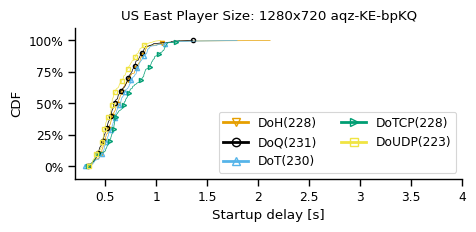

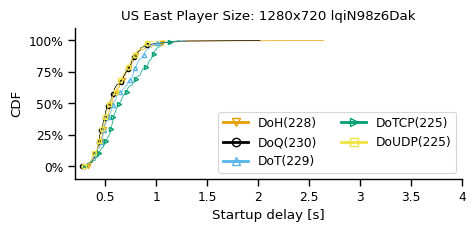

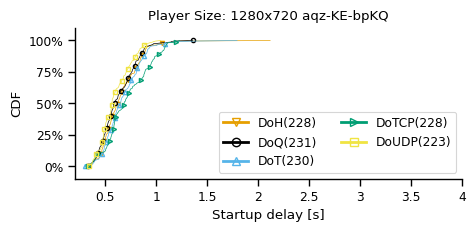

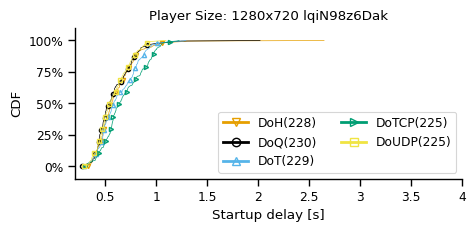

In [164]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.2,4], True)

US East
all vantage points


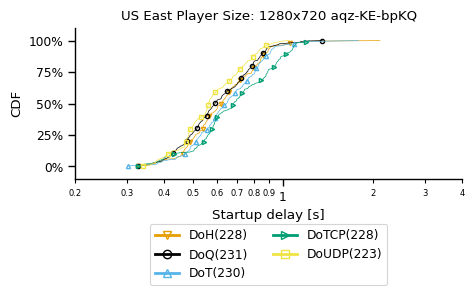

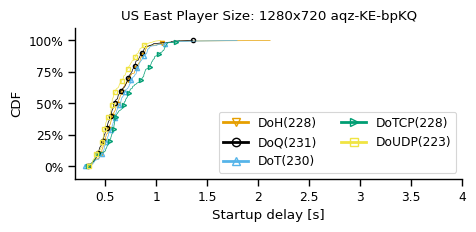

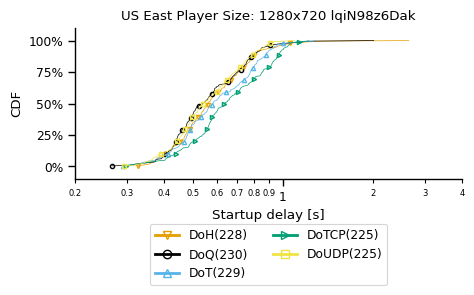

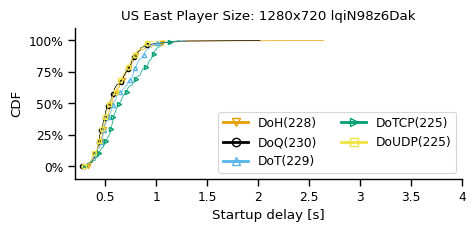

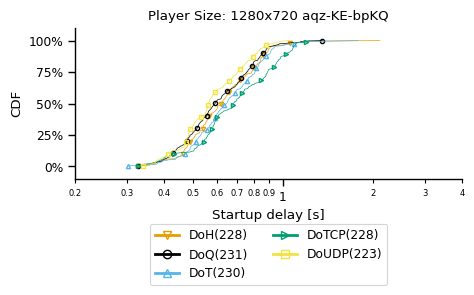

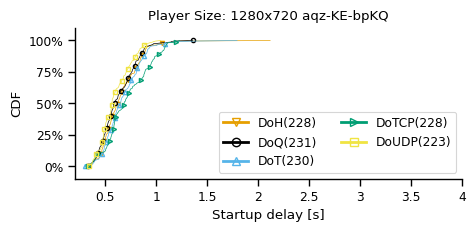

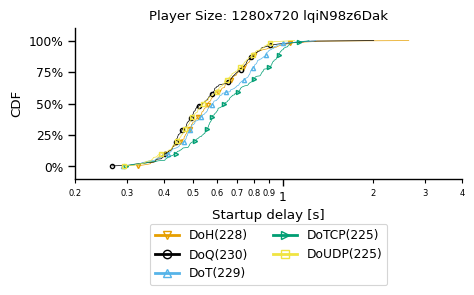

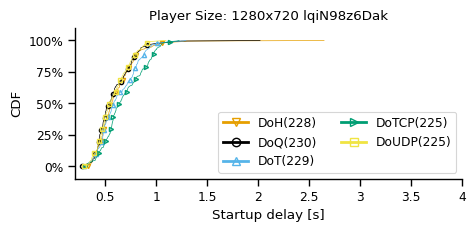

In [165]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.2,4], True)

US East
1


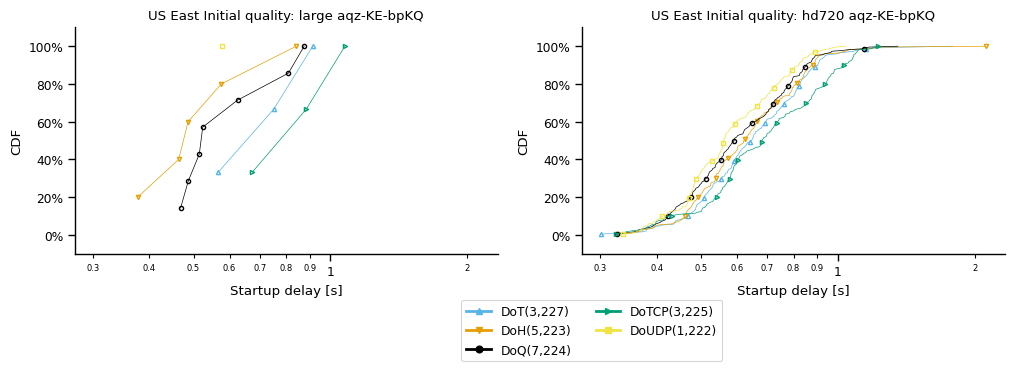

1


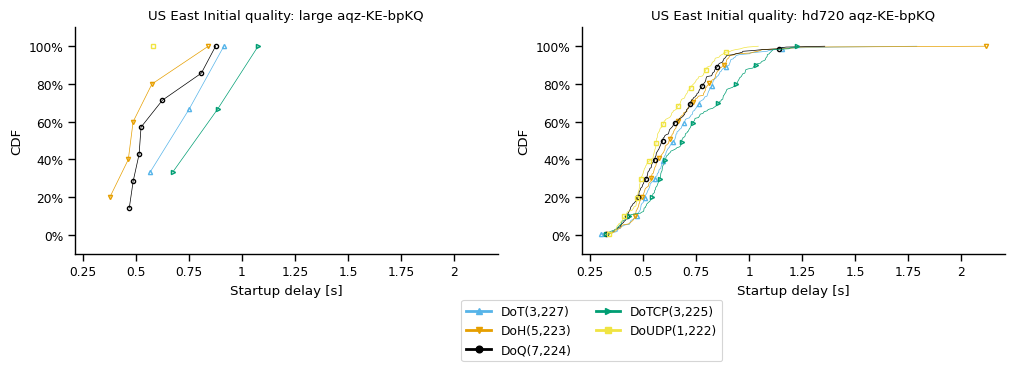

1


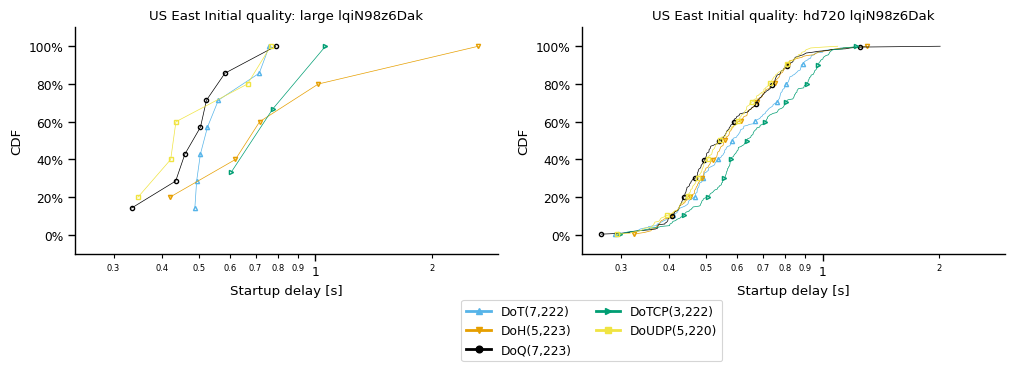

1


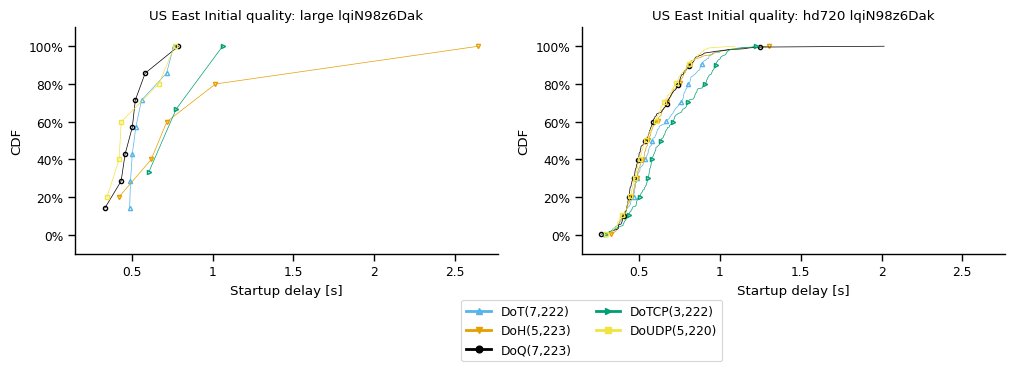

all vantage points


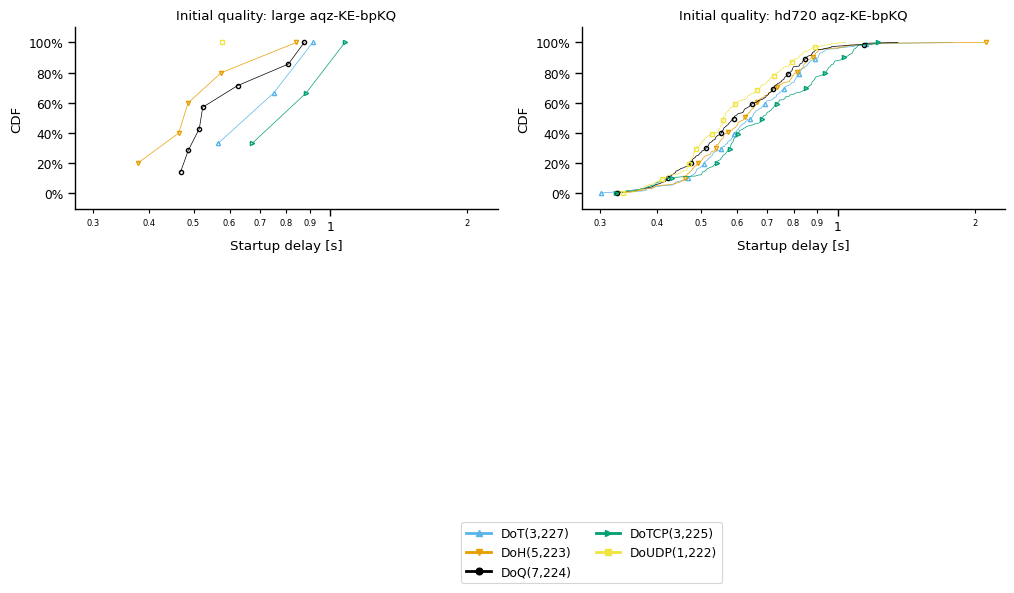

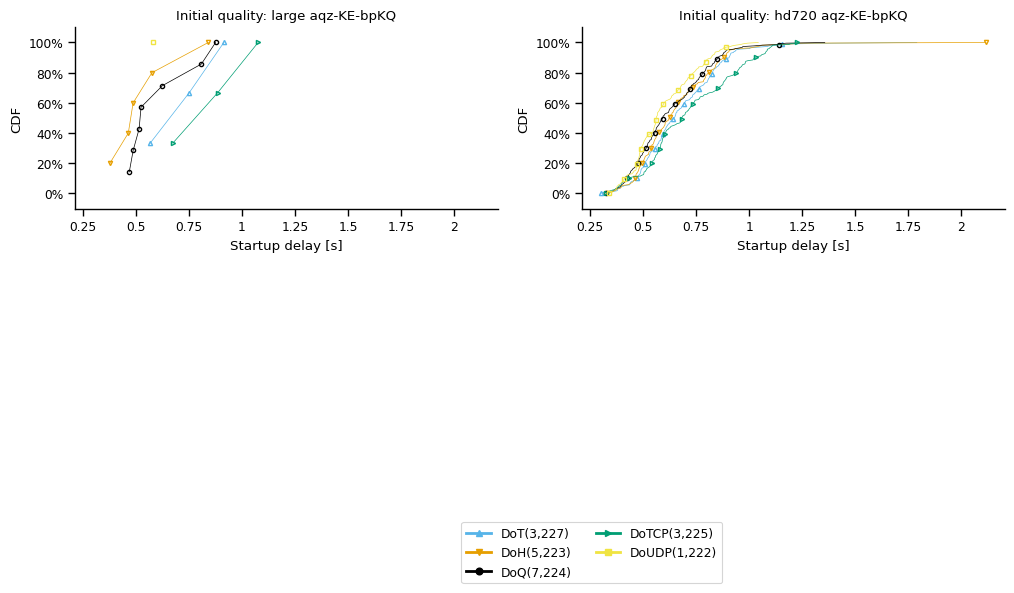

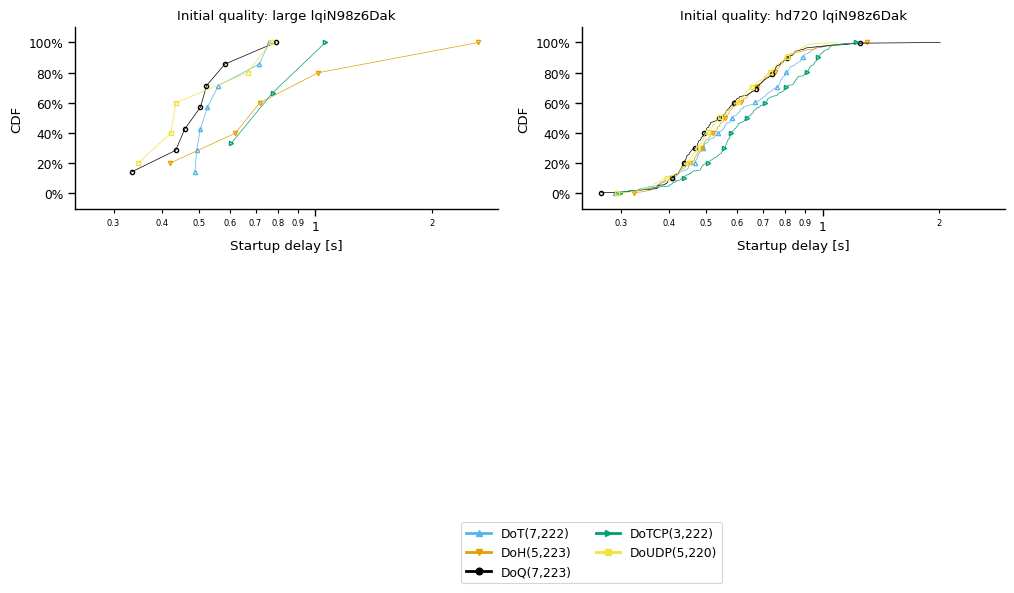

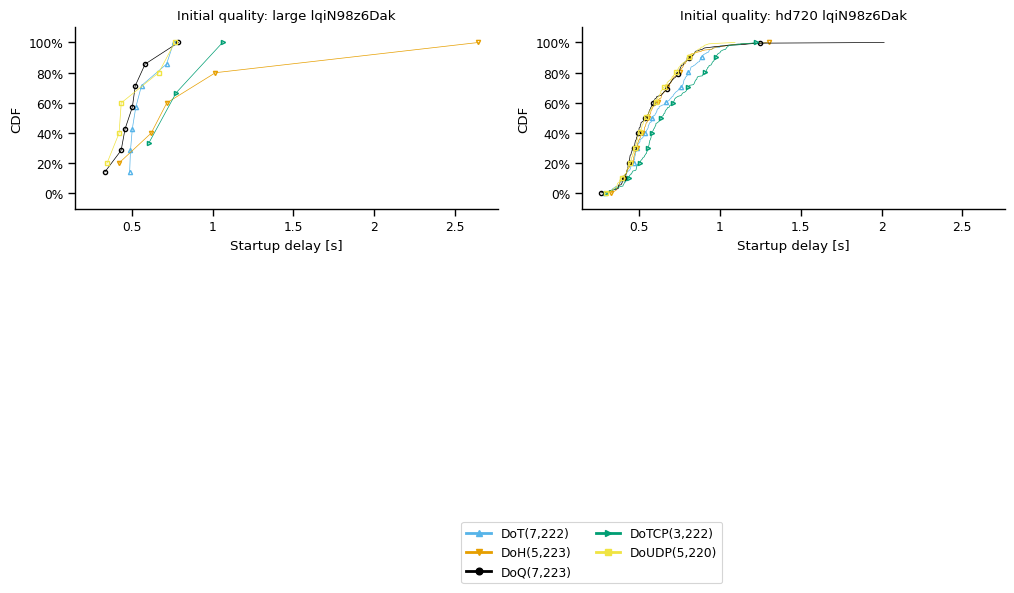

In [166]:
draw_cdf_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], draw_all=True)

US East
all vantage points


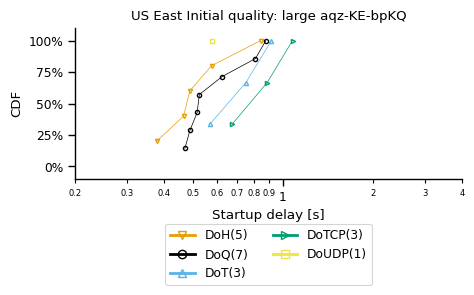

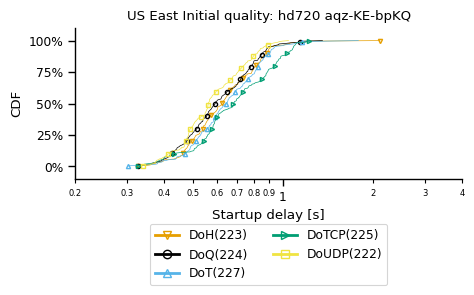

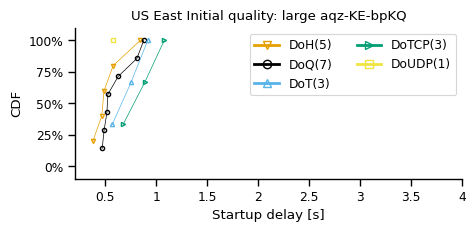

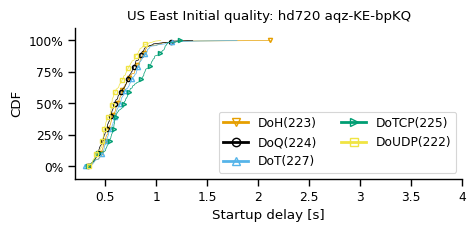

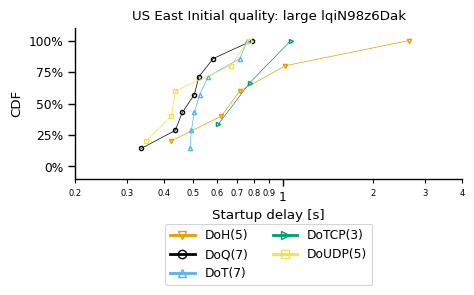

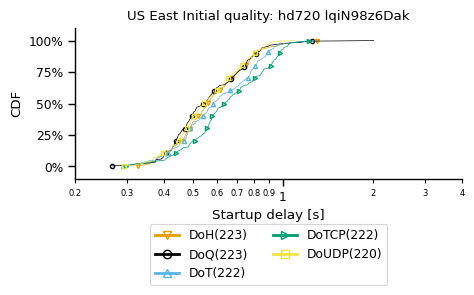

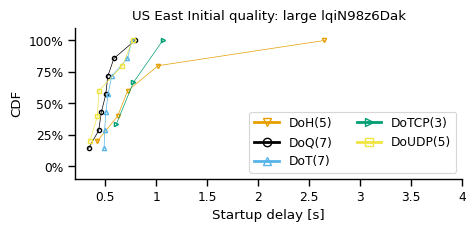

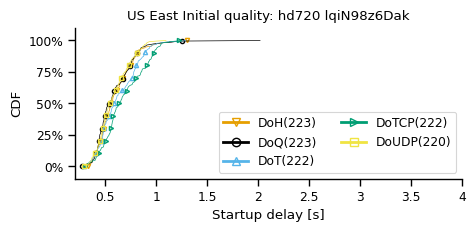

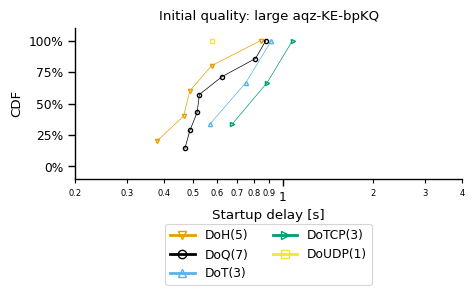

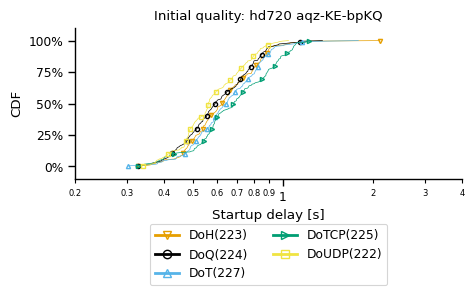

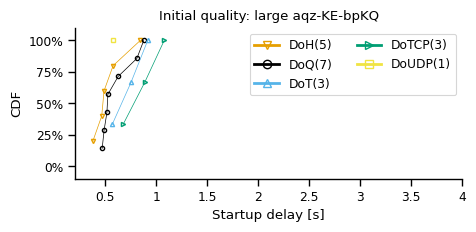

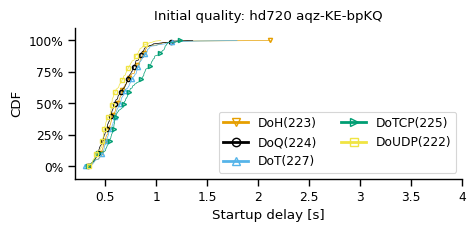

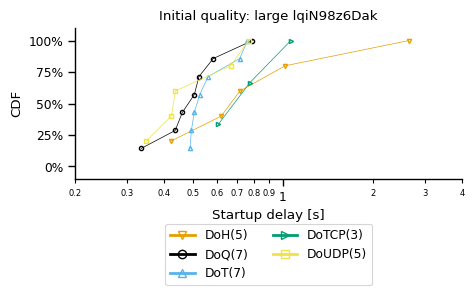

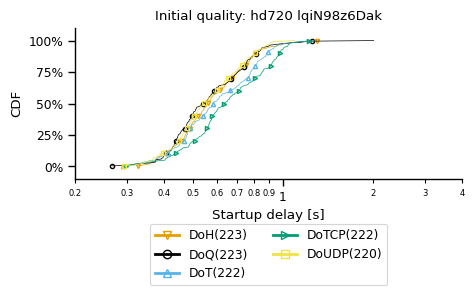

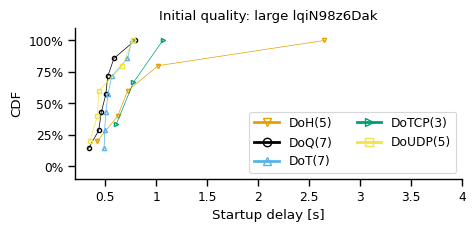

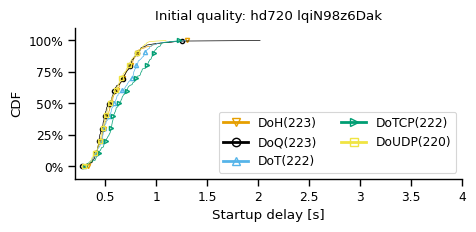

In [167]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.2,4], True)

In [ ]:
#df_player_quality_change_event_to_opt.groupby(['vantagePoint','optimal_res', 'domain']).agg({'msm_id':pd.Series.nunique})

In [258]:
#draw_cdf_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], draw_all=True)

In [259]:
#draw_cdf(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

DoT
count    459.000000
mean       0.650955
std        0.193114
min        0.290400
10%        0.436800
20%        0.486140
25%        0.500050
30%        0.522840
40%        0.567920
50%        0.612200
60%        0.687140
70%        0.762860
75%        0.788600
80%        0.817300
90%        0.892340
100%       1.790600
max        1.790600
Name: startup_delay, dtype: float64
DoH
count    456.000000
mean       0.630400
std        0.210488
min        0.325200
10%        0.425150
20%        0.473200
25%        0.488800
30%        0.506250
40%        0.548400
50%        0.588350
60%        0.641400
70%        0.706100
75%        0.741250
80%        0.784200
90%        0.855100
100%       2.644000
max        2.644000
Name: startup_delay, dtype: float64
DoQ
count    461.000000
mean       0.608338
std        0.186955
min        0.267000
10%        0.418000
20%        0.447500
25%        0.471900
30%        0.484900
40%        0.521100
50%        0.566400
60%        0.622200
70%        0.701

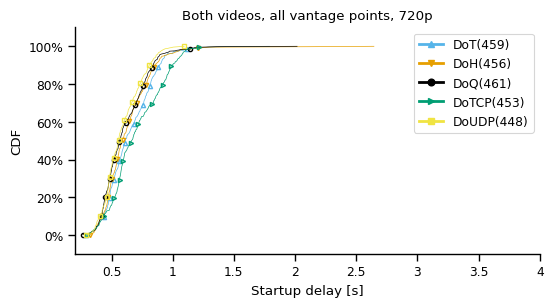

In [168]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_start_time['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = .5
mrksize = 3
log=False
for col_val_ in legend_labels:
    sample_size[col_val_].append(str(len(df_start_time[df_start_time['protocol'] == col_val_]['startup_delay'])))
    if len(df_start_time[df_start_time['protocol'] == col_val_]['startup_delay']) == 0:
        continue
    cdf = Cdf.MakeCdfFromList(df_start_time[df_start_time['protocol'] == col_val_]['startup_delay'])
    print(col_val_)
    print(df_start_time[df_start_time['protocol'] == col_val_]['startup_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    ax.plot(cdf.xs, cdf.ps, label=col_val_,
                linestyle='-', linewidth=lnwidth, 
                markersize=mrksize, fillstyle='none', 
                markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                color=colors[col_val_], marker=markers[col_val_]
            )
    #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
    #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')


    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('Both videos, all vantage points, 720p')

    ax.set_xlabel('Startup delay [s]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim([0.2,4])



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

<AxesSubplot:xlabel='protocol'>

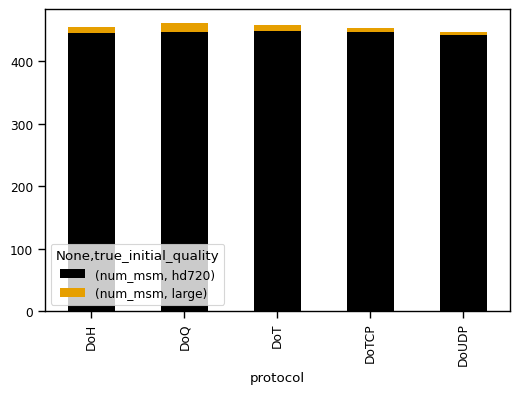

In [169]:
df_start_time.groupby(['protocol', 'true_initial_quality'], observed=True).agg(num_msm=('msm_id', pd.Series.nunique)).unstack().plot(kind='bar', stacked=True)

In [170]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'server']], on='msm_id')

In [171]:
df_start_time.groupby(['server', 'protocol'], as_index=False).agg(startup_delay=('startup_delay', 'median')).pivot(index='server', columns='protocol', values='startup_delay').style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

In [263]:
median_doh_better = 0
median_dot_better = 0
doh_better = []
dot_better = []
for idx, row in df_start_time.groupby(['server', 'protocol']).agg(startup_delay=('startup_delay', 'median')).unstack().reset_index().iterrows():
    row_ = row.droplevel(0)
    #if row_['DoT'] > row_['DoH']:
    if row_['DoT']-row_['DoH'] > 0.02 :
        median_doh_better = median_doh_better+1
        doh_better.append(row['server'].values[0])
    else:
        median_dot_better = median_dot_better+1
        dot_better.append(row['server'].values[0])
print(median_doh_better)
print(median_dot_better)
print(median_dot_better+median_doh_better)
print(doh_better)

115
117
232
['103.172.17.226', '103.176.79.211', '103.227.141.70', '103.232.207.2', '103.232.207.3', '103.237.147.61', '104.238.154.123', '104.244.79.105', '116.118.44.237', '118.163.170.2', '120.55.44.44', '13.250.108.212', '132.226.232.79', '134.209.81.226', '135.125.181.234', '135.125.236.23', '138.2.72.170', '138.2.79.62', '138.2.84.109', '138.3.219.11', '139.59.106.60', '140.238.10.79', '140.238.36.23', '140.238.42.214', '144.22.147.217', '146.56.160.153', '146.56.176.39', '146.56.184.134', '146.59.226.118', '146.59.32.198', '149.56.45.165', '15.165.113.96', '152.69.204.173', '152.70.210.231', '152.70.232.216', '152.70.70.91', '154.49.211.118', '159.223.136.223', '16.162.25.97', '16.162.44.250', '160.16.123.42', '164.90.199.170', '167.99.37.126', '168.138.50.5', '173.255.211.77', '173.82.151.158', '173.82.243.163', '173.82.68.70', '176.103.130.130', '176.103.130.132', '176.103.134.134', '176.103.134.149', '176.103.134.150', '176.103.134.35', '176.103.134.4', '176.103.134.5', '178.

In [264]:
dot_better

['103.105.98.141',
 '103.123.108.197',
 '103.124.95.99',
 '103.179.44.88',
 '103.179.45.33',
 '103.78.123.211',
 '104.199.26.56',
 '104.244.72.39',
 '107.172.103.160',
 '107.172.30.115',
 '107.191.51.151',
 '108.166.219.158',
 '112.213.39.133',
 '128.199.115.141',
 '129.154.226.9',
 '13.124.186.64',
 '130.61.24.160',
 '138.2.91.167',
 '139.162.70.69',
 '140.83.39.110',
 '141.95.140.195',
 '146.56.112.4',
 '146.56.177.76',
 '146.59.23.151',
 '147.189.137.154',
 '150.230.103.62',
 '150.230.99.64',
 '152.70.189.89',
 '152.70.54.34',
 '157.119.101.122',
 '158.101.149.111',
 '160.251.96.67',
 '164.92.136.119',
 '167.99.236.104',
 '168.138.36.90',
 '168.138.53.111',
 '172.104.183.19',
 '172.105.101.43',
 '173.255.211.87',
 '176.102.36.61',
 '176.103.130.131',
 '176.103.130.134',
 '176.103.130.136',
 '176.103.130.137',
 '176.103.130.149',
 '176.103.130.150',
 '176.103.134.135',
 '176.103.134.34',
 '176.113.83.49',
 '180.93.137.1',
 '182.234.39.52',
 '185.121.25.64',
 '185.175.57.120',
 '185.1

DoT
count    230.000000
mean       0.589042
std        0.167656
min        0.290400
10%        0.393430
20%        0.459560
25%        0.473875
30%        0.487610
40%        0.512780
50%        0.552650
60%        0.590380
70%        0.651290
75%        0.691625
80%        0.748380
90%        0.819050
100%       1.154100
max        1.154100
Name: startup_delay, dtype: float64
DoH
count    227.000000
mean       0.646953
std        0.247729
min        0.327000
10%        0.427940
20%        0.477140
25%        0.495200
30%        0.516600
40%        0.551480
50%        0.586900
60%        0.641280
70%        0.707420
75%        0.760600
80%        0.803180
90%        0.888880
100%       2.644000
max        2.644000
Name: startup_delay, dtype: float64
DoQ
count    232.000000
mean       0.579881
std        0.160342
min        0.267000
10%        0.402580
20%        0.439560
25%        0.449575
30%        0.472240
40%        0.502220
50%        0.546700
60%        0.583840
70%        0.646

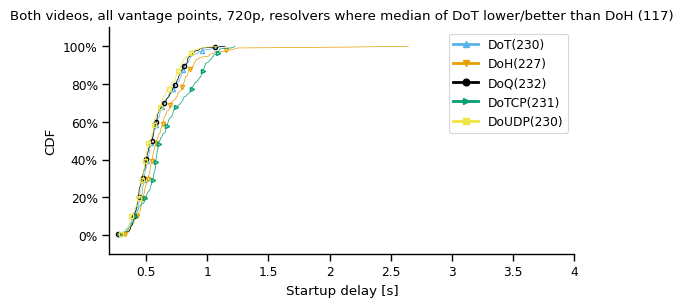

In [265]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_start_time['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = .5
mrksize = 3
log=False
for col_val_ in legend_labels:
    sample_size[col_val_].append(str(len(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(dot_better))]['startup_delay'])))
    if len(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(dot_better))]['startup_delay']) == 0:
        continue
    cdf = Cdf.MakeCdfFromList(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(dot_better))]['startup_delay'])
    print(col_val_)
    print(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(dot_better))]['startup_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    ax.plot(cdf.xs, cdf.ps, label=col_val_,
                linestyle='-', linewidth=lnwidth, 
                markersize=mrksize, fillstyle='none', 
                markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                color=colors[col_val_], marker=markers[col_val_]
            )
    #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
    #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')


    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('Both videos, all vantage points, 720p, resolvers where median of DoT lower/better than DoH ('+str(median_dot_better)+')')

    ax.set_xlabel('Startup delay [s]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim([0.2,4])



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

DoT
count    229.000000
mean       0.713139
std        0.197309
min        0.297600
10%        0.477680
20%        0.543260
25%        0.572000
30%        0.590880
40%        0.651080
50%        0.713200
60%        0.764540
70%        0.813320
75%        0.832800
80%        0.873180
90%        0.915720
100%       1.790600
max        1.790600
Name: startup_delay, dtype: float64
DoH
count    229.000000
mean       0.613992
std        0.164443
min        0.325200
10%        0.424600
20%        0.470060
25%        0.485200
30%        0.497160
40%        0.543600
50%        0.589800
60%        0.651040
70%        0.696800
75%        0.725400
80%        0.755460
90%        0.826440
100%       1.302300
max        1.302300
Name: startup_delay, dtype: float64
DoQ
count    229.000000
mean       0.637168
std        0.206907
min        0.315200
10%        0.427600
20%        0.470360
25%        0.484100
30%        0.500400
40%        0.545440
50%        0.598100
60%        0.674220
70%        0.726

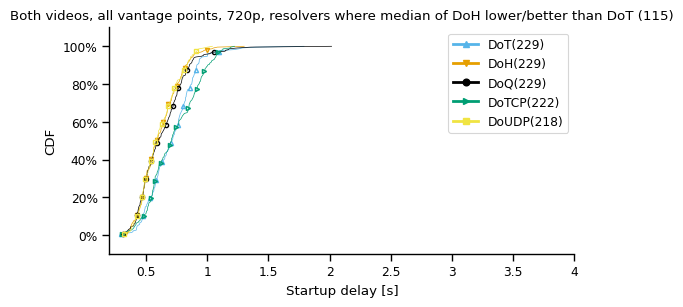

In [266]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_start_time['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = .5
mrksize = 3
log=False
for col_val_ in legend_labels:
    sample_size[col_val_].append(str(len(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(doh_better))]['startup_delay'])))
    if len(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(doh_better))]['startup_delay']) == 0:
        continue
    cdf = Cdf.MakeCdfFromList(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(doh_better))]['startup_delay'])
    print(col_val_)
    print(df_start_time[(df_start_time['protocol'] == col_val_) & (df_start_time.server.isin(doh_better))]['startup_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    ax.plot(cdf.xs, cdf.ps, label=col_val_,
                linestyle='-', linewidth=lnwidth, 
                markersize=mrksize, fillstyle='none', 
                markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                color=colors[col_val_], marker=markers[col_val_]
            )
    #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
    #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')


    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('Both videos, all vantage points, 720p, resolvers where median of DoH lower/better than DoT ('+str(median_doh_better)+')')

    ax.set_xlabel('Startup delay [s]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim([0.2,4])



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

## Lookup times

In [408]:
df_resolution_lookups = pd.read_sql_query("SELECT measurement_id as msm_id, elapsed, status, answer, domain as queried_domain FROM lookups", conn)

In [409]:
df_resolution_lookups = df_resolution_lookups[df_resolution_lookups.msm_id.isin(measurements.msm_id.unique())]

In [410]:
df_resolution_lookups.groupby('msm_id', as_index=False).size().sort_values('size')

msm_id  size
68455   95b96e82-d7c0-85cb-2a8e-9d1324acd5f5     6
37072   512720ca-44db-d578-eaf6-be544d10e6b6     6
10702   1769a1b8-797d-6e27-69e2-c3fc00e2b73f     6
74676   a35ccca9-ea4c-7396-bcc2-93d214b7c957     6
104807  e5d8a0c4-1305-9470-0792-8aeb97fa57ad     6
...                                      ...   ...
94764   cf964e96-a50e-d930-398a-a6c4997452bc    18
102690  e124def6-be0e-19ab-9d8e-5d48de5f4b2a    18
96948   d4937175-6255-275a-8604-232c99769a76    18
81256   b1f1fc74-608a-4c74-b5c4-7361c2b147fc    18
87668   bff2e67f-03c7-1561-024c-2825f4cd2779    18

[116621 rows x 2 columns]

In [411]:
df_resolution_lookups[(df_resolution_lookups.status == 'NOERROR')].queried_domain.value_counts()

www.youtube.com.                     118597
i.ytimg.com.                         118127
jnn-pa.googleapis.com.               116694
www.gstatic.com.                     116621
www.google.com.                      116597
                                      ...  
r2---sn-3u-bh2sy.googlevideo.com.         1
r3---sn-vgqsrnes.googlevideo.com.         1
r4---sn-ogul7n76.googlevideo.com.         1
r1---sn-npoe7nl6.googlevideo.com.         1
r5---sn-4g5lzned.googlevideo.com.         1
Name: queried_domain, Length: 2874, dtype: int64

In [412]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].queried_domain.value_counts()

Series([], Name: queried_domain, dtype: int64)

In [413]:
df_resolution_lookups.elapsed.describe()

count    1.162780e+06
mean     2.501338e+02
std      2.300579e+02
min      8.309880e-01
25%      1.258990e+02
50%      2.039255e+02
75%      3.148357e+02
max      2.616433e+04
Name: elapsed, dtype: float64

In [414]:
df_resolution_lookups = pd.merge(measurements[['msm_id', 'protocol', 'server', 'vantagePoint', 'domain', 'player_dimensions']], df_resolution_lookups, on='msm_id')

In [415]:
df_resolution_lookups = pd.merge(df_true_initial_quality[['msm_id', 'true_initial_quality']], df_resolution_lookups, on='msm_id')

In [416]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].groupby('server', as_index=False).agg({'queried_domain':pd.Series.unique})

Empty DataFrame
Columns: [server, queried_domain]
Index: []

In [417]:
df_resolution_lookups[df_resolution_lookups.status != 'NOERROR'].groupby('msm_id', as_index=False).agg({'queried_domain':pd.Series.unique})

Empty DataFrame
Columns: [msm_id, queried_domain]
Index: []

In [418]:
df_resolution_lookups[df_resolution_lookups.status == 'SERVFAIL']['answer'].tolist()

[]

In [419]:
df_resolution_lookups[df_resolution_lookups.status == 'SERVFAIL'].protocol.value_counts()

Series([], Name: protocol, dtype: int64)

In [420]:
df_googlevideo_lookup_time = df_resolution_lookups[df_resolution_lookups.queried_domain.str.endswith('.googlevideo.com.')].groupby(['vantagePoint', 'domain', 'player_dimensions', 'protocol']).agg({'elapsed':'median'}).reset_index().copy().dropna()
df_overall_lookup_time = df_resolution_lookups.groupby(['vantagePoint', 'domain', 'player_dimensions', 'protocol']).agg({'elapsed':'median'}).reset_index().copy().dropna()

In [421]:
df_googlevideo_lookup_time.rename(columns=lambda x: x.replace('elapsed', 'metric'), inplace=True)
df_googlevideo_lookup_time.rename(columns=lambda x: x.replace('player_dimensions', 'resolution'), inplace=True)
df_overall_lookup_time.rename(columns=lambda x: x.replace('elapsed', 'metric'), inplace=True)
df_overall_lookup_time.rename(columns=lambda x: x.replace('player_dimensions', 'resolution'), inplace=True)

In [422]:
df_googlevideo_lookup_time['protocol'] = pd.Categorical(df_googlevideo_lookup_time['protocol'], ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP'])
df_overall_lookup_time['protocol'] = pd.Categorical(df_overall_lookup_time['protocol'], ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP'])

df_start_time, 'player_dimensions', 'protocol', 'startup_delay'

In [423]:
#startup_delay_medians = df_start_time[df_start_time.true_initial_quality.isin(['hd720', 'hd1080', 'hd1440', 'hd2160'])].groupby(['vantagePoint', 'domain', 'true_initial_quality', 'protocol']).agg({'startup_delay':'median'}).reset_index().copy().dropna()
#startup_delay_medians['true_initial_quality'] = startup_delay_medians['true_initial_quality'].map(map_quality_to_res)
#startup_delay_medians.rename(columns=lambda x: x.replace('startup_delay', 'metric'), inplace=True)
#startup_delay_medians.rename(columns=lambda x: x.replace('true_initial_quality', 'resolution'), inplace=True)

In [424]:
startup_delay_medians = df_start_time.groupby(['vantagePoint', 'domain', 'player_dimensions', 'protocol']).agg({'startup_delay':'median'}).reset_index().copy().dropna()
startup_delay_medians.rename(columns=lambda x: x.replace('startup_delay', 'metric'), inplace=True)
startup_delay_medians.rename(columns=lambda x: x.replace('player_dimensions', 'resolution'), inplace=True)

In [425]:
startup_delay_medians['protocol'] = pd.Categorical(startup_delay_medians['protocol'], ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP'])

In [426]:
#make_quality_column_sortable(startup_delay_medians, 'true_initial_quality')

In [427]:
startup_delay_medians.sort_values(['domain', 'resolution', 'protocol'], inplace=True)

In [428]:
startup_delay_medians['metric'] = startup_delay_medians['metric'] * 1000

In [429]:
startup_delay_medians['resolution'].cat.remove_unused_categories(inplace=True)

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay'

In [430]:
delay_to_opt_medians = df_player_quality_change_event_to_opt.groupby(['vantagePoint', 'domain', 'optimal_res', 'protocol']).agg({'optimal_quality_delay':'median'}).reset_index().copy().dropna()

In [431]:
#make_res_column_sortable(delay_to_opt_medians, 'optimal_res')

In [432]:
delay_to_opt_medians['protocol'] = pd.Categorical(delay_to_opt_medians['protocol'], ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP'])

In [433]:
delay_to_opt_medians.sort_values(['domain', 'optimal_res', 'protocol'], inplace=True)

In [434]:
delay_to_opt_medians['optimal_quality_delay'] = delay_to_opt_medians['optimal_quality_delay'] * 1000

In [435]:
delay_to_opt_medians.rename(columns=lambda x: x.replace('optimal_quality_delay', 'metric'), inplace=True)
delay_to_opt_medians.rename(columns=lambda x: x.replace('optimal_res', 'resolution'), inplace=True)

In [436]:
#delay_to_opt_medians[(delay_to_opt_medians.vantagePoint == "") & (delay_to_opt_medians.domain == 'aqz-KE-bpKQ')].pivot(index='resolution', columns='protocol', values='metric').style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

In [437]:
#startup_delay_medians[(startup_delay_medians.vantagePoint == "") & (startup_delay_medians.domain == 'aqz-KE-bpKQ')].pivot(index='resolution', columns='protocol', values='metric').style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

In [438]:
#df_googlevideo_lookup_time[(df_googlevideo_lookup_time.vantagePoint == "") & (df_googlevideo_lookup_time.domain == 'aqz-KE-bpKQ')].pivot(index='resolution', columns='protocol', values='metric').style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

In [439]:
#df_overall_lookup_time[(df_overall_lookup_time.vantagePoint == "") & (df_overall_lookup_time.domain == 'aqz-KE-bpKQ')].pivot(index='resolution', columns='protocol', values='metric').style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

Africa South


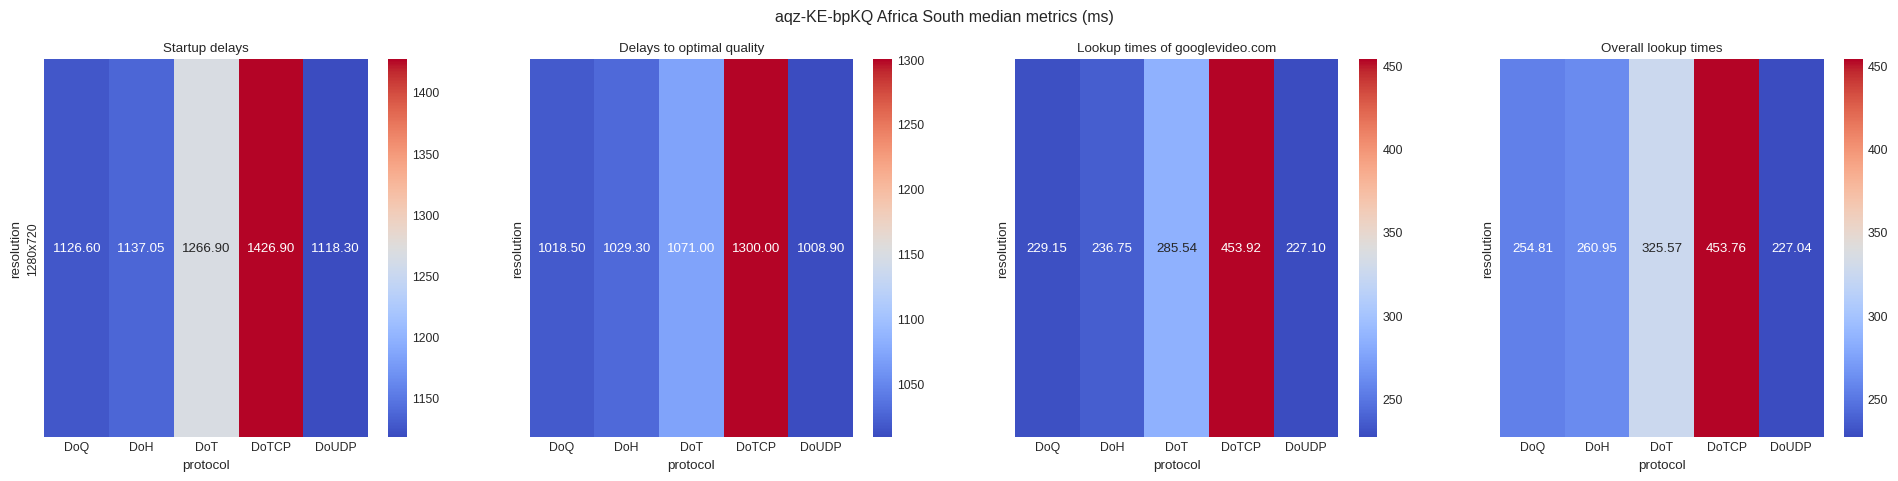

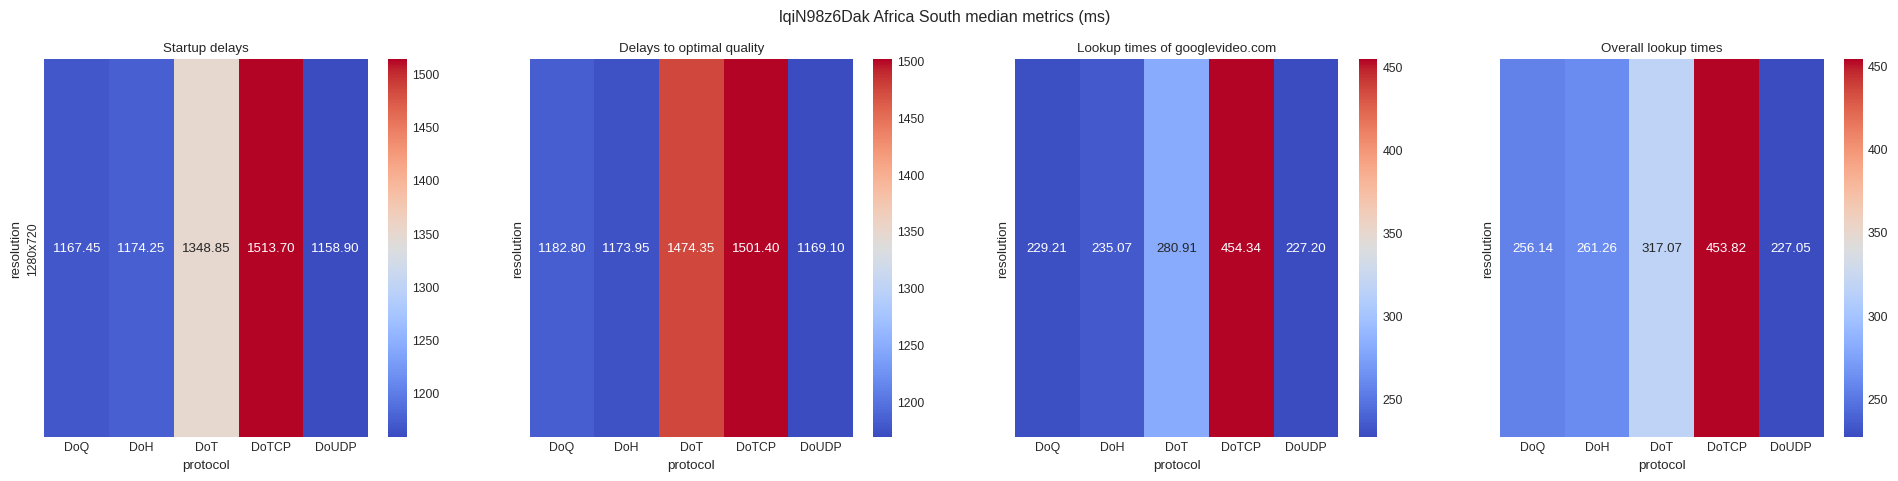

Asia Pacific Northeast


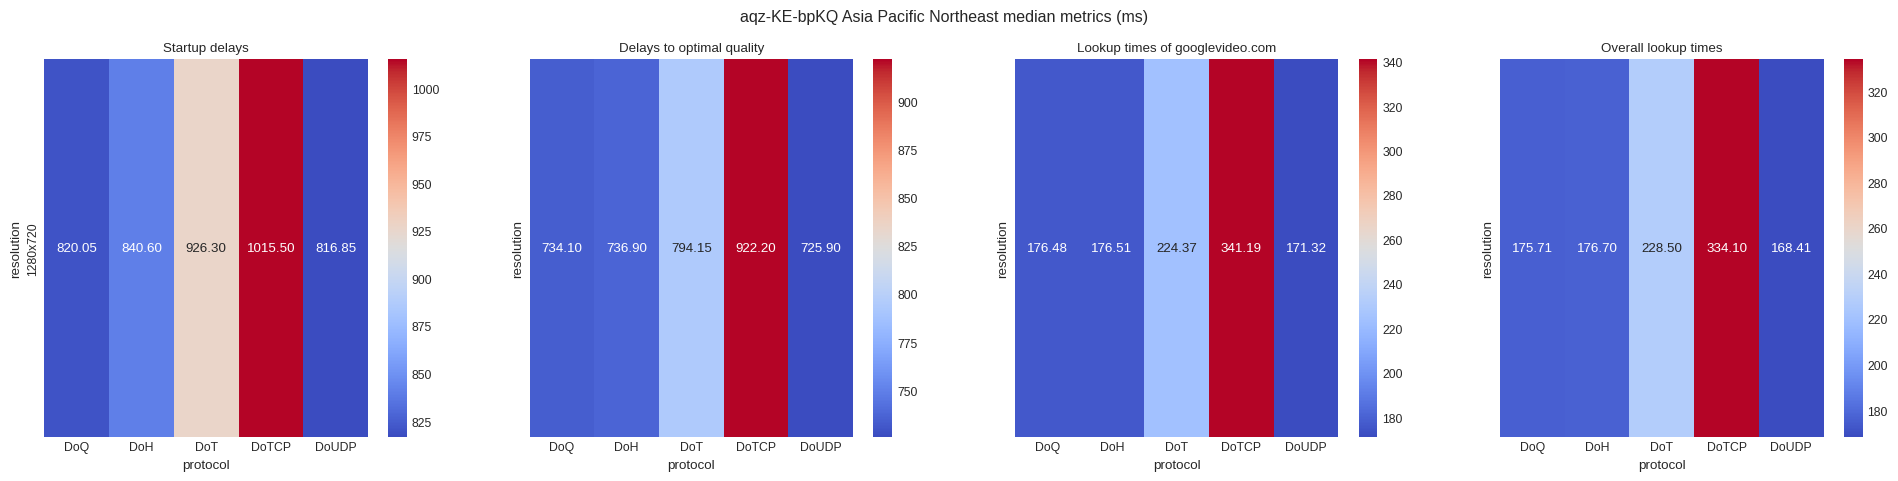

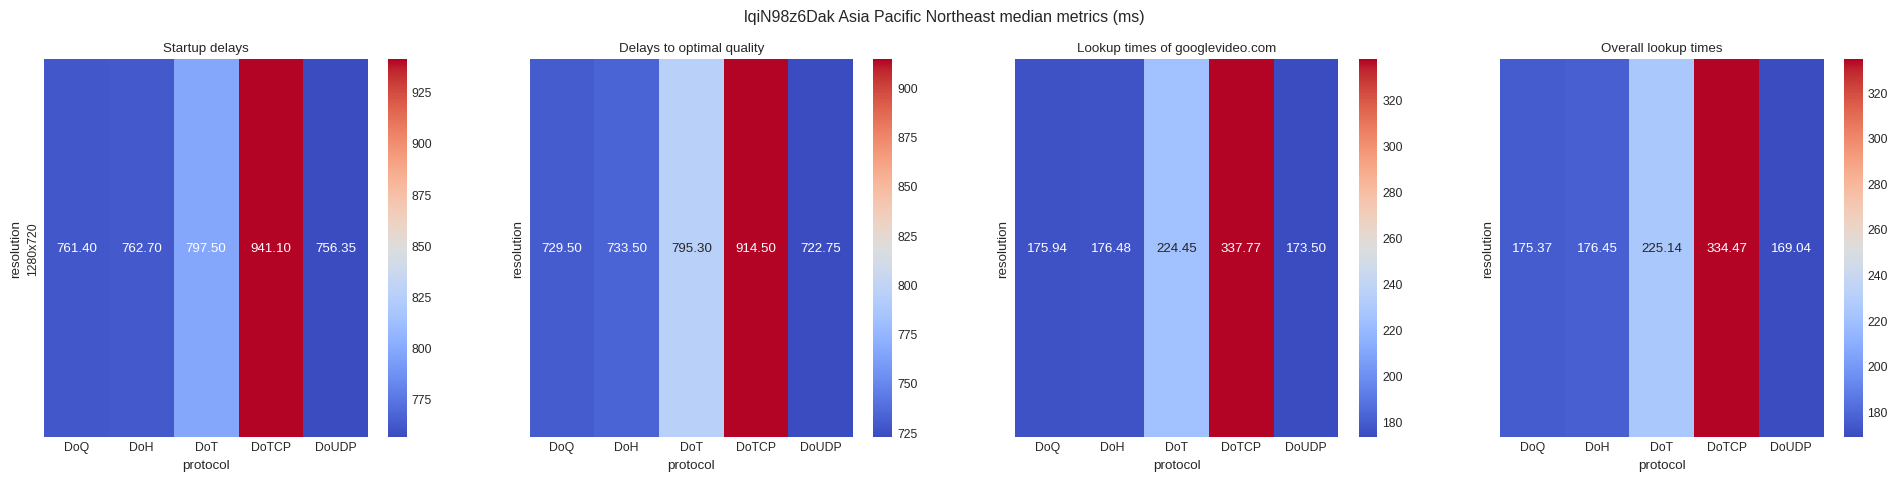

Asia Pacific Southeast


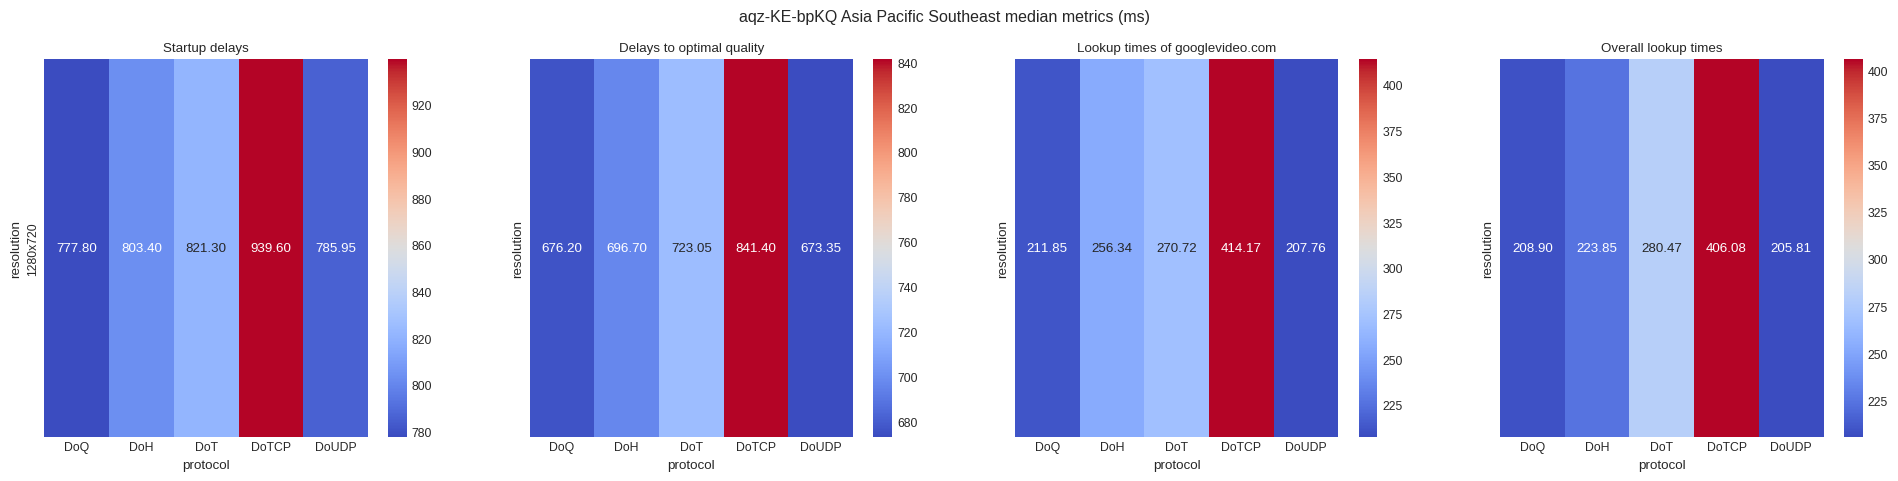

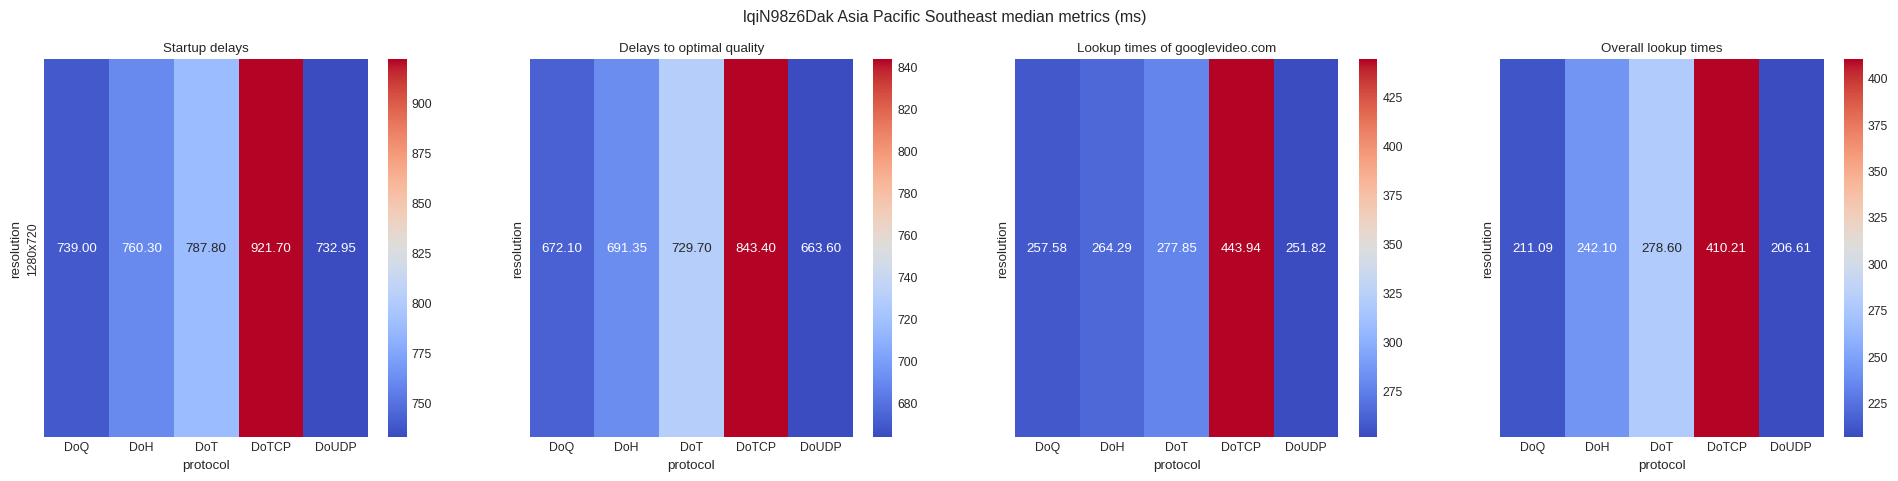

Europe Central


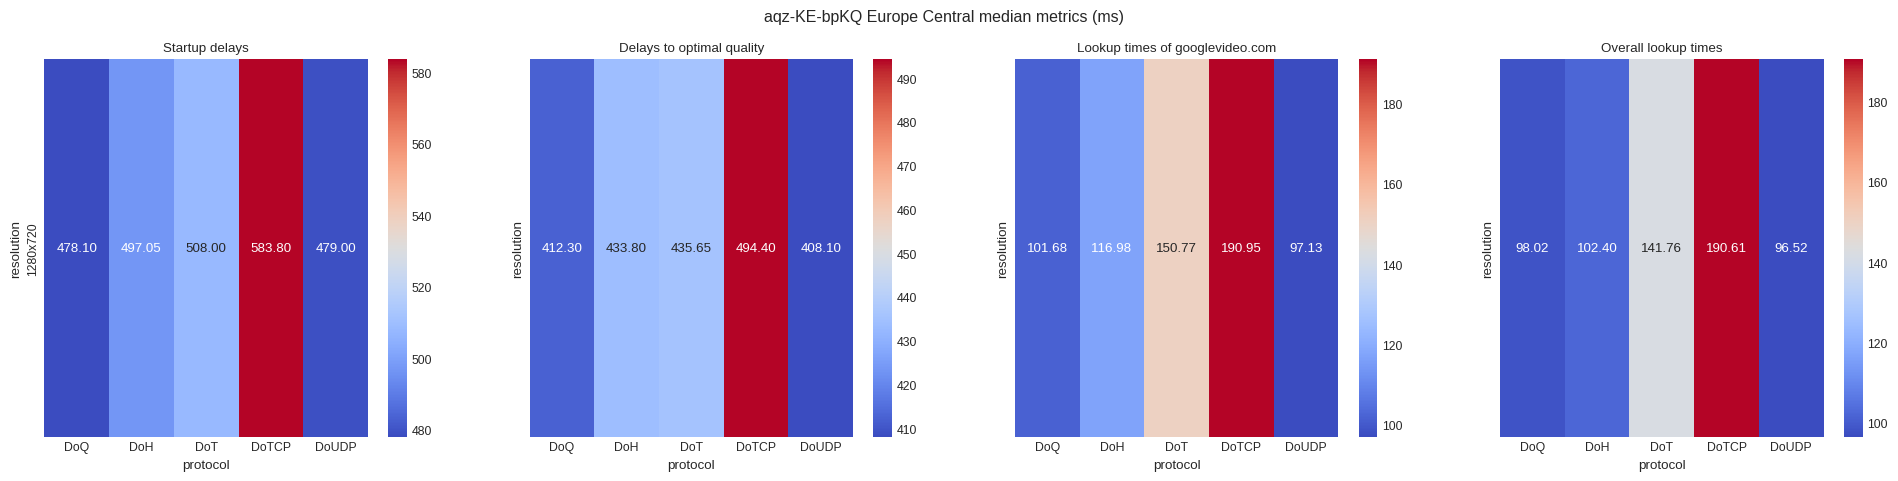

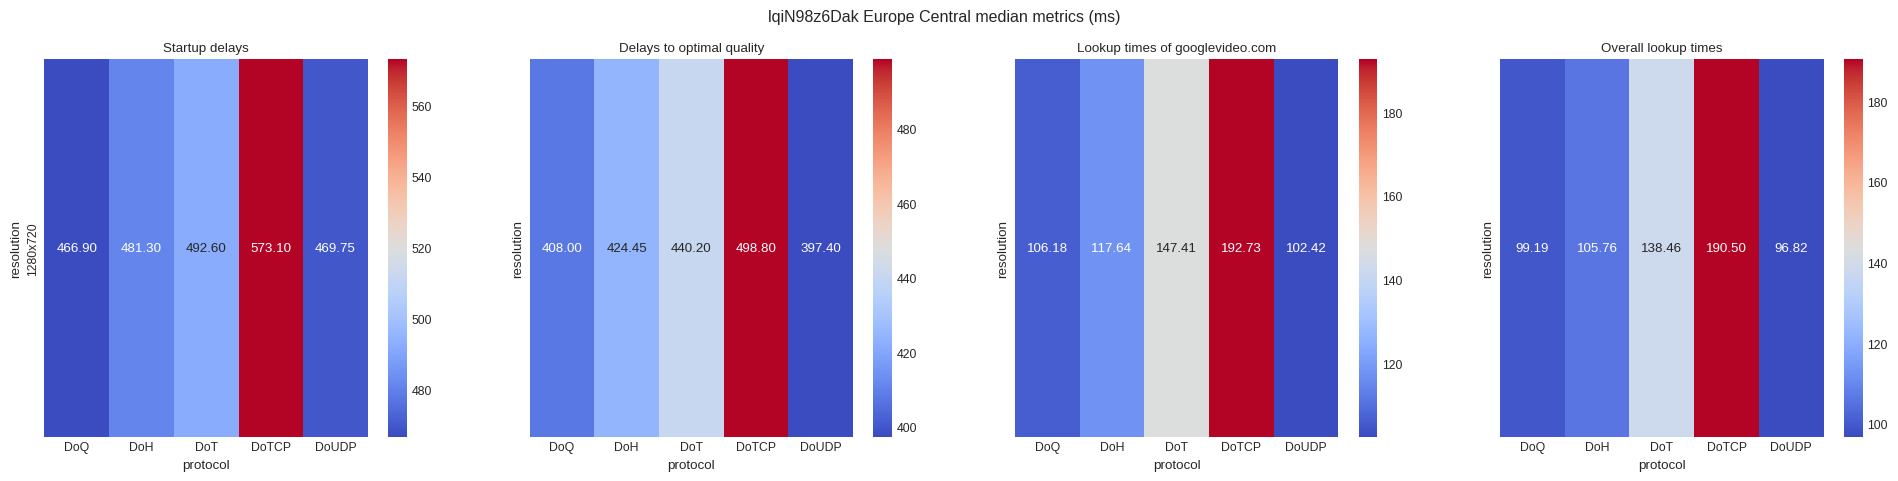

South America East


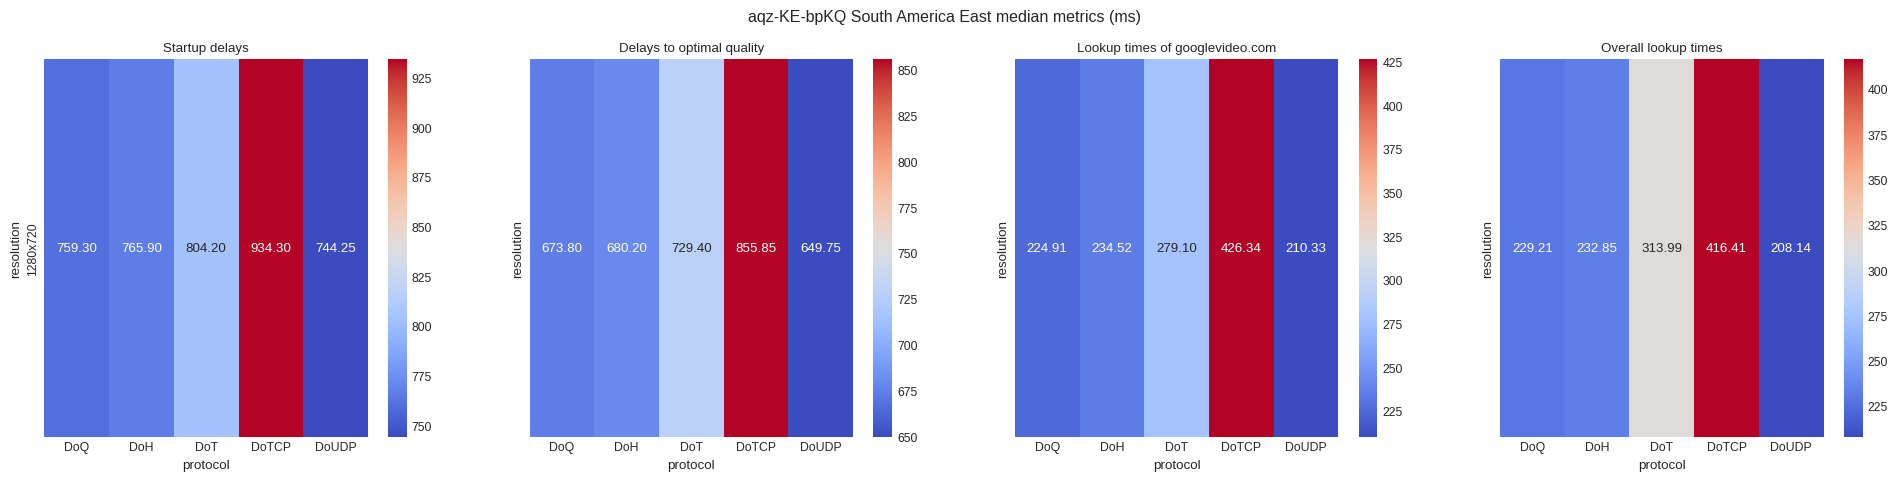

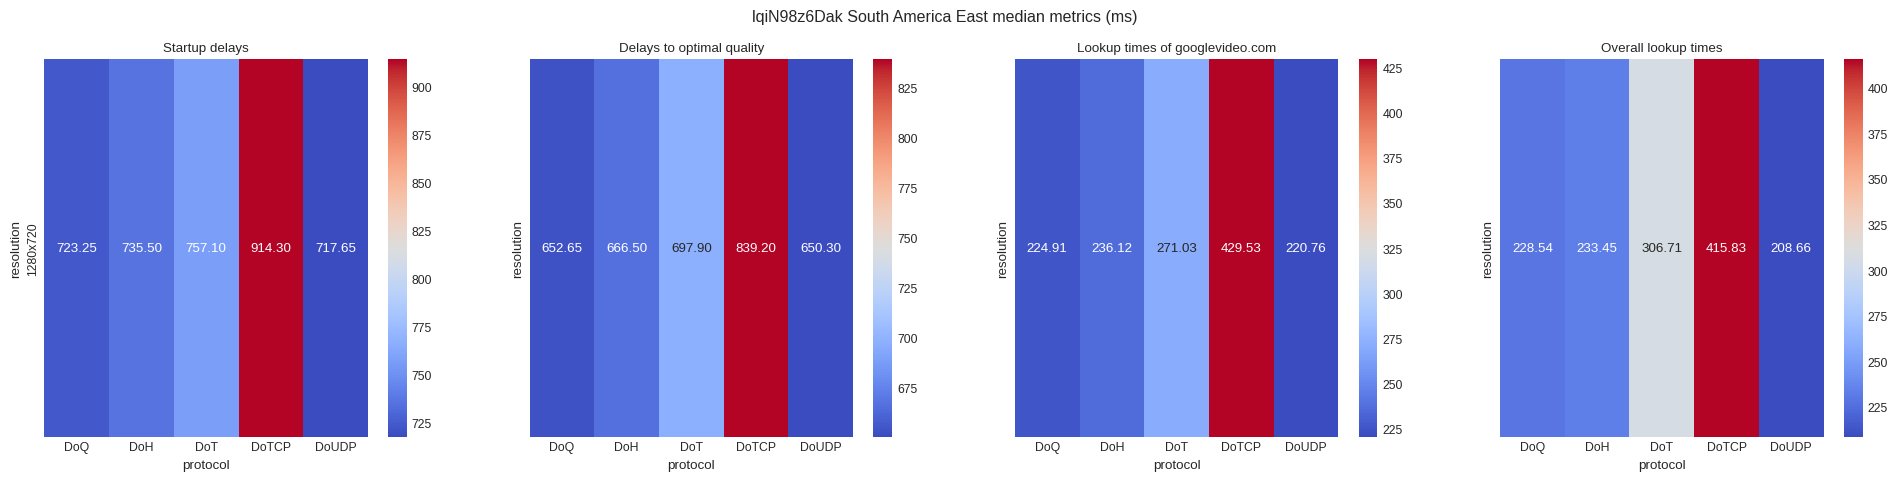

US East


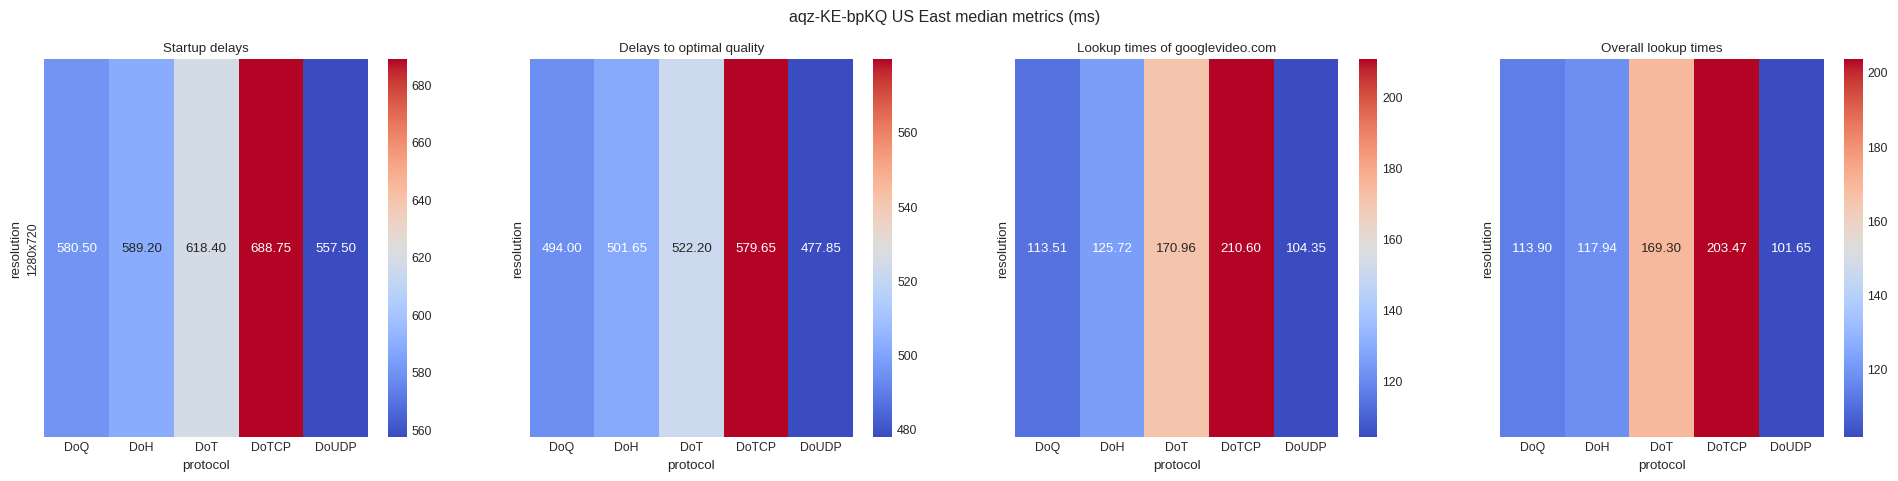

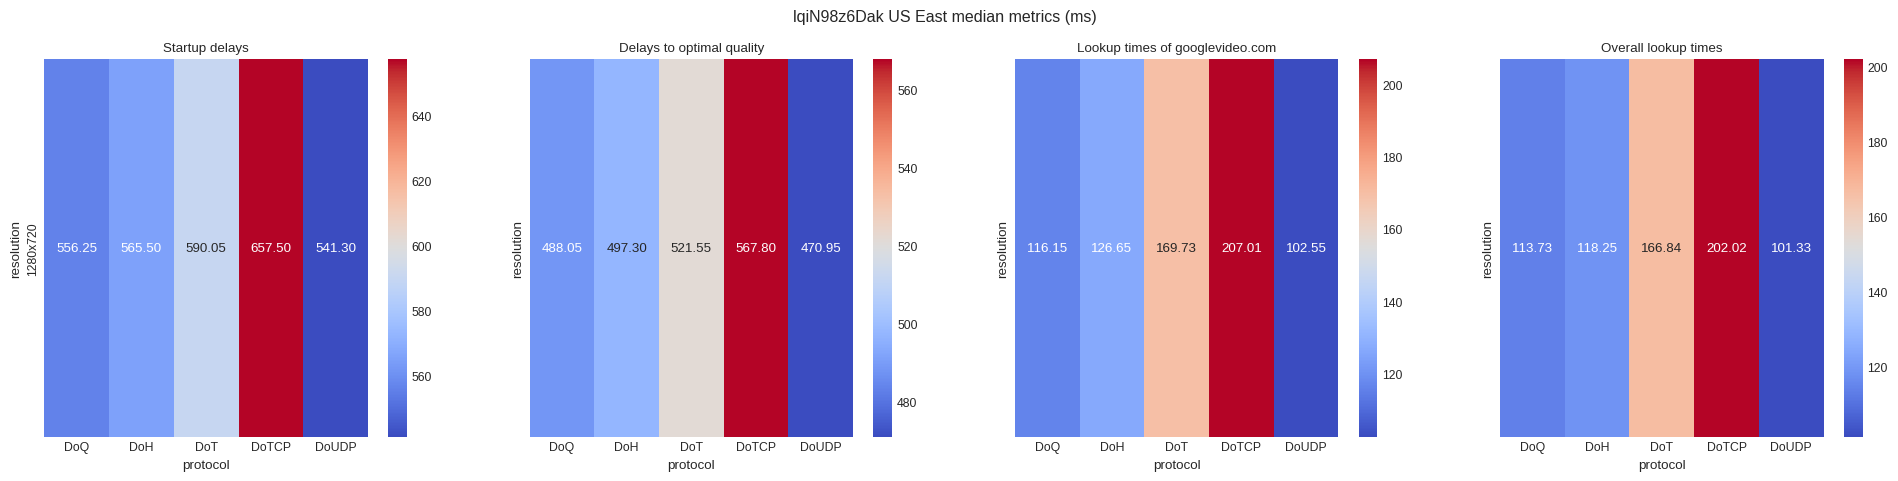

US West


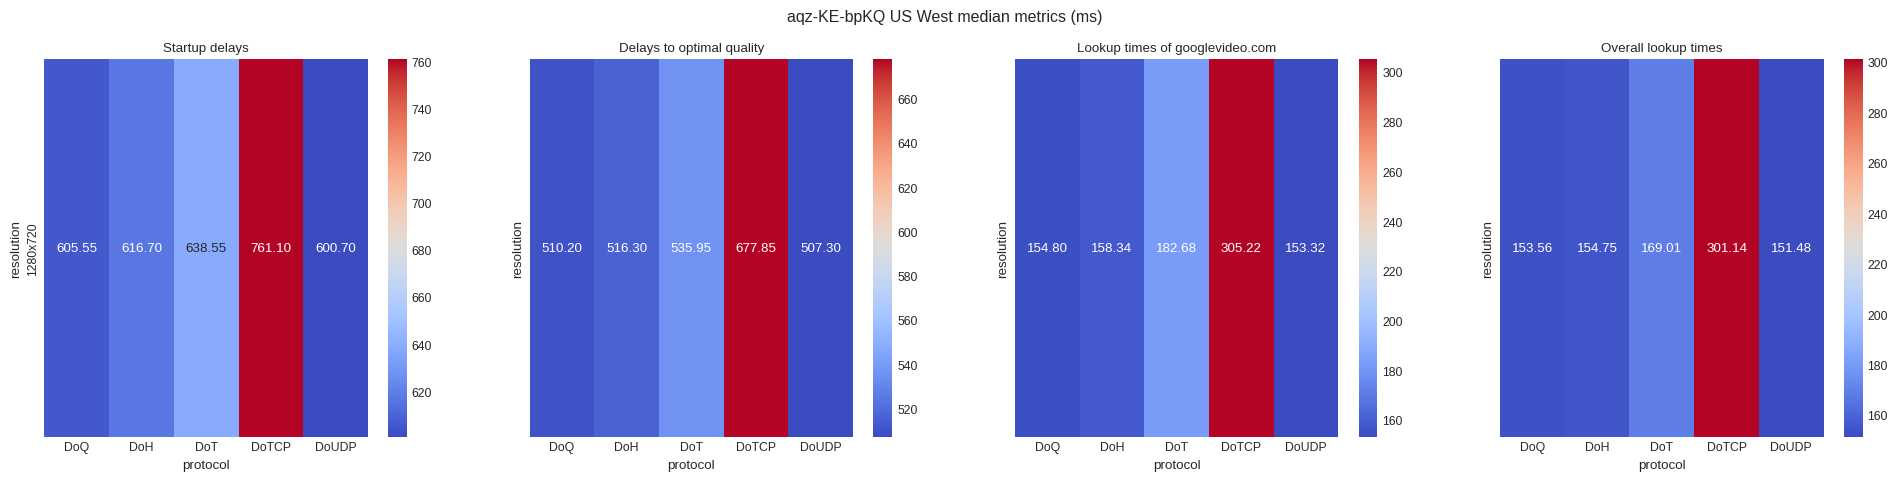

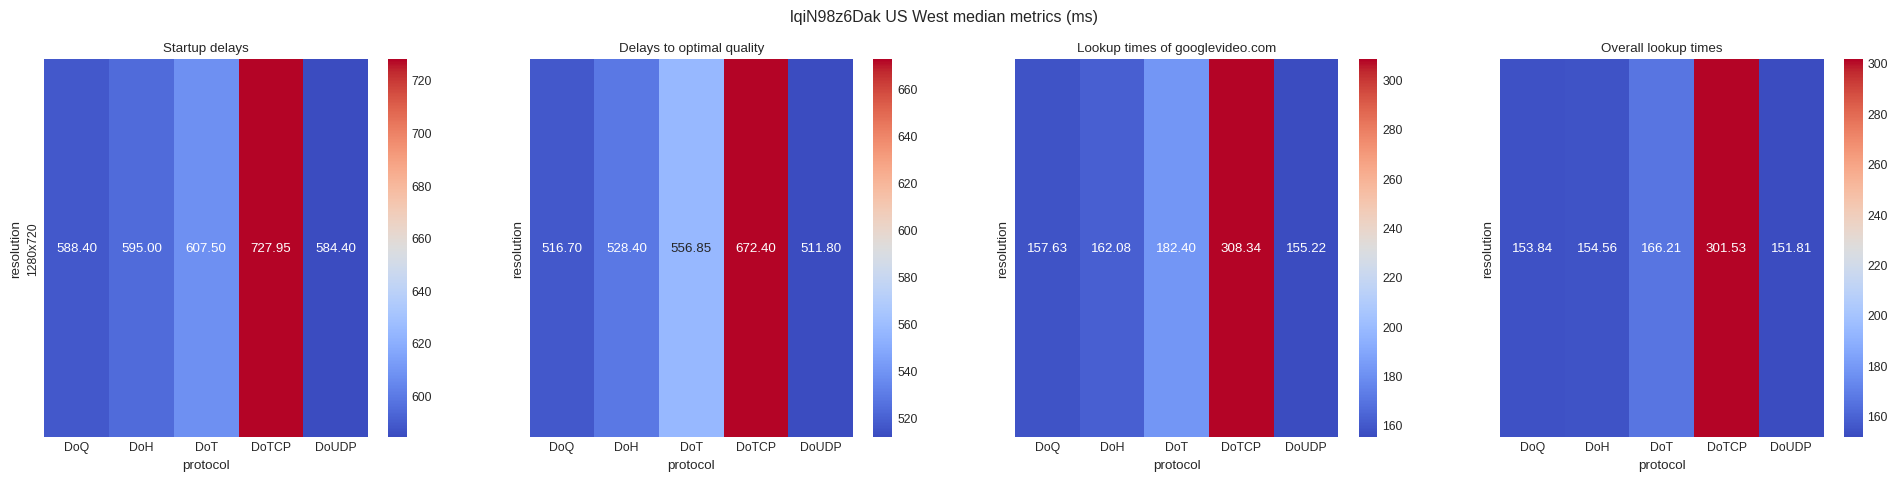

In [440]:
with plt.style.context('seaborn-whitegrid'):
    for vp in sorted(measurements['vantagePoint'].unique().tolist()):
        print(vp)
        for video in measurements['domain'].unique():
            fig, axs = plt.subplots(1, 4, sharex='all', figsize=(24,5), sharey='all')
            #fig.subplots_adjust(hspace=.2, wspace=.3)
            fig.suptitle(video+' '+vp+' median metrics (ms)')
            df_tmp_1 = startup_delay_medians[(startup_delay_medians.vantagePoint == vp) & (startup_delay_medians.domain == video)]
            df_tmp_2 = delay_to_opt_medians[(delay_to_opt_medians.vantagePoint == vp) & (delay_to_opt_medians.domain == video)]
            df_tmp_3 = df_googlevideo_lookup_time[(df_googlevideo_lookup_time.vantagePoint == vp) & (df_googlevideo_lookup_time.domain == video)]
            df_tmp_4 = df_overall_lookup_time[(df_overall_lookup_time.vantagePoint == vp) & (df_overall_lookup_time.domain == video)]

            for df, ax, title in zip(
                [df_tmp_1, df_tmp_2, df_tmp_3, df_tmp_4],
                axs.flat, ['Startup delays', 'Delays to optimal quality', 'Lookup times of googlevideo.com', 'Overall lookup times']):
                sns.heatmap(df.pivot(index='resolution', columns='protocol', values='metric'), ax=ax, cmap="coolwarm", annot=True, fmt='.2f')
                ax.set_title(title)

            plt.show()

In [325]:
#dbs = ['web-performance-youtube-afsouth.db', 'web-performance-youtube-apnorth.db', 'web-performance-youtube-apsouth.db', 'web-performance-youtube-eucentral.db', 'web-performance-youtube-saeast.db', 'web-performance-youtube-useast.db', 'web-performance-youtube-uswest.db']


#for db in dbs:
#    vp_conn = sqlite3.connect("dataset/"+db)
#    pd.read_sql_query("SELECT * from web_performance_metrics", vp_conn).to_sql(name='web_performance_metrics', con=conn, if_exists='append', index=False)
#    vp_conn.close()


#pd.read_sql_query("SELECT * FROM web_performance_metrics", conn)

In [340]:
df_web_performance_metrics = pd.read_sql_query("SELECT msm_id, loadEventStart FROM web_performance_metrics", conn)
df_web_performance_metrics = pd.merge(df_web_performance_metrics, measurements, on='msm_id')
df_web_performance_metrics

msm_id  loadEventStart  \
0       17915357-f2e4-81b4-acf7-b71255703ed8     7585.000000   
1       8297db7d-70e2-96ab-3824-ef58929e52d6     7621.100000   
2       fb06c88b-3fed-edba-5b29-27e4972a583a     7210.700001   
3       1d2e67cb-91c8-112f-f2eb-1d9f3db0d4b2     7907.500000   
4       d94c98d2-b7ae-30cf-1b77-0d03406c2669     6790.100000   
...                                      ...             ...   
116616  08a2d00a-8951-9748-8dc7-ee34bdbf8923     2644.400001   
116617  4b735559-a6d4-b2cc-f612-cf9dca1c613d     2680.800000   
116618  4d828157-98c1-20e7-ac56-0015c06a69c0     2476.300000   
116619  1bd2d12f-81cf-c509-c55b-a4cd2cd743ea     2610.200001   
116620  d4f5957a-65ea-4b8c-86ad-2e494eebd37b     2358.700000   

                    py_time       js_time  resource_time_origin protocol  \
0       1650240030862687634  1.650240e+12          1.650240e+12      DoT   
1       1650240061086062376  1.650240e+12          1.650240e+12      DoH   
2       1650240090999008606  1.650240e+12          1.650240e+12      DoQ   
3       1650240121703082035  1.650240e+12          1.650240e+12    DoTCP   
4       1650240150290185710  1.650240e+12          1.650240e+12    DoUDP   
...                     ...           ...                   ...      ...   
116616  1650815738212318454  1.650816e+12          1.650816e+12      DoT   
116617  1650815758657742448  1.650816e+12          1.650816e+12      DoH   
116618  1650815779022777603  1.650816e+12          1.650816e+12      DoQ   
116619  1650815799376591574  1.650816e+12          1.650816e+12    DoTCP   
116620  1650815819369760304  1.650816e+12          1.650816e+12    DoUDP   

                server       domain  vantagePoint                  timestamp  \
0       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:00:15.296301   
1       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:00:45.492315   
2       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:01:15.785073   
3       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:01:45.926083   
4       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:02:15.537097   
...                ...          ...           ...                        ...   
116616    168.138.50.5  lqiN98z6Dak       US West 2022-04-24 15:55:27.652604   
116617    168.138.50.5  lqiN98z6Dak       US West 2022-04-24 15:55:48.020216   
116618    168.138.50.5  lqiN98z6Dak       US West 2022-04-24 15:56:08.580162   
116619    168.138.50.5  lqiN98z6Dak       US West 2022-04-24 15:56:28.753468   
116620    168.138.50.5  lqiN98z6Dak       US West 2022-04-24 15:56:48.949843   

       suggested_quality player_width player_height  start_time  play_time  \
0                   auto         1280           720           0          5   
1                   auto         1280           720           0          5   
2                   auto         1280           720           0          5   
3                   auto         1280           720           0          5   
4                   auto         1280           720           0          5   
...                  ...          ...           ...         ...        ...   
116616              auto         1280           720           0          5   
116617              auto         1280           720           0          5   
116618              auto         1280           720           0          5   
116619              auto         1280           720           0          5   
116620              auto         1280           720           0          5   

          video_ids  cacheWarming error player_dimensions  
0       aqz-KE-bpKQ             0                1280x720  
1       aqz-KE-bpKQ             0                1280x720  
2       aqz-KE-bpKQ             0                1280x720  
3       aqz-KE-bpKQ             0                1280x720  
4       aqz-KE-bpKQ             0                1280x720  
...             ...           ...   ...               ...  
116616  lqiN98z6Dak             0     

In [342]:
# normalize data
normalized_df = pd.DataFrame()
for vp in df_web_performance_metrics.vantagePoint.unique():
    df_vp = df_web_performance_metrics[df_web_performance_metrics['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in df_web_performance_metrics.domain.unique():
            df_domain = df_server[df_server['domain'] == domain].copy()
            df_domain['loadEventStart']=(df_domain['loadEventStart']-df_domain['loadEventStart'].mean())/df_domain['loadEventStart'].std()
            normalized_df = pd.concat([normalized_df, df_domain])
normalized_df

msm_id  loadEventStart  \
0       17915357-f2e4-81b4-acf7-b71255703ed8       -0.221208   
1       8297db7d-70e2-96ab-3824-ef58929e52d6       -0.161909   
2       fb06c88b-3fed-edba-5b29-27e4972a583a       -0.836051   
3       1d2e67cb-91c8-112f-f2eb-1d9f3db0d4b2        0.308546   
4       d94c98d2-b7ae-30cf-1b77-0d03406c2669       -1.526949   
...                                      ...             ...   
115969  352f7942-fab8-23a5-a486-19c6908e8de6        0.481406   
115970  f6f1c14e-b47c-2d1c-5b36-59cf872ff668        0.767798   
115971  bfe62e54-8908-7b84-07de-ce219e223c58       -0.348466   
115972  049c668b-89b6-9e50-32ce-fced2a5123bd        1.010899   
115973  546e042e-714f-4c0d-98dd-a0ed1562a486       -1.960923   

                    py_time       js_time  resource_time_origin protocol  \
0       1650240030862687634  1.650240e+12          1.650240e+12      DoT   
1       1650240061086062376  1.650240e+12          1.650240e+12      DoH   
2       1650240090999008606  1.650240e+12          1.650240e+12      DoQ   
3       1650240121703082035  1.650240e+12          1.650240e+12    DoTCP   
4       1650240150290185710  1.650240e+12          1.650240e+12    DoUDP   
...                     ...           ...                   ...      ...   
115969  1650801572113123068  1.650802e+12          1.650802e+12      DoT   
115970  1650801594700032218  1.650802e+12          1.650802e+12      DoH   
115971  1650801617569665443  1.650802e+12          1.650802e+12      DoQ   
115972  1650801640157083198  1.650802e+12          1.650802e+12    DoTCP   
115973  1650801661863132975  1.650802e+12          1.650802e+12    DoUDP   

                server       domain  vantagePoint                  timestamp  \
0       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:00:15.296301   
1       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:00:45.492315   
2       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:01:15.785073   
3       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:01:45.926083   
4       34.101.136.158  aqz-KE-bpKQ  Africa South 2022-04-18 00:02:15.537097   
...                ...          ...           ...                        ...   
115969  103.172.17.226  lqiN98z6Dak       US West 2022-04-24 11:59:20.479846   
115970  103.172.17.226  lqiN98z6Dak       US West 2022-04-24 11:59:43.014308   
115971  103.172.17.226  lqiN98z6Dak       US West 2022-04-24 12:00:05.977963   
115972  103.172.17.226  lqiN98z6Dak       US West 2022-04-24 12:00:28.463051   
115973  103.172.17.226  lqiN98z6Dak       US West 2022-04-24 12:00:50.513682   

       suggested_quality player_width player_height  start_time  play_time  \
0                   auto         1280           720           0          5   
1                   auto         1280           720           0          5   
2                   auto         1280           720           0          5   
3                   auto         1280           720           0          5   
4                   auto         1280           720           0          5   
...                  ...          ...           ...         ...        ...   
115969              auto         1280           720           0          5   
115970              auto         1280           720           0          5   
115971              auto         1280           720           0          5   
115972              auto         1280           720           0          5   
115973              auto         1280           720           0          5   

          video_ids  cacheWarming error player_dimensions  
0       aqz-KE-bpKQ             0                1280x720  
1       aqz-KE-bpKQ             0                1280x720  
2       aqz-KE-bpKQ             0                1280x720  
3       aqz-KE-bpKQ             0                1280x720  
4       aqz-KE-bpKQ             0                1280x720  
...             ...           ...   ...               ...  
115969  lqiN98z6Dak             0     

In [362]:
# normalize data
normalized_df_startup_delay = pd.DataFrame()
for vp in df_start_time.vantagePoint.unique():
    df_vp = df_start_time[df_start_time['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in df_web_performance_metrics.domain.unique():
            df_domain = df_server[df_server['domain'] == domain].copy()
            df_domain['startup_delay']=(df_domain['startup_delay']-df_domain['startup_delay'].mean())/df_domain['startup_delay'].std()
            normalized_df_startup_delay = pd.concat([normalized_df_startup_delay, df_domain])
normalized_df_startup_delay

start_time                     play_time  \
0      2022-04-18 00:00:24.450100224 2022-04-18 00:00:25.683000064   
1      2022-04-18 00:00:54.679099904 2022-04-18 00:00:55.919599872   
2      2022-04-18 00:01:24.561699840 2022-04-18 00:01:25.818100224   
3      2022-04-18 00:01:55.399300096 2022-04-18 00:01:56.977899776   
4      2022-04-18 00:02:23.891399936 2022-04-18 00:02:25.090200064   
...                              ...                           ...   
115969 2022-04-24 11:59:25.722800128 2022-04-24 11:59:26.398599936   
115970 2022-04-24 11:59:48.333199872 2022-04-24 11:59:49.002200064   
115971 2022-04-24 12:00:11.176299776 2022-04-24 12:00:11.843299840   
115972 2022-04-24 12:00:33.786700288 2022-04-24 12:00:34.740700160   
115973 2022-04-24 12:00:55.449799936 2022-04-24 12:00:56.188100096   

                                      msm_id initial_quality  startup_delay  \
0       17915357-f2e4-81b4-acf7-b71255703ed8           hd720      -0.540616   
1       8297db7d-70e2-96ab-3824-ef58929e52d6           hd720      -0.495840   
2       fb06c88b-3fed-edba-5b29-27e4972a583a           hd720      -0.402164   
3       1d2e67cb-91c8-112f-f2eb-1d9f3db0d4b2           hd720       1.496052   
4       d94c98d2-b7ae-30cf-1b77-0d03406c2669           hd720      -0.741512   
...                                      ...             ...            ...   
115969  352f7942-fab8-23a5-a486-19c6908e8de6           hd720      -0.573790   
115970  f6f1c14e-b47c-2d1c-5b36-59cf872ff668           hd720      -0.642455   
115971  bfe62e54-8908-7b84-07de-ce219e223c58           hd720      -0.662653   
115972  049c668b-89b6-9e50-32ce-fced2a5123bd           hd720       2.235571   
115973  546e042e-714f-4c0d-98dd-a0ed1562a486           hd720       0.057360   

       player_dimensions protocol  vantagePoint       domain  \
0               1280x720      DoT  Africa South  aqz-KE-bpKQ   
1               1280x720      DoH  Africa South  aqz-KE-bpKQ   
2               1280x720      DoQ  Africa South  aqz-KE-bpKQ   
3               1280x720    DoTCP  Africa South  aqz-KE-bpKQ   
4               1280x720    DoUDP  Africa South  aqz-KE-bpKQ   
...                  ...      ...           ...          ...   
115969          1280x720      DoT       US West  lqiN98z6Dak   
115970          1280x720      DoH       US West  lqiN98z6Dak   
115971          1280x720      DoQ       US West  lqiN98z6Dak   
115972          1280x720    DoTCP       US West  lqiN98z6Dak   
115973          1280x720    DoUDP       US West  lqiN98z6Dak   

       true_initial_quality player_dimensions_as_quality  \
0                     hd720                        hd720   
1                     hd720                        hd720   
2                     hd720                        hd720   
3                     hd720                        hd720   
4                     hd720                        hd720   
...                     ...                          ...   
115969                hd720                        hd720   
115970                hd720                        hd720   
115971                hd720                        hd720   
115972                hd720                        hd720   
115973                hd720                        hd720   

       suggested_with_initial_quality          server  
0                        hd720<-hd720  34.101.136.158  
1                        hd720<-hd720  34.101.136.158  
2                        hd720<-hd720  34.101.136.158  
3                        hd720<-hd720  34.101.136.158  
4                        hd720<-hd720  34.101.136.158  
...                               ...             ...  
115969                   hd720<-hd720  103.172.17.226  
115970                   hd720<-hd720  103.172.17.226  
115971                   hd720<-hd720  103.172.17.226  
115972                   hd720<-hd720  103.172.17.226  
115973                   hd720<-hd720  103.172.17.226  

[116621 rows x 13 columns]

In [175]:
df_dns_perf_metrics = pd.read_sql_query("SELECT * FROM dns_metrics", conn)

In [176]:
df_dns_perf_metrics = df_dns_perf_metrics[df_dns_perf_metrics.msm_id.isin(measurements.msm_id.unique())].copy()

In [177]:
df_dns_perf_metrics_googlevideo = df_dns_perf_metrics[df_dns_perf_metrics.metric.str.contains('.googlevideo.com')]

In [178]:
df_dns_perf_metrics_googlevideo_exchange = df_dns_perf_metrics_googlevideo[df_dns_perf_metrics_googlevideo.metric.str.contains('exchange duration')].copy()

In [179]:
df_dns_perf_metrics_googlevideo_exchange['duration'] = df_dns_perf_metrics_googlevideo_exchange.metric.str.split(' ').str[-1]

In [180]:
df_dns_perf_metrics_googlevideo_exchange['duration'] = df_dns_perf_metrics_googlevideo_exchange['duration'].str[:-2]

In [181]:
df_dns_perf_metrics_googlevideo_exchange['base'] = 1000
df_dns_perf_metrics_googlevideo_exchange['base'] = np.where(df_dns_perf_metrics_googlevideo_exchange.duration.str[-1] == 'm', 1, df_dns_perf_metrics_googlevideo_exchange['base'])
df_dns_perf_metrics_googlevideo_exchange['base'] = np.where(df_dns_perf_metrics_googlevideo_exchange.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics_googlevideo_exchange['base'])
#df_dns_perf_metrics_googlevideo_exchange['base'].value_counts()

In [182]:
df_dns_perf_metrics_googlevideo_exchange['duration'] = np.where((df_dns_perf_metrics_googlevideo_exchange.duration.str[-1] != 'm') & (df_dns_perf_metrics_googlevideo_exchange.duration.str[-1] != 'µ'), df_dns_perf_metrics_googlevideo_exchange['duration']+'s', df_dns_perf_metrics_googlevideo_exchange['duration'])
#df_dns_perf_metrics_googlevideo_exchange.duration.str[-1].value_counts()

In [183]:
df_dns_perf_metrics_googlevideo_exchange['duration'] = df_dns_perf_metrics_googlevideo_exchange['duration'].str[:-1]

In [184]:
df_dns_perf_metrics_googlevideo_exchange['duration'] = df_dns_perf_metrics_googlevideo_exchange['duration'].astype(float) * df_dns_perf_metrics_googlevideo_exchange['base']

In [185]:
df_dns_perf_metrics_googlevideo_exchange.duration.median()

164.135019

In [186]:
df_dns_perf_metrics_googlevideo_exchange = pd.merge(df_dns_perf_metrics_googlevideo_exchange, measurements, on='msm_id')

In [187]:
df_dns_perf_metrics_youtube = df_dns_perf_metrics[df_dns_perf_metrics.metric.str.contains('www.youtube.com')]

In [188]:
df_dns_perf_metrics_youtube = df_dns_perf_metrics_youtube[df_dns_perf_metrics_youtube.metric.str.contains('exchange duration')].copy()
df_dns_perf_metrics_youtube['duration'] = df_dns_perf_metrics_youtube.metric.str.split(' ').str[-1]
df_dns_perf_metrics_youtube['duration'] = df_dns_perf_metrics_youtube['duration'].str[:-2]
df_dns_perf_metrics_youtube['base'] = 1000
df_dns_perf_metrics_youtube['base'] = np.where(df_dns_perf_metrics_youtube.duration.str[-1] == 'm', 1, df_dns_perf_metrics_youtube['base'])
df_dns_perf_metrics_youtube['base'] = np.where(df_dns_perf_metrics_youtube.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics_youtube['base'])
df_dns_perf_metrics_youtube['duration'] = np.where((df_dns_perf_metrics_youtube.duration.str[-1] != 'm') & (df_dns_perf_metrics_youtube.duration.str[-1] != 'µ'), df_dns_perf_metrics_youtube['duration']+'s', df_dns_perf_metrics_youtube['duration'])
df_dns_perf_metrics_youtube['duration'] = df_dns_perf_metrics_youtube['duration'].str[:-1]
df_dns_perf_metrics_youtube['duration'] = df_dns_perf_metrics_youtube['duration'].astype(float) * df_dns_perf_metrics_youtube['base']
df_dns_perf_metrics_youtube = pd.merge(df_dns_perf_metrics_youtube, measurements, on='msm_id')

In [189]:
df_dns_perf_metrics_ytimg = df_dns_perf_metrics[df_dns_perf_metrics.metric.str.contains('i.ytimg.com')]
#df_dns_perf_metrics_ytimg

In [190]:
df_dns_perf_metrics_ytimg = df_dns_perf_metrics_ytimg[df_dns_perf_metrics_ytimg.metric.str.contains('exchange duration')].copy()
df_dns_perf_metrics_ytimg['duration'] = df_dns_perf_metrics_ytimg.metric.str.split(' ').str[-1]
df_dns_perf_metrics_ytimg['duration'] = df_dns_perf_metrics_ytimg['duration'].str[:-2]
df_dns_perf_metrics_ytimg['base'] = 1000
df_dns_perf_metrics_ytimg['base'] = np.where(df_dns_perf_metrics_ytimg.duration.str[-1] == 'm', 1, df_dns_perf_metrics_ytimg['base'])
df_dns_perf_metrics_ytimg['base'] = np.where(df_dns_perf_metrics_ytimg.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics_ytimg['base'])
df_dns_perf_metrics_ytimg['duration'] = np.where((df_dns_perf_metrics_ytimg.duration.str[-1] != 'm') & (df_dns_perf_metrics_ytimg.duration.str[-1] != 'µ'), df_dns_perf_metrics_ytimg['duration']+'s', df_dns_perf_metrics_ytimg['duration'])
df_dns_perf_metrics_ytimg['duration'] = df_dns_perf_metrics_ytimg['duration'].str[:-1]
df_dns_perf_metrics_ytimg['duration'] = df_dns_perf_metrics_ytimg['duration'].astype(float) * df_dns_perf_metrics_ytimg['base']
df_dns_perf_metrics_ytimg = pd.merge(df_dns_perf_metrics_ytimg, measurements, on='msm_id')

In [191]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)
#df_dns_perf_metrics[df_dns_perf_metrics.metric.str.startswith('metrics:DoUDP')]

In [192]:
df_dns_perf_metrics['metric_type'] = "none"
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])
df_dns_perf_metrics['metric_type'].value_counts()

exchange                         23161
query                            18520
handshake                        10997
lazy-init-handshake-and-query     4641
Name: metric_type, dtype: int64

In [193]:
df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]


In [194]:
df_dns_perf_metrics.duration.str[-1].value_counts()

m    52736
µ     4545
6        9
3        6
1        5
8        4
2        4
4        4
9        3
5        2
7        1
Name: duration, dtype: int64

In [195]:
df_dns_perf_metrics['base'] = 1000
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])
df_dns_perf_metrics['base'].value_counts()

1.000       52736
0.001        4545
1000.000       38
Name: base, dtype: int64

In [196]:
df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])
df_dns_perf_metrics.duration.str[-1].value_counts()

m    52736
µ     4545
s       38
Name: duration, dtype: int64

In [197]:
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]
df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']
#df_dns_perf_metrics = pd.merge(df_dns_perf_metrics, measurements, on='msm_id')

In [198]:
#df_dns_perf_metrics['metric'].str[8:9].value_counts()

In [199]:
df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]

In [200]:
df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')

In [201]:
df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')

In [202]:
df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]

In [203]:
df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')

In [204]:
#have to add the year otherwise pandas thinks we are in 1900
df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start
df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end

In [205]:
df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")

In [206]:
df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")

In [207]:
df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [208]:
df_dns_perf_metrics.domain.value_counts()

googleads.g.doubleclick.net          4678
static.doubleclick.net               4678
www.youtube.com                      4658
i.ytimg.com                          4626
yt3.ggpht.com                        4574
fonts.gstatic.com                    4574
jnn-pa.googleapis.com                4556
www.google.com                       4554
www.gstatic.com                      4554
rr2---sn-p5qs7nel.googlevideo.com    1268
rr4---sn-p5qs7nsr.googlevideo.com    1218
rr4---sn-p5qlsn76.googlevideo.com    1058
rr2---sn-p5qlsndd.googlevideo.com    1014
redirector.googlevideo.com            154
api.snapcraft.io                        8
r4---sn-p5qddn7d.googlevideo.com        6
r3---sn-p5qddn76.googlevideo.com        6
r1---sn-p5qddn76.googlevideo.com        6
r3---sn-p5qs7nzk.googlevideo.com        6
r4---sn-p5qddn7k.googlevideo.com        6
r4---sn-p5qlsn7d.googlevideo.com        4
r3---sn-p5qddn7k.googlevideo.com        4
r1---sn-p5qlsndr.googlevideo.com        4
r3---sn-p5qddn7d.googlevideo.com  

In [209]:
df_handshake_and_query = df_dns_perf_metrics[df_dns_perf_metrics.metric_type != 'exchange'].copy()


In [210]:
#df_handshake_and_query_first = df_handshake_and_query.loc[df_handshake_and_query.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)
df_handshake_and_query_first = df_handshake_and_query[df_handshake_and_query.domain == 'www.youtube.com']
df_handshake_and_query_first = df_handshake_and_query_first.loc[df_handshake_and_query_first.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)


DoUDP query
count    448.000000
mean     125.033296
std       73.658050
min        7.008752
10%       24.051245
20%       70.362204
25%       77.740476
30%       83.985265
40%       93.012675
50%      109.716121
60%      122.794227
70%      166.504295
75%      181.855583
80%      201.016234
90%      231.327891
100%     415.719824
max      415.719824
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     456.000000
mean      374.317563
std       220.418185
min        22.003060
10%        72.309224
20%       204.433749
25%       231.996146
30%       249.265178
40%       276.703711
50%       333.296272
60%       367.085284
70%       503.318178
75%       568.588518
80%       620.179870
90%       695.870904
100%     1049.855596
max      1049.855596
Name: duration, dtype: float64
DoTCP query
count    453.000000
mean     124.553465
std       72.501414
min        6.900437
10%       23.813527
20%       68.974853
25%       77.602265
30%       83.909901
40%       92.889559
50%

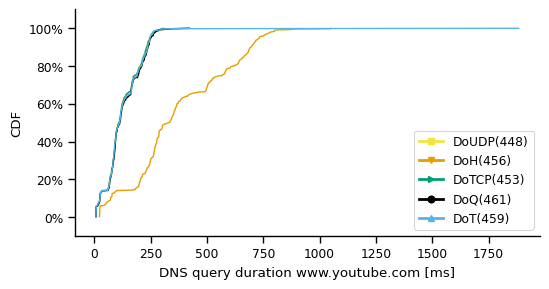

In [211]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_handshake_and_query_first['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=False
for col_val_ in legend_labels:
    for metric_type in df_handshake_and_query_first.metric_type.unique():
        if len(df_handshake_and_query_first[(df_handshake_and_query_first.protocol == col_val_) & (df_handshake_and_query_first.metric_type == metric_type)]['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_handshake_and_query_first[(df_handshake_and_query_first.protocol == col_val_) & (df_handshake_and_query_first.metric_type == metric_type)]['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_handshake_and_query_first[(df_handshake_and_query_first.protocol == col_val_) & (df_handshake_and_query_first.metric_type == metric_type)]['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_handshake_and_query_first[(df_handshake_and_query_first.protocol == col_val_) & (df_handshake_and_query_first.metric_type == metric_type)]['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('')

ax.set_xlabel('DNS query duration www.youtube.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

In [212]:
#df_handshake_and_query_first = df_handshake_and_query.loc[df_handshake_and_query.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)
df_query_googlevideo = df_handshake_and_query[~df_handshake_and_query.domain.isnull()]
df_query_googlevideo = df_query_googlevideo[df_query_googlevideo.domain.str.endswith('.googlevideo.com')]
df_query_googlevideo = df_query_googlevideo.loc[df_query_googlevideo.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)


DoUDP query
count    448.000000
mean     130.491040
std       77.236848
min        6.944607
10%       25.503366
20%       70.341968
25%       80.627783
30%       85.743400
40%       95.991552
50%      113.526599
60%      129.327823
70%      171.598510
75%      194.949129
80%      212.865180
90%      237.513557
100%     427.295144
max      427.295144
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     456.000000
mean      166.337676
std       161.816876
min         7.121783
10%        29.595095
20%        82.166472
25%        88.938574
30%        95.331294
40%       112.262981
50%       128.486445
60%       173.396747
70%       214.167396
75%       227.113314
80%       238.039420
90%       281.089193
100%     2254.563557
max      2254.563557
Name: duration, dtype: float64
DoTCP query
count    453.000000
mean     130.060320
std       79.137207
min        6.852053
10%       25.405580
20%       69.653129
25%       79.867601
30%       86.193337
40%       94.729003
50%

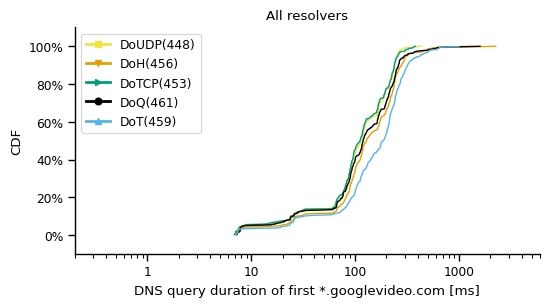

In [267]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_query_googlevideo['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_query_googlevideo.metric_type.unique():
        if len(df_query_googlevideo[(df_query_googlevideo.protocol == col_val_) & (df_query_googlevideo.metric_type == metric_type)]['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_query_googlevideo[(df_query_googlevideo.protocol == col_val_) & (df_query_googlevideo.metric_type == metric_type)]['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_query_googlevideo[(df_query_googlevideo.protocol == col_val_) & (df_query_googlevideo.metric_type == metric_type)]['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_query_googlevideo[(df_query_googlevideo.protocol == col_val_) & (df_query_googlevideo.metric_type == metric_type)]['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('All resolvers')

ax.set_xlabel('DNS query duration of first *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

DoUDP query
count    230.000000
mean     118.495005
std       78.776741
min        6.944607
10%       20.094472
20%       53.684449
25%       75.302980
30%       80.334245
40%       89.424450
50%       97.335930
60%      118.189995
70%      165.086182
75%      173.696847
80%      193.683514
90%      237.782374
100%     355.762058
max      355.762058
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     227.000000
mean      162.344922
std       200.783439
min         7.225185
10%        23.932900
20%        77.976091
25%        82.481215
30%        88.905055
40%       100.530885
50%       116.674372
60%       152.754163
70%       200.429348
75%       224.292746
80%       237.216223
90%       277.611130
100%     2254.563557
max      2254.563557
Name: duration, dtype: float64
DoTCP query
count    231.000000
mean     119.307822
std       79.692739
min        6.852053
10%       18.524900
20%       59.479456
25%       73.007262
30%       81.087350
40%       90.668231
50%

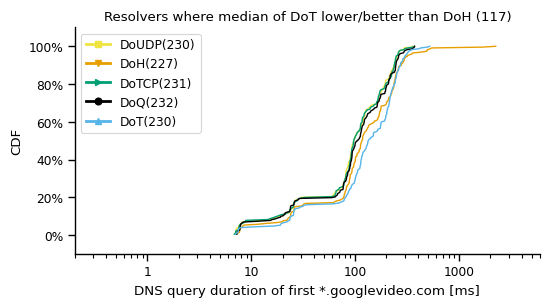

In [268]:
df_plt = pd.merge(df_query_googlevideo, measurements[['msm_id', 'server']], on='msm_id')
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_query_googlevideo['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type) & (df_plt.server.isin(dot_better))]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median of DoT lower/better than DoH ('+str(median_dot_better)+')')

ax.set_xlabel('DNS query duration of first *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

In [226]:
df_plt[(df_plt.protocol == 'DoT') & (df_plt.duration < 20)]

msm_id  \
216   184e3cc1-5d6d-769a-9956-92d142bb0d77   
220   18926527-b690-44d0-47b6-2515ee5a7ef3   
341   25d39e86-5ec5-9809-8d85-3c8ffa40216a   
566   3bf274a0-8e32-7d14-32b8-b41791d0ec1a   
571   3ccc78b1-a532-23c2-7e8f-33f2cb7b582d   
815   586cd5af-5c09-3f31-c09d-0cd893e97a77   
822   5944b505-7165-6e1b-322a-9c37de147a72   
847   5c15630a-cba5-ea97-c6e2-2e015d959409   
881   6019f322-594b-52a0-062a-4251af78c0f4   
955   6794d2c3-a675-3f4f-bb1a-91dde9d2b903   
1235  8ace187d-5db3-1706-1b83-438347203a68   
1312  923370f1-d534-3e74-eeae-a971f62d7aa5   
1320  92dd3ccf-393b-8810-58ea-bb49c524757c   
1377  9ad2a4e0-88a9-5217-354a-8e55a11db3c6   
1477  a6b5900e-96f0-b52c-effe-8afe7a1c93d6   
1548  ad170749-be67-dd5e-0a4c-174a96743a34   
1862  d25b0c26-0270-f4c6-35f4-8e5e6218f441   
1876  d3fd53bf-6789-7a00-1937-5a7467c44d7f   
2037  e54fd847-b37d-8fc4-41e2-7553ed46d66b   
2042  e59793cc-23ab-78ac-8be1-888dd24238aa   

                                                 metric metric_type  \
216   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
220   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
341   DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
566   DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
571   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
815   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
822   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
847   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
881   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
955   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1235  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1312  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1320  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1377  DoT query duration for [;redirector.googlevide...       query   
1477  DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
1548  DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
1862  DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
1876  DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
2037  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
2042  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   

       duration  base            metric_start              metric_end  \
216   16.447127   1.0 2022-05-03 00:08:28.974 2022-05-03 00:08:28.990   
220    7.393030   1.0 2022-05-03 11:40:13.465 2022-05-03 11:40:13.472   
341   19.154834   1.0 2022-05-03 08:35:54.149 2022-05-03 08:35:54.168   
566    7.156668   1.0 2022-05-03 11:38:05.263 2022-05-03 11:38:05.270   
571    7.812460   1.0 2022-05-03 04:57:48.394 2022-05-03 04:57:48.402   
815    7.152844   1.0 2022-05-03 10:39:48.567 2022-05-03 10:39:48.575   
822    7.544361   1.0 2022-05-03 13:29:40.176 2022-05-03 13:29:40.183   
847   19.051569   1.0 2022-05-03 08:33:44.995 2022-05-03 08:33:45.014   
881    7.042575   1.0 2022-05-02 21:39:50.229 2022-05-02 21:39:50.236   
955    7.178694   1.0 2022-05-02 23:56:09.853 2022-05-02 23:56:09.861   
1235  10.707201   1.0 2022-05-03 00:06:20.940 2022-05-03 00:06:20.951   
1312   7.649225   1.0 2022-05-03 10:37:39.446 2022-05-03 10:37:39.454   
1320   7.150467   1.0 2022-05-03 08:20:10.722 2022-05-03 08:20:10.729   
1377   7.510447   1.0 2022-05-03 13:31:46.458 2022-05-03 13:31:46.466   
1477  19.404625   1.0 2022-05-03 13:02:01.856 2022-05-03 13:02:01.876   
1548   7.382959   1.0 2022-05-03 05:02:06.105 2022-05-03 05:02:06.112   
1862   7.446688   1.0 2022-05-02 23:58:18.432 2022-05-02 23:58:18.439   
1876   7.475364   1.0 2022-05-03 08:22:19.847 2022-05-03 08:22:19.854   
2037   7.456816   1.0 2022-05-03 04:55:40.068 2022-05-03 04:55:40.075   
2042   7.479171   1.0 2022-05-02 21:37:42.087 2022-05-02 21:37:42.095   

     protocol                             d

In [228]:
df_plt[df_plt.server == '94.140.14.14']

msm_id  \
63    060c5398-4166-61f1-1d39-6ecabb03db0f   
220   18926527-b690-44d0-47b6-2515ee5a7ef3   
449   309a3c1c-7da8-735c-c9aa-6fe4a8168115   
566   3bf274a0-8e32-7d14-32b8-b41791d0ec1a   
577   3df85812-3e42-2b5c-33f2-e4f0720bee94   
965   687211a2-22b4-9048-7432-2f7429b2766e   
1484  a7132d67-a6de-9556-b671-c0ac0ff695ab   
1620  b60cb985-af05-fd72-583d-5736318e7c5a   
1891  d5e61e1d-dbeb-dfd8-a7e5-03b094a162e0   
2098  eb30f719-be53-f55f-29d3-a871bdb49d23   

                                                 metric  \
63    DoQ query duration for [;rr4---sn-p5qlsn76.goo...   
220   DoT query duration for [;rr4---sn-p5qlsn76.goo...   
449   DoTCP query duration for [;rr4---sn-p5qlsn76.g...   
566   DoT query duration for [;rr2---sn-p5qs7nel.goo...   
577   DoQ query duration for [;rr2---sn-p5qs7nel.goo...   
965   DoTCP query duration for [;rr2---sn-p5qs7nel.g...   
1484  DoUDP query duration for [;redirector.googlevi...   
1620  DoH query (and likely handshake) duration for ...   
1891  DoUDP query duration for [;rr4---sn-p5qlsn76.g...   
2098  DoH query (and likely handshake) duration for ...   

                        metric_type  duration  base            metric_start  \
63                            query  7.773085   1.0 2022-05-03 11:41:04.594   
220                           query  7.393030   1.0 2022-05-03 11:40:13.465   
449                           query  7.585058   1.0 2022-05-03 11:41:30.364   
566                           query  7.156668   1.0 2022-05-03 11:38:05.263   
577                           query  7.281385   1.0 2022-05-03 11:38:56.470   
965                           query  6.958356   1.0 2022-05-03 11:39:22.144   
1484                          query  6.955244   1.0 2022-05-03 11:39:45.923   
1620  lazy-init-handshake-and-query  7.371313   1.0 2022-05-03 11:38:31.026   
1891                          query  7.350096   1.0 2022-05-03 11:41:56.141   
2098  lazy-init-handshake-and-query  7.478714   1.0 2022-05-03 11:40:38.967   

                  metric_end protocol                             domain  \
63   2022-05-03 11:41:04.602      DoQ  rr4---sn-p5qlsn76.googlevideo.com   
220  2022-05-03 11:40:13.472      DoT  rr4---sn-p5qlsn76.googlevideo.com   
449  2022-05-03 11:41:30.371    DoTCP  rr4---sn-p5qlsn76.googlevideo.com   
566  2022-05-03 11:38:05.270      DoT  rr2---sn-p5qs7nel.googlevideo.com   
577  2022-05-03 11:38:56.477      DoQ  rr2---sn-p5qs7nel.googlevideo.com   
965  2022-05-03 11:39:22.151    DoTCP  rr2---sn-p5qs7nel.googlevideo.com   
1484 2022-05-03 11:39:45.930    DoUDP         redirector.googlevideo.com   
1620 2022-05-03 11:38:31.034      DoH  rr2---sn-p5qlsndd.googlevideo.com   
1891 2022-05-03 11:41:56.148    DoUDP  rr4---sn-p5qlsn76.googlevideo.com   
2098 2022-05-03 11:40:38.975      DoH  rr4---sn-p5qlsn76.googlevideo.com   

            server  
63    94.140.14.14  
220   94.140.14.14  
449   94.140.14.14  
566   94.140.14.14  
577   94.140.14.14  
965   94.140.14.14  
1484  94.140.14.14  
1620  94.140.14.14  
1891  94.140.14.14  
2098  94.140.14.14

In [222]:
measurements[measurements.msm_id == '5bafb965-fbfe-4282-df71-ee489633e05c']

msm_id              py_time       js_time  \
1257  5bafb965-fbfe-4282-df71-ee489633e05c  1651553614914227939  1.651554e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1257          1.651554e+12      DoT  23.239.29.136  lqiN98z6Dak      US East   

                      timestamp suggested_quality player_width player_height  \
1257 2022-05-03 04:53:25.894884              auto         1280           720   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1257           0          5  lqiN98z6Dak             0                1280x720

In [269]:
df_plt[(df_plt.protocol == 'DoH') & (df_plt.duration < 120) & (df_plt.duration > 110)]

msm_id  \
81    08970fe1-24e9-5c20-ff8d-67e23ecdd6f8   
276   1f24cb8a-65c0-c7d8-ff4e-42010e0d4a10   
351   26da5c98-5794-6edc-559b-b8169cd9fc2d   
354   2722dca3-3c88-ab4e-5b91-2dc47888cfaa   
487   34e7573e-0aa3-109c-1172-0f959b063452   
561   3b92dd8e-11e1-97a1-fb2d-80a4d26749b3   
803   56784aff-0828-03ff-0fa3-4be558e44726   
813   57f039e5-65b5-fe3d-906f-a073fccb2062   
878   5fe4450d-fc69-b9fc-01c8-1fbf5e0fd984   
882   6023a214-ac2d-26f2-c428-858930bd0cb9   
930   64acdefd-d63a-55e4-862d-ca35caa0e6fe   
1065  764ca4e6-c65e-815e-0695-cb73fc6ef0b1   
1084  78e68e0e-1c77-9dba-10df-d02a677040a6   
1142  80536099-4bc0-25c9-f606-52617eb0cbf0   
1191  8660b9f7-a096-24dc-1f04-794115945ba4   
1219  8984bf34-f170-fcb8-0317-e273900094a9   
1238  8aff506e-af76-0229-f86a-aa97782b8c9f   
1265  8db133cb-506d-c6f7-dfb0-d312a6a16303   
1334  9527763a-8ffd-5d63-3421-3afe29638132   
1464  a5126f2b-18d0-12de-b809-4279046c0bec   
1523  aa7aa6f2-a949-1075-f806-42641a5b2015   
1529  ab49ac76-adf7-f2a1-4b41-e8ec808bf324   
1561  ae8c34a6-eed1-e34a-d157-88c605b97f4d   
1619  b5f70d5d-fcf9-6048-2cfa-822c2354f201   
1649  ba68ccab-d809-7809-fcfe-0fed442e98c8   
1662  bbe9beb9-5fd5-8638-07fd-d0918f18dffa   
1685  be467abf-d11d-9433-1fc5-2eef4bc69a09   
1749  c49bcb02-0643-6620-5d33-a45beaa29969   
1767  c6b06f27-2f8c-95b3-813f-9a0dff5d2370   
1857  d1e21386-369a-8e35-7879-f122528e1407   
1938  db5e397b-f221-1bcc-8781-d1ee28d75bbe   
2010  e29835da-f207-dea9-bc31-ac1b7277181e   
2036  e54f99c8-26bf-66fc-a1fb-f84ba5d97dd4   
2140  f0c6b167-3f8a-80f9-2ef0-67f337b309a0   
2147  f1ae0515-fe84-42cd-9e5e-40ffab7fa5ad   
2268  fe8b6b68-c1fe-a90b-a9ea-b1289611256b   

                                                 metric  \
81    DoH query (and likely handshake) duration for ...   
276   DoH query (and likely handshake) duration for ...   
351   DoH query (and likely handshake) duration for ...   
354   DoH query (and likely handshake) duration for ...   
487   DoH query (and likely handshake) duration for ...   
561   DoH query (and likely handshake) duration for ...   
803   DoH query (and likely handshake) duration for ...   
813   DoH query (and likely handshake) duration for ...   
878   DoH query (and likely handshake) duration for ...   
882   DoH query (and likely handshake) duration for ...   
930   DoH query (and likely handshake) duration for ...   
1065  DoH query (and likely handshake) duration for ...   
1084  DoH query (and likely handshake) duration for ...   
1142  DoH query (and likely handshake) duration for ...   
1191  DoH query (and likely handshake) duration for ...   
1219  DoH query (and likely handshake) duration for ...   
1238  DoH query (and likely handshake) duration for ...   
1265  DoH query (and likely handshake) duration for ...   
1334  DoH query (and likely handshake) duration for ...   
1464  DoH query (and likely handshake) duration for ...   
1523  DoH query (and likely handshake) duration for ...   
1529  DoH query (and likely handshake) duration for ...   
1561  DoH query (and likely handshake) duration for ...   
1619  DoH query (and likely handshake) duration for ...   
1649  DoH query (and likely handshake) duration for ...   
1662  DoH query (and likely handshake) duration for ...   
1685  DoH query (and likely handshake) duration for ...   
1749  DoH query (and likely handshake) duration for ...   
1767  DoH query (and likely handshake) duration for ...   
1857  DoH query (and likely handshake) duration for ...   
1938  DoH query (and likely handshake) duration for ...   
2010  DoH query (and likely handshake) duration for ...   
2036  DoH query (and likely handshake) duration for ...   
2140  DoH query (and likely handshake) duration for ...   
2147  DoH query (and likely handshake) duration for ...   
2268  DoH query (and likely handshake) duration for ...   

                        metric_type    duration  base            metric_start  \
81    lazy-init-handshake-and-query  112.935036   1.0 2022-05-02 21:

In [270]:
df_plt[df_plt.server == '188.68.59.46']

msm_id  \
214   181a3ddc-2dd8-5e78-9166-818355ffed31   
664   47676edc-cd34-f349-b203-64f2fb16ec00   
673   48b627a7-ae88-fa46-5da9-b7b255268514   
710   4c711ba1-7050-be6b-24b1-2fe974837d75   
1072  778e45e6-66ae-5a22-2ce2-7ec236b41328   
1584  b1008757-446c-f55f-67ce-55e1b9c664d7   
1938  db5e397b-f221-1bcc-8781-d1ee28d75bbe   
2031  e50a8617-cf71-e431-ec47-2d0ae696a8dc   
2036  e54f99c8-26bf-66fc-a1fb-f84ba5d97dd4   
2085  ea28959b-e801-4f9f-9e0f-34bef06f3fac   

                                                 metric  \
214   DoTCP query duration for [;rr4---sn-p5qs7nsr.g...   
664   DoT query duration for [;rr4---sn-p5qs7nsr.goo...   
673   DoUDP query duration for [;rr4---sn-p5qlsn76.g...   
710   DoQ query duration for [;rr2---sn-p5qs7nel.goo...   
1072  DoTCP query duration for [;rr2---sn-p5qlsndd.g...   
1584  DoUDP query duration for [;rr2---sn-p5qlsndd.g...   
1938  DoH query (and likely handshake) duration for ...   
2031  DoT query duration for [;rr2---sn-p5qs7nel.goo...   
2036  DoH query (and likely handshake) duration for ...   
2085  DoQ query duration for [;rr4---sn-p5qs7nsr.goo...   

                        metric_type    duration  base            metric_start  \
214                           query  112.141772   1.0 2022-05-03 06:29:34.852   
664                           query  148.409152   1.0 2022-05-03 06:28:08.551   
673                           query  146.384855   1.0 2022-05-03 06:30:03.595   
710                           query  124.400643   1.0 2022-05-03 06:26:42.583   
1072                          query  144.221679   1.0 2022-05-03 06:27:11.679   
1584                          query  116.999880   1.0 2022-05-03 06:27:39.920   
1938  lazy-init-handshake-and-query  116.414187   1.0 2022-05-03 06:28:37.175   
2031                          query  144.822491   1.0 2022-05-03 06:25:44.105   
2036  lazy-init-handshake-and-query  116.295392   1.0 2022-05-03 06:26:12.867   
2085                          query  115.866612   1.0 2022-05-03 06:29:06.084   

                  metric_end protocol                             domain  \
214  2022-05-03 06:29:34.964    DoTCP  rr4---sn-p5qs7nsr.googlevideo.com   
664  2022-05-03 06:28:08.699      DoT  rr4---sn-p5qs7nsr.googlevideo.com   
673  2022-05-03 06:30:03.741    DoUDP  rr4---sn-p5qlsn76.googlevideo.com   
710  2022-05-03 06:26:42.708      DoQ  rr2---sn-p5qs7nel.googlevideo.com   
1072 2022-05-03 06:27:11.823    DoTCP  rr2---sn-p5qlsndd.googlevideo.com   
1584 2022-05-03 06:27:40.037    DoUDP  rr2---sn-p5qlsndd.googlevideo.com   
1938 2022-05-03 06:28:37.291      DoH  rr4---sn-p5qs7nsr.googlevideo.com   
2031 2022-05-03 06:25:44.250      DoT  rr2---sn-p5qs7nel.googlevideo.com   
2036 2022-05-03 06:26:12.984      DoH  rr2---sn-p5qs7nel.googlevideo.com   
2085 2022-05-03 06:29:06.200      DoQ  rr4---sn-p5qs7nsr.googlevideo.com   

            server  
214   188.68.59.46  
664   188.68.59.46  
673   188.68.59.46  
710   188.68.59.46  
1072  188.68.59.46  
1584  188.68.59.46  
1938  188.68.59.46  
2031  188.68.59.46  
2036  188.68.59.46  
2085  188.68.59.46

In [271]:
df_plt[df_plt.server == '23.239.29.136']

msm_id  \
255   1ca38fd1-3651-0e5b-829b-38864deba365   
409   2cb9f577-2012-09aa-968d-64038be8fb27   
631   42c2f7d6-582b-bb72-98f2-d0a9a0fe623a   
843   5bafb965-fbfe-4282-df71-ee489633e05c   
971   69394017-bbd0-d3be-216d-e9f85a0ad8b5   
1189  864024a9-3232-9c7e-d22e-ea0847e41e39   
1259  8d466fad-64ae-6734-8c31-c474d8d14368   
1492  a7661847-9538-a0c6-abc1-0e92ba7b2c3e   
1526  aaef174e-ddbe-13e7-d4ba-9966201bbc31   
1929  dac5dd02-3894-a941-32f4-2e48a6b5cd39   

                                                 metric  \
255   DoQ query duration for [;rr4---sn-p5qlsn76.goo...   
409   DoTCP query duration for [;rr2---sn-p5qlsndd.g...   
631   DoUDP query duration for [;rr2---sn-p5qlsndd.g...   
843   DoT query duration for [;rr4---sn-p5qlsn76.goo...   
971   DoUDP query duration for [;rr4---sn-p5qs7nsr.g...   
1189  DoQ query duration for [;rr2---sn-p5qlsndd.goo...   
1259  DoTCP query duration for [;rr4---sn-p5qs7nsr.g...   
1492  DoH query (and likely handshake) duration for ...   
1526  DoH query (and likely handshake) duration for ...   
1929  DoT query duration for [;rr2---sn-p5qlsndd.goo...   

                        metric_type   duration  base            metric_start  \
255                           query  32.862654   1.0 2022-05-03 04:54:21.411   
409                           query  32.248772   1.0 2022-05-03 04:52:35.872   
631                           query  32.312427   1.0 2022-05-03 04:53:02.210   
843                           query  57.951071   1.0 2022-05-03 04:53:28.704   
971                           query  32.123862   1.0 2022-05-03 04:55:14.244   
1189                          query  32.451772   1.0 2022-05-03 04:52:09.475   
1259                          query  57.628160   1.0 2022-05-03 04:54:47.958   
1492  lazy-init-handshake-and-query  40.693033   1.0 2022-05-03 04:51:43.127   
1526  lazy-init-handshake-and-query  32.725517   1.0 2022-05-03 04:53:54.854   
1929                          query  39.912853   1.0 2022-05-03 04:51:16.864   

                  metric_end protocol                             domain  \
255  2022-05-03 04:54:21.443      DoQ  rr4---sn-p5qlsn76.googlevideo.com   
409  2022-05-03 04:52:35.904    DoTCP  rr2---sn-p5qlsndd.googlevideo.com   
631  2022-05-03 04:53:02.242    DoUDP  rr2---sn-p5qlsndd.googlevideo.com   
843  2022-05-03 04:53:28.762      DoT  rr4---sn-p5qlsn76.googlevideo.com   
971  2022-05-03 04:55:14.276    DoUDP  rr4---sn-p5qs7nsr.googlevideo.com   
1189 2022-05-03 04:52:09.507      DoQ  rr2---sn-p5qlsndd.googlevideo.com   
1259 2022-05-03 04:54:48.016    DoTCP  rr4---sn-p5qs7nsr.googlevideo.com   
1492 2022-05-03 04:51:43.168      DoH  rr2---sn-p5qs7nel.googlevideo.com   
1526 2022-05-03 04:53:54.886      DoH  rr4---sn-p5qlsn76.googlevideo.com   
1929 2022-05-03 04:51:16.904      DoT  rr2---sn-p5qlsndd.googlevideo.com   

             server  
255   23.239.29.136  
409   23.239.29.136  
631   23.239.29.136  
843   23.239.29.136  
971   23.239.29.136  
1189  23.239.29.136  
1259  23.239.29.136  
1492  23.239.29.136  
1526  23.239.29.136  
1929  23.239.29.136

In [224]:
measurements[measurements.server == '23.239.29.136']

msm_id              py_time       js_time  \
1252  dac5dd02-3894-a941-32f4-2e48a6b5cd39  1651553483165959338  1.651553e+12   
1253  a7661847-9538-a0c6-abc1-0e92ba7b2c3e  1651553509418997425  1.651554e+12   
1254  864024a9-3232-9c7e-d22e-ea0847e41e39  1651553535668786510  1.651554e+12   
1255  2cb9f577-2012-09aa-968d-64038be8fb27  1651553562157966596  1.651554e+12   
1256  42c2f7d6-582b-bb72-98f2-d0a9a0fe623a  1651553588595917634  1.651554e+12   
1257  5bafb965-fbfe-4282-df71-ee489633e05c  1651553614914227939  1.651554e+12   
1258  aaef174e-ddbe-13e7-d4ba-9966201bbc31  1651553641179639361  1.651554e+12   
1259  1ca38fd1-3651-0e5b-829b-38864deba365  1651553667763597639  1.651554e+12   
1260  8d466fad-64ae-6734-8c31-c474d8d14368  1651553694216961002  1.651554e+12   
1261  69394017-bbd0-d3be-216d-e9f85a0ad8b5  1651553720692354587  1.651554e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1252          1.651553e+12      DoT  23.239.29.136  aqz-KE-bpKQ      US East   
1253          1.651554e+12      DoH  23.239.29.136  aqz-KE-bpKQ      US East   
1254          1.651554e+12      DoQ  23.239.29.136  aqz-KE-bpKQ      US East   
1255          1.651554e+12    DoTCP  23.239.29.136  aqz-KE-bpKQ      US East   
1256          1.651554e+12    DoUDP  23.239.29.136  aqz-KE-bpKQ      US East   
1257          1.651554e+12      DoT  23.239.29.136  lqiN98z6Dak      US East   
1258          1.651554e+12      DoH  23.239.29.136  lqiN98z6Dak      US East   
1259          1.651554e+12      DoQ  23.239.29.136  lqiN98z6Dak      US East   
1260          1.651554e+12    DoTCP  23.239.29.136  lqiN98z6Dak      US East   
1261          1.651554e+12    DoUDP  23.239.29.136  lqiN98z6Dak      US East   

                      timestamp suggested_quality player_width player_height  \
1252 2022-05-03 04:51:14.100779              auto         1280           720   
1253 2022-05-03 04:51:40.337638              auto         1280           720   
1254 2022-05-03 04:52:06.703193              auto         1280           720   
1255 2022-05-03 04:52:32.940765              auto         1280           720   
1256 2022-05-03 04:52:59.480486              auto         1280           720   
1257 2022-05-03 04:53:25.894884              auto         1280           720   
1258 2022-05-03 04:53:52.105573              auto         1280           720   
1259 2022-05-03 04:54:18.651018              auto         1280           720   
1260 2022-05-03 04:54:45.053619              auto         1280           720   
1261 2022-05-03 04:55:11.457751              auto         1280           720   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1252           0          5  aqz-KE-bpKQ             0                1280x720  
1253           0          5  aqz-KE-bpKQ             0                1280x720  
1254           0          5  aqz-KE-bpKQ             0                1280x720  
1255           0          5  aqz-KE-bpKQ             0                1280x720  
1256           0          5  aqz-KE-bpKQ             0                1280x720  
1257           0          5  lqiN98z6Dak             0                1280x720  
1258           0          5  lqiN98z6Dak             0                1280x720  
1259           0          5  lqiN98z6Dak             0                1280x720  
1260           0          5  lqiN98z6Dak             0                1280x720  
1261           0          5  lqiN98z6Dak             0                1280x720

In [225]:
df_plt[df_plt.msm_id == 'aaef174e-ddbe-13e7-d4ba-9966201bbc31']

msm_id  \
1526  aaef174e-ddbe-13e7-d4ba-9966201bbc31   

                                                 metric  \
1526  DoH query (and likely handshake) duration for ...   

                        metric_type   duration  base            metric_start  \
1526  lazy-init-handshake-and-query  32.725517   1.0 2022-05-03 04:53:54.854   

                  metric_end protocol                             domain  \
1526 2022-05-03 04:53:54.886      DoH  rr4---sn-p5qlsn76.googlevideo.com   

             server  
1526  23.239.29.136

In [221]:
df_plt[(df_plt.protocol == 'DoH') & (df_plt.duration < 60) & (df_plt.duration > 40)]

msm_id  \
1492  a7661847-9538-a0c6-abc1-0e92ba7b2c3e   

                                                 metric  \
1492  DoH query (and likely handshake) duration for ...   

                        metric_type   duration  base            metric_start  \
1492  lazy-init-handshake-and-query  40.693033   1.0 2022-05-03 04:51:43.127   

                  metric_end protocol                             domain  \
1492 2022-05-03 04:51:43.168      DoH  rr2---sn-p5qs7nel.googlevideo.com   

             server  
1492  23.239.29.136

In [223]:
measurements[measurements.msm_id == 'a7661847-9538-a0c6-abc1-0e92ba7b2c3e']

msm_id              py_time       js_time  \
1253  a7661847-9538-a0c6-abc1-0e92ba7b2c3e  1651553509418997425  1.651554e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1253          1.651554e+12      DoH  23.239.29.136  aqz-KE-bpKQ      US East   

                      timestamp suggested_quality player_width player_height  \
1253 2022-05-03 04:51:40.337638              auto         1280           720   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1253           0          5  aqz-KE-bpKQ             0                1280x720

DoUDP query
count    242.000000
mean     141.932770
std       75.454221
min        6.955244
10%       64.368967
20%       79.403278
25%       84.116252
30%       91.122609
40%      106.429429
50%      120.936259
60%      165.718252
70%      193.286495
75%      201.725913
80%      217.588088
90%      236.825905
100%     427.295144
max      427.295144
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    253.000000
mean     168.667458
std      109.633526
min        7.121783
10%       67.164974
20%       86.735090
25%       92.518410
30%       99.642012
40%      116.836825
50%      145.250343
60%      194.646979
70%      217.592342
75%      229.220868
80%      239.729987
90%      282.543755
100%     997.783928
max      997.783928
Name: duration, dtype: float64
DoTCP query
count    246.000000
mean     141.653382
std       79.844106
min        6.896840
10%       64.187182
20%       76.765592
25%       82.385857
30%       87.359771
40%       99.696402
50%      119.578701


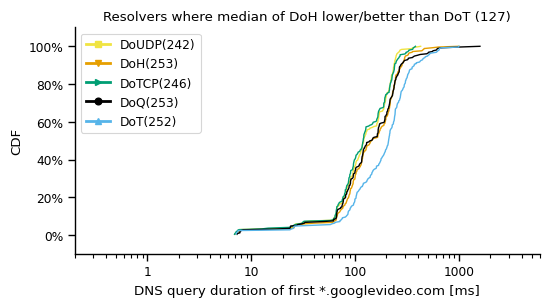

In [229]:
df_plt = pd.merge(df_query_googlevideo, measurements[['msm_id', 'server']], on='msm_id')
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_query_googlevideo['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type) & (df_plt.server.isin(doh_better))]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median of DoH lower/better than DoT ('+str(median_doh_better)+')')

ax.set_xlabel('DNS query duration of first *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

In [240]:
df_plt[(df_plt.duration > 80) & (df_plt.duration < 100) & (df_plt.protocol == 'DoT')].sort_values('duration')

msm_id  \
681   4943221d-a7a6-d0ef-fa70-d922878fcc11   
1976  df44343d-b272-2e72-87a8-0fdddeba24e2   
529   382c85f6-90a3-71cd-12df-c13e4adf7985   
20    0225e738-2690-7800-c064-6aaaf988e53f   
148   10ce8fdc-8425-99ab-edf8-6558c38a5cd0   
1751  c4dd9787-b53e-3bac-f808-7fb1b357c5f8   
857   5d2e6cc2-256c-fbd1-e72a-586cbc0996d7   
556   3af5625b-fc5c-fe91-8d62-5ea9b34fe702   
1060  75a62e7c-059c-d043-9836-49dcbd7045bf   
2240  fbd05024-fe61-094e-39b8-e239dcecc592   
169   133db752-9edb-1d46-7f31-3260fdf11e7a   
817   58aafdbe-40ff-76a8-f77b-20a752670a09   
1977  df558678-92ed-61e3-d6b4-2a66752ecdb3   
1661  bbe55ddf-f98c-7743-4755-5c5e25be0054   
703   4bc30b71-0367-9595-bd56-27656fe715e1   
1203  87757bc0-6c64-5c3c-d9a2-662e65a43980   
1950  dc8894eb-f1ad-03e8-e610-5d7550a98518   
1293  90798669-7c44-914b-b845-0e8d84e43a73   
1722  c1fe9a10-be7f-0172-0c80-816bef720a71   
1144  807a8a99-c6bf-f529-6c3d-96e90836767e   
1077  783db98a-5314-99ad-87fe-e5cf6649344d   
405   2c45f0c1-c36a-6608-48f0-2218af21df17   
175   13cae0d0-0d07-961d-1cac-6fb4fb764dfc   
370   28507f2a-8f13-afa8-3474-64de60d79d1c   
61    0605147e-13f0-1cbe-dabb-60b31a5d4142   
1315  927407a8-1e90-23d7-7d2c-edd541b68599   
477   33c135c8-8762-1164-ea4b-3d5a0d83c291   
160   12329051-3e0a-f6a9-08c0-6e7196051ce3   
1363  9947956c-7184-65d2-29cb-76cab2e38a52   
1412  9e92dfb7-404f-8ade-eef9-89e9b5f5d9ef   
1890  d5ad3ece-b0ff-7444-214d-4f396c7cc2d8   
1181  852f0eaf-ca49-1206-12dc-bf8c24237e48   
977   6a461b55-5edd-f9d9-5d01-3465ed6e51d2   
593   3fa662bc-c887-29a0-2680-6dd79db01ebf   
121   0dec1b95-e8fe-a3b5-58ee-0b843d6de1d5   
1342  96232d14-53fd-c31b-c7e2-95c82715807f   
1834  cf3ddd54-2e7d-d762-f1a1-fa9581d94522   
543   3a1ac35f-2192-d592-3946-d5b329e8ff2e   
547   3a470080-d298-c778-73b5-34043607f12a   

                                                 metric metric_type  \
681   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
1976  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
529   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
20    DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
148   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1751  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
857   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
556   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1060  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
2240  DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
169   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
817   DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
1977  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1661  DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
703   DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1203  DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
1950  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1293  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1722  DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
1144  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1077  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
405   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
175   DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
370   DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
61    DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
1315  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
477   DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
160   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1363  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1412  DoT query duration for [;rr2---sn-p5qs7nel.goo...       que

In [244]:
df_plt[df_plt.server == '176.103.134.5']

msm_id  \
140   0fc95fa5-23ac-20f3-590f-376a36637c2d   
229   19757c0c-b4f4-d2fb-3f08-4cc8e80216fd   
263   1dac5a64-4433-0940-e949-6d47219518a9   
421   2e53d10a-9b99-683a-54ca-fa1388896546   
628   4275a159-386e-ec66-cf2b-5519978ea807   
1326  93c8ea55-6c81-4b0f-5b71-c4eab3ec4ce0   
1363  9947956c-7184-65d2-29cb-76cab2e38a52   
1465  a5262391-4557-88f4-3ff3-128ad64d3cb4   
1755  c536a488-8cff-2dd9-69b6-2773f847e451   
1987  e0aa012a-423c-2309-551c-2def0f1a5b58   

                                                 metric  \
140   DoTCP query duration for [;rr2---sn-p5qlsndd.g...   
229   DoQ query duration for [;rr4---sn-p5qlsn76.goo...   
263   DoH query (and likely handshake) duration for ...   
421   DoT query duration for [;rr4---sn-p5qs7nsr.goo...   
628   DoQ query duration for [;rr2---sn-p5qlsndd.goo...   
1326  DoUDP query duration for [;rr2---sn-p5qs7nel.g...   
1363  DoT query duration for [;rr2---sn-p5qlsndd.goo...   
1465  DoUDP query duration for [;rr4---sn-p5qlsn76.g...   
1755  DoH query (and likely handshake) duration for ...   
1987  DoTCP query duration for [;rr4---sn-p5qlsn76.g...   

                        metric_type    duration  base            metric_start  \
140                           query  106.670101   1.0 2022-05-03 10:00:56.888   
229                           query   95.699398   1.0 2022-05-03 10:02:42.115   
263   lazy-init-handshake-and-query   96.441297   1.0 2022-05-03 10:02:15.729   
421                           query  108.872696   1.0 2022-05-03 10:01:49.569   
628                           query   99.534657   1.0 2022-05-03 10:00:30.473   
1326                          query  106.815540   1.0 2022-05-03 10:01:22.839   
1363                          query   96.203807   1.0 2022-05-03 09:59:37.340   
1465                          query   96.023404   1.0 2022-05-03 10:03:35.563   
1755  lazy-init-handshake-and-query   96.782629   1.0 2022-05-03 10:00:04.278   
1987                          query   96.421232   1.0 2022-05-03 10:03:09.406   

                  metric_end protocol                             domain  \
140  2022-05-03 10:00:56.995    DoTCP  rr2---sn-p5qlsndd.googlevideo.com   
229  2022-05-03 10:02:42.211      DoQ  rr4---sn-p5qlsn76.googlevideo.com   
263  2022-05-03 10:02:15.826      DoH  rr4---sn-p5qlsn76.googlevideo.com   
421  2022-05-03 10:01:49.678      DoT  rr4---sn-p5qs7nsr.googlevideo.com   
628  2022-05-03 10:00:30.573      DoQ  rr2---sn-p5qlsndd.googlevideo.com   
1326 2022-05-03 10:01:22.946    DoUDP  rr2---sn-p5qs7nel.googlevideo.com   
1363 2022-05-03 09:59:37.436      DoT  rr2---sn-p5qlsndd.googlevideo.com   
1465 2022-05-03 10:03:35.659    DoUDP  rr4---sn-p5qlsn76.googlevideo.com   
1755 2022-05-03 10:00:04.375      DoH  rr2---sn-p5qlsndd.googlevideo.com   
1987 2022-05-03 10:03:09.502    DoTCP  rr4---sn-p5qlsn76.googlevideo.com   

             server  
140   176.103.134.5  
229   176.103.134.5  
263   176.103.134.5  
421   176.103.134.5  
628   176.103.134.5  
1326  176.103.134.5  
1363  176.103.134.5  
1465  176.103.134.5  
1755  176.103.134.5  
1987  176.103.134.5

In [245]:
#df_handshake_and_query_first = df_handshake_and_query.loc[df_handshake_and_query.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)
df_query_ytimg = df_handshake_and_query[~df_handshake_and_query.domain.isnull()]
df_query_ytimg = df_query_ytimg[df_query_ytimg.domain == 'i.ytimg.com']
df_query_ytimg = df_query_ytimg.loc[df_query_ytimg.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)


DoUDP query
count    448.000000
mean     125.554151
std       75.101325
min        6.948459
10%       24.127471
20%       67.834707
25%       77.981502
30%       84.006153
40%       92.929614
50%      106.944043
60%      122.993899
70%      166.286171
75%      188.352917
80%      204.335436
90%      235.466455
100%     362.803024
max      362.803024
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     456.000000
mean      138.273531
std       148.785452
min         7.086147
10%        25.157925
20%        68.532186
25%        78.801783
30%        85.907713
40%        95.229334
50%       114.124369
60%       132.276593
70%       172.107635
75%       193.212135
80%       211.121991
90%       236.696098
100%     2650.274974
max      2650.274974
Name: duration, dtype: float64
DoTCP query
count    453.000000
mean     127.484630
std       79.722449
min        6.861511
10%       25.473004
20%       68.850613
25%       80.727193
30%       86.155935
40%       94.345855
50%

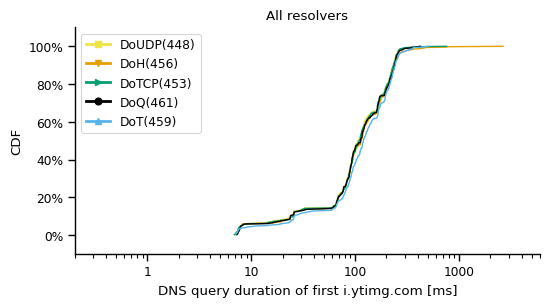

In [246]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_query_ytimg['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_query_ytimg.metric_type.unique():
        if len(df_query_ytimg[(df_query_ytimg.protocol == col_val_) & (df_query_ytimg.metric_type == metric_type)]['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_query_ytimg[(df_query_ytimg.protocol == col_val_) & (df_query_ytimg.metric_type == metric_type)]['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_query_ytimg[(df_query_ytimg.protocol == col_val_) & (df_query_ytimg.metric_type == metric_type)]['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_query_ytimg[(df_query_ytimg.protocol == col_val_) & (df_query_ytimg.metric_type == metric_type)]['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('All resolvers')

ax.set_xlabel('DNS query duration of first i.ytimg.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

DoUDP query
count    206.000000
mean     114.574812
std       76.894424
min        7.001907
10%       15.209416
20%       28.691745
25%       68.225666
30%       80.445504
40%       90.836931
50%       95.491260
60%      115.340970
70%      142.397704
75%      165.806332
80%      178.208203
90%      235.978038
100%     338.096262
max      338.096262
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     203.000000
mean      132.622938
std       203.445277
min         7.123831
10%        15.372153
20%        26.239594
25%        68.442924
30%        79.868580
40%        89.814270
50%        98.015784
60%       120.565115
70%       158.572124
75%       170.125013
80%       178.403566
90%       237.793332
100%     2650.274974
max      2650.274974
Name: duration, dtype: float64
DoTCP query
count    207.000000
mean     115.064168
std       75.587122
min        6.861511
10%       15.810063
20%       29.309854
25%       68.854007
30%       80.892521
40%       90.275119
50%

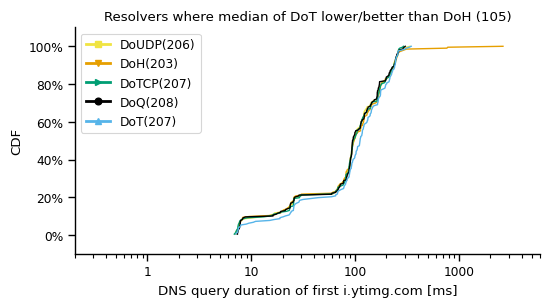

In [247]:
df_plt = pd.merge(df_query_ytimg, measurements[['msm_id', 'server']], on='msm_id')
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type) & (df_plt.server.isin(dot_better))]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median of DoT lower/better than DoH ('+str(median_dot_better)+')')

ax.set_xlabel('DNS query duration of first i.ytimg.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

DoUDP query
count    242.000000
mean     134.900200
std       72.394963
min        6.948459
10%       64.141555
20%       76.647333
25%       82.918656
30%       86.514287
40%       98.433168
50%      117.453477
60%      137.056890
70%      188.363974
75%      198.627526
80%      213.230852
90%      233.718267
100%     362.803024
max      362.803024
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    253.000000
mean     142.807407
std       82.132466
min        7.086147
10%       65.383674
20%       77.128219
25%       83.743040
30%       88.727658
40%      101.396663
50%      119.792296
60%      163.943073
70%      193.691575
75%      203.061104
80%      217.156850
90%      235.856239
100%     471.456694
max      471.456694
Name: duration, dtype: float64
DoTCP query
count    246.000000
mean     137.935995
std       81.741130
min        7.145627
10%       64.828934
20%       76.049906
25%       82.932121
30%       88.472061
40%      101.515766
50%      115.768922


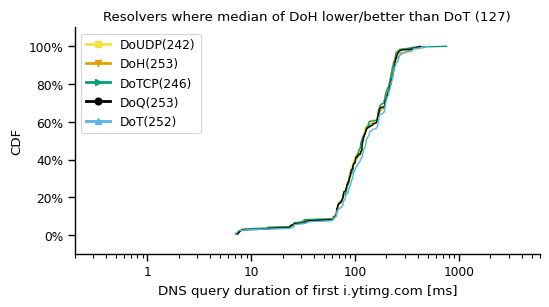

In [248]:
df_plt = pd.merge(df_query_ytimg, measurements[['msm_id', 'server']], on='msm_id')
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type) & (df_plt.server.isin(doh_better))]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median of DoH lower/better than DoT ('+str(median_doh_better)+')')

ax.set_xlabel('DNS query duration of first i.ytimg.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

In [250]:
#df_handshake_and_query_first = df_handshake_and_query.loc[df_handshake_and_query.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)
df_exchange = df_dns_perf_metrics[df_dns_perf_metrics.metric_type == 'exchange'].copy()
df_exchange_googlevideo = df_exchange[df_exchange.domain.str.endswith('.googlevideo.com')]
df_exchange_googlevideo = df_exchange_googlevideo.loc[df_exchange_googlevideo.groupby('msm_id').metric_start.idxmin()].reset_index(drop=True)


DoUDP exchange
count    448.000000
mean     130.907100
std       77.157330
min        7.218815
10%       25.883096
20%       70.669397
25%       80.924989
30%       86.059140
40%       96.271358
50%      114.099294
60%      129.594373
70%      171.918673
75%      195.211077
80%      213.292420
90%      237.792294
100%     427.590893
max      427.590893
Name: duration, dtype: float64
DoH exchange
count     456.000000
mean      166.676821
std       161.791494
min         7.363285
10%        29.867719
20%        82.515702
25%        89.235325
30%        95.600683
40%       112.515106
50%       128.757624
60%       173.647985
70%       214.446537
75%       227.353023
80%       238.300698
90%       281.382098
100%     2254.806981
max      2254.806981
Name: duration, dtype: float64
DoTCP exchange
count    453.000000
mean     252.510437
std      147.593305
min       14.402687
10%       50.800457
20%      139.483666
25%      159.041051
30%      169.696225
40%      189.341100
50%      222.46030

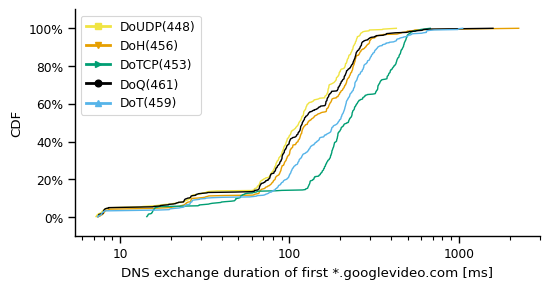

In [251]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_exchange_googlevideo['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_exchange_googlevideo.metric_type.unique():
        if len(df_exchange_googlevideo[(df_exchange_googlevideo.protocol == col_val_) & (df_exchange_googlevideo.metric_type == metric_type)]['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_exchange_googlevideo[(df_exchange_googlevideo.protocol == col_val_) & (df_exchange_googlevideo.metric_type == metric_type)]['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_exchange_googlevideo[(df_exchange_googlevideo.protocol == col_val_) & (df_exchange_googlevideo.metric_type == metric_type)]['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_exchange_googlevideo[(df_exchange_googlevideo.protocol == col_val_) & (df_exchange_googlevideo.metric_type == metric_type)]['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('')

ax.set_xlabel('DNS exchange duration of first *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

plt.show()

In [724]:
df_start_time['startup_delay_ms'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds() * 1e3

In [740]:
#takes ages to run
for index, row in df_start_time.iterrows():
    df_tmp = df_exchange[df_exchange.msm_id == row['msm_id']]
    for domain in df_tmp[(df_tmp.metric_start > row['start_time']) & (df_tmp.metric_end < row['play_time'])].domain.unique():
        if "googlevideo.com" not in domain:
            print(row['msm_id'] + " " +domain)

e1a5c87b-f01e-f607-bd36-4e2f6c3e4387 i.ytimg.com
d6bc9dac-7af8-983c-a78e-ab4a88cfbec5 i.ytimg.com
ea1255a1-5c83-3ec7-5051-0050f9b55d14 i.ytimg.com
a4647789-96b6-4790-63d7-e32ad4bc3ea4 i.ytimg.com
445d3e0c-2584-b29e-9626-0eaa07e0837d i.ytimg.com
34729d6c-0274-af89-6efe-3bb2bac7db9b i.ytimg.com
932d1979-bf5a-6373-ed5a-ed3bfcd2328b i.ytimg.com
93e88ed5-1e00-9e8c-03a6-8e9742831a73 i.ytimg.com
1a830ae1-25f9-f9f1-ef34-f614a65ebb75 yt3.ggpht.com
f67b2137-51d8-29a6-531d-913c705e4edf yt3.ggpht.com
951d4570-addf-c1dd-bd54-55ed9c541d0f i.ytimg.com
1d4ae8b0-6393-c680-4406-492c661c257b i.ytimg.com
ee925d49-4cde-4269-bdfc-7b94328f87a4 i.ytimg.com
c4fad980-0f13-1705-e789-182de5fe4a95 i.ytimg.com
fdb50a91-e1cb-3e41-5a7c-05fe996bfd39 i.ytimg.com
f420cc2c-b020-5ca5-c3fe-357aed3e4756 i.ytimg.com
7c08dfb7-8c3e-94da-7fd5-b481f60a20ac i.ytimg.com
7a28479f-dc07-c962-a49a-1e2283de6fb2 i.ytimg.com
2734f1ac-7ec1-65ca-82d2-c2de7b9e3a41 i.ytimg.com
111c60bd-2806-dd22-fc94-14f7e13bfff4 i.ytimg.com
7ff17584-cc49-3f

KeyboardInterrupt: 

In [742]:
#takes ages to run...
for index, row in df_start_time.iterrows():
    print('.', end='')
    df_tmp = df_exchange[df_exchange.msm_id == row['msm_id']]
    for inner_idx, inner_row in df_tmp[(df_tmp.metric_start > row['start_time']) & (df_tmp.metric_end < row['play_time'])].iterrows():
        print(',', end='')
        if ".googlevideo.com" in inner_row['domain']:
            print('*', end='')
            df_start_time.loc[index, 'startup_delay_ms'] = df_start_time.loc[index, 'startup_delay_ms'] - inner_row['duration']

.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,

.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,,*.,,*.,,*.,*,.,*,.,,*.,,*.,,*.,*,.,*,.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,,*.,*.,*.,*.,*.,,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.

,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,.,,*.,,*.,,*.,*,.,*,.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,.

,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.

,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,

,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*

,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,,*.,*.,,*.,,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,.,*,.,*,.,*.,*,.,*,.,*.,*,.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.

,*.,*.,,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*,.,*,.,*.,*.,*,.,*,.,*,.,*,.,*.,*,.,*.,*.,*,.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.,*.

KeyboardInterrupt: 

In [828]:
df_start_time

start_time                     play_time  \
0      2022-04-18 00:00:24.450100224 2022-04-18 00:00:25.683000064   
1      2022-04-18 00:00:54.679099904 2022-04-18 00:00:55.919599872   
2      2022-04-18 00:01:24.561699840 2022-04-18 00:01:25.818100224   
3      2022-04-18 00:01:55.399300096 2022-04-18 00:01:56.977899776   
4      2022-04-18 00:02:23.891399936 2022-04-18 00:02:25.090200064   
...                              ...                           ...   
116616 2022-04-24 15:55:31.871099904 2022-04-24 15:55:32.416499968   
116617 2022-04-24 15:55:52.322900224 2022-04-24 15:55:52.845600000   
116618 2022-04-24 15:56:12.684300032 2022-04-24 15:56:13.185600000   
116619 2022-04-24 15:56:32.984900096 2022-04-24 15:56:33.680800000   
116620 2022-04-24 15:56:52.936599808 2022-04-24 15:56:53.465099776   

                                      msm_id initial_quality  startup_delay  \
0       17915357-f2e4-81b4-acf7-b71255703ed8           hd720         1.2329   
1       8297db7d-70e2-96ab-3824-ef58929e52d6           hd720         1.2405   
2       fb06c88b-3fed-edba-5b29-27e4972a583a           hd720         1.2564   
3       1d2e67cb-91c8-112f-f2eb-1d9f3db0d4b2           hd720         1.5786   
4       d94c98d2-b7ae-30cf-1b77-0d03406c2669           hd720         1.1988   
...                                      ...             ...            ...   
116616  08a2d00a-8951-9748-8dc7-ee34bdbf8923           hd720         0.5454   
116617  4b735559-a6d4-b2cc-f612-cf9dca1c613d           hd720         0.5227   
116618  4d828157-98c1-20e7-ac56-0015c06a69c0           hd720         0.5013   
116619  1bd2d12f-81cf-c509-c55b-a4cd2cd743ea           hd720         0.6959   
116620  d4f5957a-65ea-4b8c-86ad-2e494eebd37b           hd720         0.5285   

       player_dimensions protocol  vantagePoint       domain  \
0               1280x720      DoT  Africa South  aqz-KE-bpKQ   
1               1280x720      DoH  Africa South  aqz-KE-bpKQ   
2               1280x720      DoQ  Africa South  aqz-KE-bpKQ   
3               1280x720    DoTCP  Africa South  aqz-KE-bpKQ   
4               1280x720    DoUDP  Africa South  aqz-KE-bpKQ   
...                  ...      ...           ...          ...   
116616          1280x720      DoT       US West  lqiN98z6Dak   
116617          1280x720      DoH       US West  lqiN98z6Dak   
116618          1280x720      DoQ       US West  lqiN98z6Dak   
116619          1280x720    DoTCP       US West  lqiN98z6Dak   
116620          1280x720    DoUDP       US West  lqiN98z6Dak   

       true_initial_quality player_dimensions_as_quality  \
0                     hd720                        hd720   
1                     hd720                        hd720   
2                     hd720                        hd720   
3                     hd720                        hd720   
4                     hd720                        hd720   
...                     ...                          ...   
116616                hd720                        hd720   
116617                hd720                        hd720   
116618                large                        hd720   
116619                hd720                        hd720   
116620                hd720                        hd720   

       suggested_with_initial_quality          server  startup_delay_ms  
0                        hd720<-hd720  34.101.136.158        808.354075  
1                        hd720<-hd720  34.101.136.158        828.239665  
2                        hd720<-hd720  34.101.136.158        851.696594  
3                        hd720<-hd720  34.101.136.158        766.153115  
4                        hd720<-hd720  34.101.136.158        792.367203  
...                               ...             ...               ...  
116616                   hd720<-hd720    168.138.50.5        545.400064  
116617                   hd720<-hd720    168.138.50.5        522.699776  
116618                   hd720<-large    168.138.50.5        501.299968  
116619

## measurements in msm_ids_where_all_are_uncached have DoT and DoH overlapping and worse than other protocols -> check vantage point+resolver(+video_id) tuples in overall data to see whether they cause this.

In [912]:
df_query_googlevideo['date'] = df_query_googlevideo['metric_start'].dt.date

In [915]:
df_query_googlevideo[df_query_googlevideo.msm_id.isin(msm_ids_where_all_are_uncached)].date.value_counts().sort_index()

2022-04-18    674
2022-04-19    585
2022-04-20    728
2022-04-21    696
2022-04-22    612
2022-04-23    632
2022-04-24    717
Name: date, dtype: int64

In [919]:
df_dot_doh_worse = pd.merge(df_query_googlevideo[df_query_googlevideo.msm_id.isin(msm_ids_where_all_are_uncached)], measurements[['msm_id', 'server', 'vantagePoint', 'video_ids']], on='msm_id')

In [977]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)

In [978]:
pd.DataFrame(df_dot_doh_worse[['vantagePoint', 'server']].value_counts()).reset_index()

vantagePoint           server   0
0    Asia Pacific Southeast  176.103.130.149  20
1            Europe Central   220.77.190.228  20
2            Europe Central  185.177.218.107  20
3    Asia Pacific Southeast  123.195.161.145  15
4        South America East      45.147.54.7  15
5    Asia Pacific Northeast      45.129.2.32  15
6                   US East    31.31.202.109  15
7                   US East   199.115.228.98  15
8                   US West      45.147.54.7  15
9            Europe Central    192.26.105.29  15
10   Asia Pacific Northeast     94.140.14.59  15
11       South America East   212.86.101.213  15
12                  US West   47.243.165.176  15
13   Asia Pacific Southeast    167.99.37.126  15
14                  US East  104.238.154.123  15
15   Asia Pacific Southeast     16.162.25.97  15
16                  US East   178.62.207.252  15
17                  US East  176.103.134.150  15
18                  US West  176.103.130.150  15
19           Europe Central  147.189.137.154  15
20       South America East    176.103.134.5  15
21                  US East   173.82.151.158  15
22   Asia Pacific Southeast    80.209.236.92  15
23   Asia Pacific Southeast     138.3.219.11  15
24   Asia Pacific Southeast     138.2.91.167  15
..                      ...              ...  ..
692  Asia Pacific Southeast    103.232.207.3   4
693      South America East   116.118.44.237   4
694  Asia Pacific Northeast     138.3.219.11   4
695      South America East    103.232.207.3   4
696                 US East    50.116.59.251   4
697          Europe Central     45.95.203.99   4
698                 US East    51.38.176.180   4
699            Africa South    80.91.176.168   4
700      South America East    160.16.123.42   4
701          Europe Central    210.16.120.48   4
702                 US East     46.3.242.170   4
703          Europe Central    104.244.72.39   4
704            Africa South   103.172.17.226   3
705                 US East   116.118.44.237   3
706                 US West    129.154.226.9   3
707            Africa South    16.162.44.250   3
708                 US West     188.68.59.46   2
709                 US East   176.103.134.35   2
710                 US East    80.209.236.92   2
711      South America East    5.255.103.147   2
712            Africa South   168.138.53.111   1
713                 US West   176.103.134.34   1
714            Africa South     94.140.14.14   1
715                 US East   210.247.245.78   1
716      South America East       5.1.84.150   1

[717 rows x 3 columns]

In [981]:
df_dot_doh_worse[['vantagePoint', 'server']].server.nunique()

239

In [980]:
df_dot_doh_worse[['vantagePoint', 'server']].server.value_counts()

168.138.53.111     51
45.147.54.7        50
138.2.91.167       45
176.103.130.149    45
167.99.236.104     45
176.103.134.5      45
31.31.202.109      40
220.77.190.228     40
146.56.177.76      39
34.159.55.202      38
172.105.101.43     35
104.244.79.105     35
192.26.105.29      35
103.172.17.225     35
176.103.134.150    35
94.140.14.59       35
176.103.130.130    35
45.129.2.32        35
45.136.245.220     33
103.124.95.99      32
103.176.79.211     31
138.2.84.109       30
45.117.81.204      30
140.238.10.79      30
35.243.221.111     30
                   ..
51.38.176.180       9
103.172.17.226      8
140.238.36.23       7
176.103.134.35      7
173.82.68.70        5
94.140.14.140       5
45.146.255.31       5
152.70.210.231      5
103.123.108.197     5
47.91.45.44         5
141.95.140.195      5
20.24.142.152       5
37.235.49.163       5
188.166.209.249     5
135.125.181.234     5
91.239.27.199       5
94.140.14.141       5
51.15.75.165        5
77.73.71.58         5
37.114.32.

In [979]:
df_dot_doh_worse[['vantagePoint', 'server']].vantagePoint.value_counts()

US East                   990
Asia Pacific Southeast    875
Europe Central            754
South America East        662
US West                   628
Asia Pacific Northeast    459
Africa South              276
Name: vantagePoint, dtype: int64

In [983]:
df_dot_doh_worse.groupby('server').agg(num_vp=('vantagePoint', pd.Series.nunique)).sort_values('num_vp')

num_vp
server                 
123.195.161.145       1
20.24.142.152         1
45.79.151.58          1
45.146.255.31         1
43.132.147.94         1
37.235.49.163         1
188.166.209.249       1
47.91.45.44           1
135.125.181.234       1
160.251.96.67         1
37.1.195.86           1
146.56.160.153        1
210.16.120.48         1
140.238.36.23         1
144.22.147.217        1
37.114.32.80          1
182.234.39.52         1
141.95.140.195        1
173.82.68.70          1
103.123.108.197       1
51.15.75.165          1
51.195.103.20         1
94.140.14.141         1
176.103.134.134       1
94.140.14.140         1
...                 ...
172.105.101.43        5
138.2.84.109          5
103.124.95.99         5
45.136.245.220        5
160.16.123.42         5
152.70.70.91          5
85.214.195.112        5
176.103.134.135       5
150.230.99.64         5
140.238.10.79         5
139.162.70.69         5
192.26.105.29         5
176.103.130.149       5
31.44.0.4             5
31.31.202.109         5
188.154.194.83        5
176.103.134.5         5
138.2.91.167          5
50.116.59.251         5
188.165.4.138         5
45.147.54.7           6
103.172.17.225        6
167.99.236.104        6
146.56.177.76         7
168.138.53.111        7

[239 rows x 1 columns]

In [944]:
df_dot_doh_worse.groupby(['vantagePoint', 'server']).agg(msm_id_count=('msm_id', 'count')).unstack()

msm_id_count                                \
server                 103.105.98.141 103.123.108.197 103.124.95.99   
vantagePoint                                                          
Africa South                      NaN             NaN           NaN   
Asia Pacific Northeast            NaN             NaN           5.0   
Asia Pacific Southeast            5.0             NaN           5.0   
Europe Central                    NaN             NaN           NaN   
South America East                5.0             5.0          10.0   
US East                           NaN             NaN           7.0   
US West                           NaN             NaN           5.0   

                                                                     \
server                 103.172.17.225 103.172.17.226 103.176.79.211   
vantagePoint                                                          
Africa South                      5.0            3.0            NaN   
Asia Pacific Northeast            5.0            NaN            NaN   
Asia Pacific Southeast            5.0            5.0           13.0   
Europe Central                    5.0            NaN            5.0   
South America East                5.0            NaN            NaN   
US East                          10.0            NaN           13.0   
US West                           NaN            NaN            NaN   

                                                                   \
server                 103.179.45.33 103.227.141.70 103.232.207.2   
vantagePoint                                                        
Africa South                     NaN            NaN           NaN   
Asia Pacific Northeast           NaN            5.0           5.0   
Asia Pacific Southeast           5.0            NaN           5.0   
Europe Central                   NaN            NaN           NaN   
South America East               5.0            5.0           NaN   
US East                          5.0            NaN           NaN   
US West                          NaN            5.0           5.0   

                                      ...                             \
server                 103.232.207.3  ... 93.115.24.204 94.140.14.14   
vantagePoint                          ...                              
Africa South                     NaN  ...           NaN          1.0   
Asia Pacific Northeast           NaN  ...           NaN          5.0   
Asia Pacific Southeast           4.0  ...           NaN          5.0   
Europe Central                   5.0  ...           5.0          5.0   
South America East               4.0  ...           NaN          NaN   
US East                          5.0  ...           NaN          NaN   
US West                          NaN  ...           5.0          NaN   

                                                                              \
server                 94.140.14.140 94.140.14.141 94.140.14.15 94.140.14.49   
vantagePoint                                                                   
Africa South                     NaN           NaN          NaN          NaN   
Asia Pacific Northeast           NaN           NaN          NaN          NaN   
Asia Pacific Southeast           5.0           NaN          5.0          NaN   
Europe Central                   NaN           NaN          NaN          NaN   
South America East               NaN           NaN          5.0          NaN   
US East                          NaN           5.0         10.0          5.0   
US West                          NaN           NaN          NaN          5.0   

                                                                             
server                 94.140.14.59 94.140.15.15 94.140.15.16 98.154.23.186  
vantagePoint                                                                 
Africa South                   10.0          NaN          NaN           NaN  
Asia Pacific Northeast         15.0          NaN          NaN           5.0  


In [954]:
df_dot_doh_worse.groupby(['vantagePoint', 'server'], as_index=False).agg(msm_id_count=('msm_id', 'count')).pivot_table(index='server', columns='vantagePoint', values='msm_id_count', fill_value=0).style.format(precision=2).background_gradient(cmap='coolwarm', axis=1)

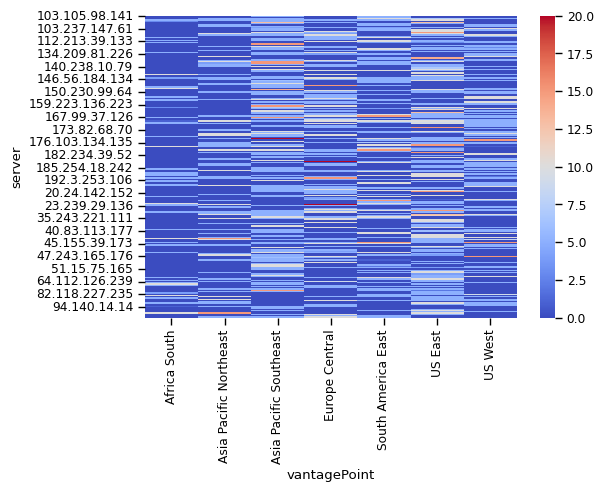

In [1003]:
sns.heatmap(df_dot_doh_worse.groupby(['vantagePoint', 'server'], as_index=False).agg(msm_id_count=('msm_id', 'count')).pivot_table(index='server', columns='vantagePoint', values='msm_id_count', fill_value=0),cmap="coolwarm")
plt.savefig('figures/heatmap-vp-server-dot-and-doh-outlier.pdf', format='pdf', bbox_inches='tight')

In [1185]:
df_dot_doh_worse.groupby(['vantagePoint', 'server'], as_index=False).agg(msm_id_count=('msm_id', 'count')).groupby('vantagePoint').agg(num_servers=('server', 'count'), num_msm=('msm_id_count', 'sum')).sort_values('num_servers')

num_servers  num_msm
vantagePoint                                
Africa South                     50      276
Asia Pacific Northeast           72      459
South America East              101      662
US West                         104      628
Europe Central                  111      754
Asia Pacific Southeast          135      875
US East                         144      990

In [960]:
df_dot_doh_worse.video_ids.value_counts()

aqz-KE-bpKQ    2353
lqiN98z6Dak    2291
Name: video_ids, dtype: int64

<AxesSubplot:xlabel='vantagePoint', ylabel='server'>

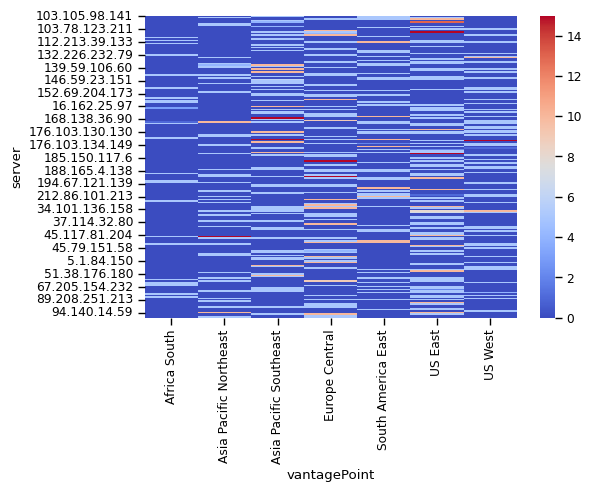

In [961]:
sns.heatmap(df_dot_doh_worse[df_dot_doh_worse.video_ids == 'aqz-KE-bpKQ'].groupby(['vantagePoint', 'server'], as_index=False).agg(msm_id_count=('msm_id', 'count')).pivot_table(index='server', columns='vantagePoint', values='msm_id_count', fill_value=0),cmap="coolwarm")

<AxesSubplot:xlabel='vantagePoint', ylabel='server'>

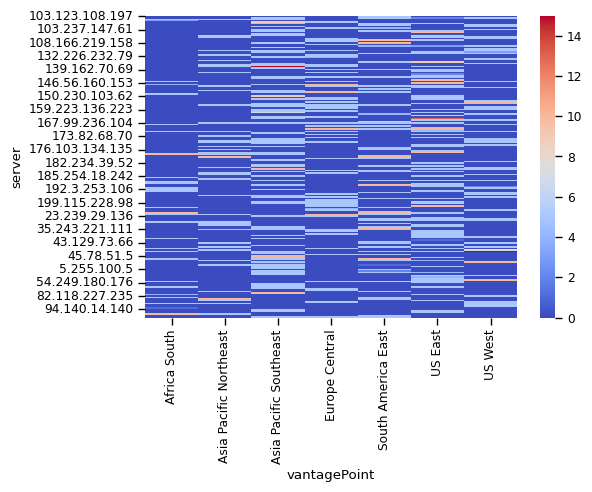

In [962]:
sns.heatmap(df_dot_doh_worse[df_dot_doh_worse.video_ids == 'lqiN98z6Dak'].groupby(['vantagePoint', 'server'], as_index=False).agg(msm_id_count=('msm_id', 'count')).pivot_table(index='server', columns='vantagePoint', values='msm_id_count', fill_value=0),cmap="coolwarm")

In [910]:
df_filter

vantagePoint           server
0     Asia Pacific Northeast     94.140.14.59
1     Asia Pacific Southeast        31.44.0.4
2             Europe Central  176.103.130.149
3     Asia Pacific Northeast    34.159.55.202
4                    US East   103.78.123.211
...                      ...              ...
3221          Europe Central  104.238.154.123
3224            Africa South     94.140.14.14
3403                 US West     188.68.59.46
3515  Asia Pacific Southeast    50.116.59.251
3709                 US East   210.247.245.78

[717 rows x 2 columns]

In [930]:
df_dns_perf_metrics[(df_dns_perf_metrics.msm_id.isin(msm_ids_where_all_are_uncached)) & (df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')].groupby('msm_id').size().value_counts(normalize=True)

3    0.783351
4    0.105656
2    0.077908
5    0.017076
1    0.014941
7    0.001067
dtype: float64

In [931]:
df_dns_perf_metrics[~(df_dns_perf_metrics.msm_id.isin(msm_ids_where_all_are_uncached)) & (df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')].groupby('msm_id').size().value_counts(normalize=True)

3    0.766962
4    0.097210
2    0.096856
5    0.021789
1    0.016342
6    0.000487
7    0.000310
8    0.000044
dtype: float64

In [932]:
df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')].groupby('msm_id').size().value_counts(normalize=True)

3    0.767615
4    0.097546
2    0.096101
5    0.021601
1    0.016286
6    0.000468
7    0.000340
8    0.000043
dtype: float64

In [937]:
df_num_dot_handshakes = df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')].groupby('msm_id', as_index=False).size()

In [940]:
df_num_dot_handshakes[df_num_dot_handshakes['size'] == 3]

msm_id  size
1      0005747c-f270-5e76-c22e-aa8df98f2d6a     3
2      0006208e-e61b-e2ab-bb38-78fe1b50d09f     3
3      0011b452-1735-b999-755d-44454e3780a6     3
4      00170f4d-c33c-efbc-4ff3-f4065d566685     3
5      00189662-e10d-21c8-d6f5-0791f4d7f691     3
...                                     ...   ...
23512  ffefc980-4701-5b31-5ac3-9c8dcf79f79f     3
23513  fff682e2-fc19-c515-c808-1490a13e9f3c     3
23514  fffb19cd-d76d-48d9-5916-3ed3630ca2c8     3
23515  fffe857d-3600-8df0-78f1-278e88326bfa     3
23516  ffffa31f-f901-95b4-20b2-9bf91efb5e0c     3

[18052 rows x 2 columns]

In [253]:
df_query_googlevideo_all = df_handshake_and_query[~df_handshake_and_query.domain.isnull()]
df_query_googlevideo_all = df_query_googlevideo_all[df_query_googlevideo_all.domain.str.endswith('.googlevideo.com')]

In [254]:
df_query_non_googlevideo_all = df_handshake_and_query[~df_handshake_and_query.domain.isnull()]
df_query_non_googlevideo_all = df_query_non_googlevideo_all[~df_query_non_googlevideo_all.domain.str.endswith('.googlevideo.com')]

In [993]:
dot_better

['103.232.207.3',
 '107.172.30.115',
 '118.163.170.2',
 '120.55.44.44',
 '129.154.226.9',
 '13.250.108.212',
 '138.2.72.170',
 '138.2.91.167',
 '139.59.106.60',
 '16.162.44.250',
 '167.99.37.126',
 '168.138.163.222',
 '168.138.50.5',
 '176.103.130.132',
 '176.103.130.136',
 '176.103.130.137',
 '176.103.130.149',
 '176.103.134.35',
 '176.103.134.5',
 '185.254.18.242',
 '188.116.27.94',
 '188.166.209.249',
 '188.227.86.112',
 '199.115.228.98',
 '20.24.142.152',
 '203.160.55.187',
 '204.44.76.45',
 '212.86.101.213',
 '217.160.68.68',
 '220.77.190.228',
 '23.239.29.136',
 '23.95.209.33',
 '31.31.202.109',
 '34.69.170.155',
 '35.241.97.81',
 '35.243.221.111',
 '37.1.195.86',
 '37.114.32.80',
 '38.242.12.100',
 '39.105.150.214',
 '45.155.39.173',
 '45.95.203.99',
 '46.137.195.96',
 '46.3.242.170',
 '47.254.64.251',
 '5.181.48.19',
 '51.158.105.226',
 '51.195.103.20',
 '51.38.176.180',
 '51.89.26.38',
 '54.249.180.176',
 '64.112.126.239',
 '8.210.148.24',
 '85.235.65.70',
 '89.58.10.169',
 '9

DoT query
count    223.000000
mean     155.869320
std       95.362720
min        7.042575
10%       23.800865
20%       80.922079
25%       92.204456
30%      102.884495
40%      117.285739
50%      147.223432
60%      192.340524
70%      211.838442
75%      219.267407
80%      236.940228
90%      268.776975
100%     522.538331
max      522.538331
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count     226.000000
mean      161.899837
std       202.119368
min         7.225185
10%        23.860197
20%        77.904399
25%        82.349284
30%        89.535826
40%       100.778518
50%       116.374347
60%       143.553468
70%       185.564508
75%       222.553690
80%       237.391086
90%       283.806455
100%     2254.563557
max      2254.563557
Name: duration, dtype: float64
DoQ query
count    227.000000
mean     128.036511
std       87.727164
min        7.250801
10%       18.676979
20%       60.611760
25%       76.626300
30%       84.469623
40%       93.077336
50%    

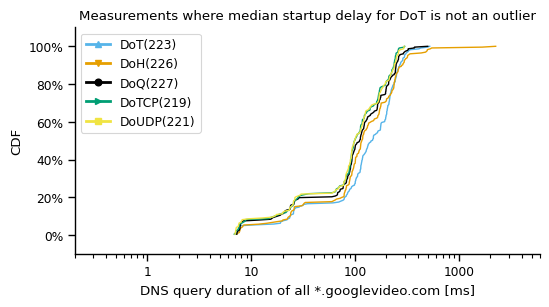

In [255]:
df_plt = pd.merge(df_query_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[df_plt.server.isin(dot_better)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Measurements where median startup delay for DoT is not an outlier')

ax.set_xlabel('DNS query duration of all *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

DoT query
count    268.000000
mean     226.939488
std      150.653717
min        7.150467
10%       82.668992
20%      102.525575
25%      117.708614
30%      140.167549
40%      186.151133
50%      211.856818
60%      233.769121
70%      255.990258
75%      274.906185
80%      302.643241
90%      388.253086
100%     997.513671
max      997.513671
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    267.000000
mean     168.440661
std      111.323409
min        7.121783
10%       66.201857
20%       86.470087
25%       92.395310
30%       99.672929
40%      117.291001
50%      145.250343
60%      194.896342
70%      217.714468
75%      228.836399
80%      238.820511
90%      282.504578
100%     997.783928
max      997.783928
Name: duration, dtype: float64
DoQ query
count     264.000000
mean      180.169208
std       155.000351
min         7.281385
10%        66.307026
20%        80.924489
25%        87.453951
30%        95.670510
40%       116.299068
50%       147.2

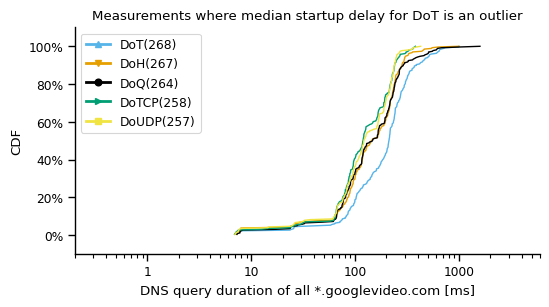

In [256]:
df_plt = pd.merge(df_query_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[df_plt.server.isin(doh_better)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Measurements where median startup delay for DoT is an outlier')

ax.set_xlabel('DNS query duration of all *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))


plt.show()

In [258]:
df_plt[(df_plt.protocol == 'DoT') & (df_plt.duration > 105) & (df_plt.duration < 115)]

msm_id  \
374   c788528b-a658-bac1-7e59-b43936c6a744   
473   675678d5-7777-1c82-b2d6-e839ea9fc882   
1287  e7a628fd-e962-99cb-3836-4347d09a2411   
1451  9cb0a181-e861-693c-a480-852b7dc20bf9   
1798  14783bd8-b3e1-e3f0-2c46-ecf44913b9d3   
1846  71e36567-6bf9-0af6-a3cc-09a65f9f0f82   
1927  2e53d10a-9b99-683a-54ca-fa1388896546   

                                                 metric metric_type  \
374   DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   
473   DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1287  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1451  DoT query duration for [;rr2---sn-p5qlsndd.goo...       query   
1798  DoT query duration for [;rr4---sn-p5qlsn76.goo...       query   
1846  DoT query duration for [;rr2---sn-p5qs7nel.goo...       query   
1927  DoT query duration for [;rr4---sn-p5qs7nsr.goo...       query   

        duration  base            metric_start              metric_end  \
374   113.867423   1.0 2022-05-02 19:50:32.969 2022-05-02 19:50:33.083   
473   112.603054   1.0 2022-05-02 20:57:53.492 2022-05-02 20:57:53.604   
1287  106.507547   1.0 2022-05-03 04:16:02.914 2022-05-03 04:16:03.021   
1451  110.736639   1.0 2022-05-03 05:44:31.211 2022-05-03 05:44:31.322   
1798  111.584101   1.0 2022-05-03 08:59:48.843 2022-05-03 08:59:48.954   
1846  107.917002   1.0 2022-05-03 09:21:43.933 2022-05-03 09:21:44.041   
1927  108.872696   1.0 2022-05-03 10:01:49.569 2022-05-03 10:01:49.678   

     protocol                             domain          server  
374       DoT  rr4---sn-p5qs7nsr.googlevideo.com   51.75.162.101  
473       DoT  rr2---sn-p5qlsndd.googlevideo.com  194.67.121.139  
1287      DoT  rr2---sn-p5qlsndd.googlevideo.com    5.181.76.195  
1451      DoT  rr2---sn-p5qlsndd.googlevideo.com     45.147.54.7  
1798      DoT  rr4---sn-p5qlsn76.googlevideo.com   167.99.37.126  
1846      DoT  rr2---sn-p5qs7nel.googlevideo.com  154.49.211.118  
1927      DoT  rr4---sn-p5qs7nsr.googlevideo.com   176.103.134.5

In [262]:
measurements[measurements.msm_id == '71e36567-6bf9-0af6-a3cc-09a65f9f0f82']

msm_id              py_time       js_time  \
1727  71e36567-6bf9-0af6-a3cc-09a65f9f0f82  1651569710012665974  1.651570e+12   

      resource_time_origin protocol          server       domain vantagePoint  \
1727          1.651570e+12      DoT  154.49.211.118  aqz-KE-bpKQ      US East   

                      timestamp suggested_quality player_width player_height  \
1727 2022-05-03 09:21:38.933061              auto         1280           720   

      start_time  play_time    video_ids  cacheWarming error player_dimensions  
1727           0          5  aqz-KE-bpKQ             0                1280x720

In [261]:
df_plt[df_plt.server == '154.49.211.118']

msm_id  \
1846  71e36567-6bf9-0af6-a3cc-09a65f9f0f82   
1847  9aa71d42-403f-ff53-b127-4e3d40df9e8d   
1848  198958b1-c2ec-7bda-b67b-25694605cf94   
1849  373c5e3d-69d3-6dfb-5b98-bb62a05e27bd   
1850  6ee22549-fd3b-bd3a-cfe7-f9d6e18217b9   
1851  0dec1b95-e8fe-a3b5-58ee-0b843d6de1d5   
1852  bb36bf94-71c4-52ff-d210-62153b41b16c   
1853  5a782036-78fe-a931-e508-a39ebd6b8012   
1854  1ed56880-93bc-04a1-a23b-37995af3378f   
1855  85e56a58-1421-a344-d13b-1ff08eff2456   

                                                 metric  \
1846  DoT query duration for [;rr2---sn-p5qs7nel.goo...   
1847  DoH query (and likely handshake) duration for ...   
1848  DoQ query duration for [;rr2---sn-p5qlsndd.goo...   
1849  DoTCP query duration for [;rr2---sn-p5qs7nel.g...   
1850  DoUDP query duration for [;rr2---sn-p5qs7nel.g...   
1851  DoT query duration for [;rr4---sn-p5qlsn76.goo...   
1852  DoH query (and likely handshake) duration for ...   
1853  DoQ query duration for [;rr4---sn-p5qlsn76.goo...   
1854  DoTCP query duration for [;rr4---sn-p5qlsn76.g...   
1855  DoUDP query duration for [;rr4---sn-p5qlsn76.g...   

                        metric_type    duration  base            metric_start  \
1846                          query  107.917002   1.0 2022-05-03 09:21:43.933   
1847  lazy-init-handshake-and-query   83.077582   1.0 2022-05-03 09:22:12.060   
1848                          query  101.107978   1.0 2022-05-03 09:22:40.155   
1849                          query   82.033978   1.0 2022-05-03 09:23:08.445   
1850                          query   82.805099   1.0 2022-05-03 09:23:36.149   
1851                          query   98.649315   1.0 2022-05-03 09:24:04.357   
1852  lazy-init-handshake-and-query   82.166472   1.0 2022-05-03 09:24:32.345   
1853                          query   82.712282   1.0 2022-05-03 09:25:00.330   
1854                          query   82.262110   1.0 2022-05-03 09:25:28.554   
1855                          query   83.098841   1.0 2022-05-03 09:25:56.068   

                  metric_end protocol                             domain  \
1846 2022-05-03 09:21:44.041      DoT  rr2---sn-p5qs7nel.googlevideo.com   
1847 2022-05-03 09:22:12.143      DoH  rr2---sn-p5qs7nel.googlevideo.com   
1848 2022-05-03 09:22:40.256      DoQ  rr2---sn-p5qlsndd.googlevideo.com   
1849 2022-05-03 09:23:08.527    DoTCP  rr2---sn-p5qs7nel.googlevideo.com   
1850 2022-05-03 09:23:36.232    DoUDP  rr2---sn-p5qs7nel.googlevideo.com   
1851 2022-05-03 09:24:04.455      DoT  rr4---sn-p5qlsn76.googlevideo.com   
1852 2022-05-03 09:24:32.427      DoH  rr4---sn-p5qlsn76.googlevideo.com   
1853 2022-05-03 09:25:00.413      DoQ  rr4---sn-p5qlsn76.googlevideo.com   
1854 2022-05-03 09:25:28.636    DoTCP  rr4---sn-p5qlsn76.googlevideo.com   
1855 2022-05-03 09:25:56.151    DoUDP  rr4---sn-p5qlsn76.googlevideo.com   

              server  
1846  154.49.211.118  
1847  154.49.211.118  
1848  154.49.211.118  
1849  154.49.211.118  
1850  154.49.211.118  
1851  154.49.211.118  
1852  154.49.211.118  
1853  154.49.211.118  
1854  154.49.211.118  
1855  154.49.211.118

DoT query
count    76857.000000
mean       168.497737
std        141.921531
min          0.561151
10%         24.203633
20%         76.604591
25%         93.511458
30%        112.599872
40%        148.129657
50%        165.103808
60%        189.243473
70%        210.914178
75%        231.314807
80%        245.102365
90%        289.358431
100%     10000.195225
max      10000.195225
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    76463.000000
mean       220.364805
std        228.885550
min          0.676884
10%         26.354657
20%         85.529569
25%         99.023938
30%        123.790312
40%        155.329983
50%        179.323606
60%        204.271903
70%        239.452385
75%        265.182257
80%        286.479107
90%        400.065208
100%      6221.029173
max       6221.029173
Name: duration, dtype: float64
DoQ query
count    76161.000000
mean       168.314913
std        103.037933
min          0.728822
10%         24.124887
20%         76.431947
25% 

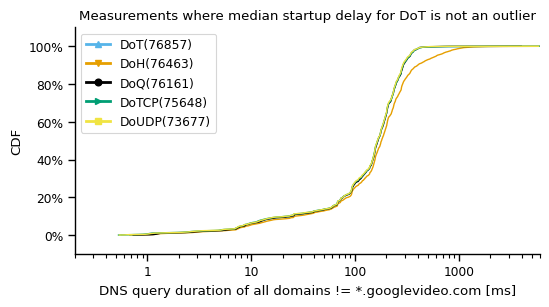

In [1043]:

df_plt = pd.merge(df_query_non_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[df_plt.server.isin(dot_better)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Measurements where median startup delay for DoT is not an outlier')

ax.set_xlabel('DNS query duration of all domains != *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

if log:
    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-non-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-non-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoT query
count    137555.000000
mean        185.110112
std         143.111238
min           0.066549
10%          36.429394
20%          93.508848
25%         110.818190
30%         130.308815
40%         155.085070
50%         179.434336
60%         201.929181
70%         235.416727
75%         250.774810
80%         267.976933
90%         311.266774
100%      10000.853438
max       10000.853438
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    137038.000000
mean        224.462210
std         193.236414
min           0.678089
10%          38.075421
20%          97.234673
25%         116.835781
30%         138.612440
40%         161.098989
50%         191.333788
60%         221.668510
70%         256.731538
75%         276.751127
80%         293.481742
90%         392.450009
100%       9549.029193
max        9549.029193
Name: duration, dtype: float64
DoQ query
count    137877.000000
mean        182.036254
std         113.346041
min           0.761824
10%       

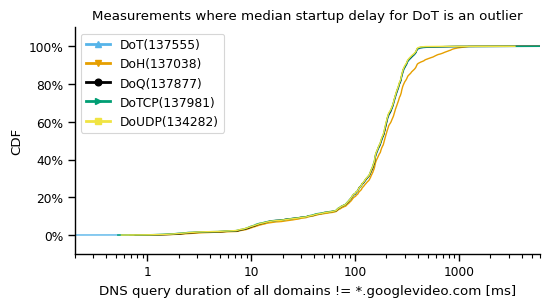

In [1044]:
df_plt = pd.merge(df_query_non_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[df_plt.server.isin(doh_better)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Measurements where median startup delay for DoT is an outlier')

ax.set_xlabel('DNS query duration of all domains != *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

if log:
    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-non-googlevideo-median-startup-delay-filter-dot-worse-log.pdf', format='pdf', bbox_inches='tight')
else:
    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-non-googlevideo-median-startup-delay-filter-dot-worse.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [1127]:
df_test = df_start_time.groupby(['vantagePoint','server', 'protocol']).agg(startup_delay=('startup_delay', 'median')).unstack().reset_index()
df_test.columns = [''.join(col).strip().replace('startup_delay', "", 1) for col in df_test.columns.values]

In [1128]:
median_doh_better = 0
median_dot_better = 0
doh_better_vp = dict()
dot_better_vp = dict()
for vp in df_test.vantagePoint.unique():
    doh_better_vp[vp] = set()
    dot_better_vp[vp] = set()
for idx, row in df_test.iterrows():
    #if row['DoT'] > row['DoH']:
    if row['DoT']-row['DoH'] > 0.01 :
        median_doh_better = median_doh_better+1
        doh_better_vp[row['vantagePoint']].add(row['server'])
    else:
        median_dot_better = median_dot_better+1
        dot_better_vp[row['vantagePoint']].add(row['server'])
print(median_doh_better)
print(median_dot_better)
print(median_dot_better+median_doh_better)


1028
714
1742


In [1129]:
running_set_doh = set()
running_set_dot = set()
for vp in df_test.vantagePoint.unique():
    if len(running_set_doh) == 0:
        running_set_doh = doh_better_vp[vp]
        running_set_dot = dot_better_vp[vp]
    else:
        running_set_doh = running_set_doh.intersection(doh_better_vp[vp])
        running_set_dot = running_set_dot.intersection(dot_better_vp[vp])
print(len(running_set_doh))
print(len(running_set_dot))

31
3


DoT query
count    22285.000000
mean       219.433354
std        144.679069
min          0.604537
10%         56.711417
20%        107.702735
25%        136.442164
30%        155.235389
40%        180.436931
50%        206.502522
60%        235.770968
70%        269.183600
75%        290.183722
80%        309.095364
90%        371.244668
100%      3455.151202
max       3455.151202
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    22123.000000
mean       201.821007
std        167.356823
min          0.757622
10%         41.585668
20%         95.091096
25%        115.370556
30%        139.651201
40%        162.530615
50%        188.620566
60%        213.683169
70%        245.988668
75%        264.569632
80%        283.247202
90%        336.084898
100%      4124.334013
max       4124.334013
Name: duration, dtype: float64
DoQ query
count    22161.000000
mean       186.497587
std        117.711489
min          0.753320
10%         35.802348
20%         92.656724
25% 

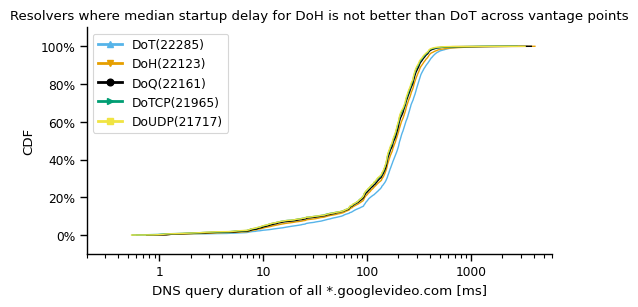

In [1131]:
df_plt = pd.merge(df_query_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[~df_plt.server.isin(running_set_doh)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median startup delay for DoH is not better than DoT across vantage points')

ax.set_xlabel('DNS query duration of all *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

#if log:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
#else:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [1108]:
resolvers_in_order_from_target_list = ["34.101.136.158", "20.24.25.74", "103.232.207.2", "103.232.207.3", "194.177.23.120", "130.61.24.160", "147.182.195.29", "8.210.148.24", "217.160.68.68", "141.95.140.195", "118.163.170.2", "13.124.186.64", "101.32.27.77", "47.243.57.44", "185.150.117.6", "46.3.242.170", "104.244.72.39", "119.23.190.32", "195.90.213.140", "192.3.127.219", "192.46.231.38", "43.154.154.162", "78.15.98.223", "185.212.57.244", "173.255.211.77", "168.138.53.111", "138.2.86.147", "176.103.130.134", "168.138.163.222", "92.38.241.36", "150.230.99.64", "15.184.189.254", "42.192.89.119", "173.255.211.87", "107.191.51.151", "85.214.195.112", "176.113.83.49", "164.92.237.199", "103.227.141.70", "138.2.79.62", "159.223.136.223", "168.138.169.197", "138.2.89.57", "144.24.175.202", "182.234.39.52", "135.125.236.23", "77.73.71.58", "23.94.120.177", "152.67.223.117", "104.168.11.116", "152.70.189.89", "43.128.20.252", "16.162.25.97", "52.229.189.143", "176.103.134.149", "51.75.162.101", "119.3.92.152", "185.229.251.250", "86.233.218.250", "160.16.123.42", "86.238.66.147", "3.9.43.184", "47.108.131.255", "176.103.134.150", "37.114.32.44", "107.172.103.160", "54.249.180.176", "45.12.19.254", "45.82.178.72", "176.103.134.134", "98.154.23.186", "147.189.137.111", "82.165.167.91", "138.2.91.167", "194.67.121.139", "178.62.207.252", "37.221.215.77", "157.119.101.122", "152.67.9.211", "144.22.147.217", "20.194.29.67", "37.114.32.22", "172.105.16.134", "13.250.108.212", "94.140.14.140", "158.101.139.156", "152.67.204.139", "139.59.106.60", "146.56.176.39", "109.205.178.178", "164.90.199.170", "185.177.218.107", "5.255.103.147", "51.89.26.38", "113.31.103.21", "168.138.36.90", "103.179.44.88", "185.232.170.153", "176.103.130.150", "45.67.32.107", "3.9.78.39", "180.93.137.1", "139.162.142.149", "46.232.251.76", "43.132.147.94", "5.1.84.150", "93.115.24.204", "138.2.84.109", "45.78.51.5", "134.122.42.163", "138.3.219.11", "176.103.130.131", "146.59.32.198", "176.103.130.149", "176.103.134.135", "62.109.2.197", "94.140.14.141", "103.192.236.242", "45.95.203.99", "80.85.136.144", "103.78.123.211", "45.79.151.58", "146.56.137.68", "45.146.255.31", "176.103.130.130", "80.209.236.92", "210.247.245.78", "89.208.251.213", "176.103.134.35", "199.101.171.125", "158.101.149.111", "104.238.154.123", "140.238.36.23", "50.116.59.251", "103.105.98.141", "103.124.95.99", "35.156.129.204", "23.95.209.33", "103.237.147.61", "173.82.243.163", "40.83.113.177", "80.91.176.168", "107.172.30.115", "20.24.142.152", "135.125.181.234", "37.235.49.163", "139.162.70.69", "106.12.119.30", "120.55.44.44", "93.115.24.205", "43.129.73.66", "37.114.32.80", "202.61.207.68", "34.159.55.202", "47.107.121.125", "160.251.96.67", "15.165.113.96", "185.254.18.242", "204.44.76.45", "221.154.186.148", "161.97.116.66", "51.38.176.180", "64.225.50.86", "164.92.136.119", "35.241.97.81", "185.180.206.110", "188.68.45.12", "38.242.12.100", "188.72.209.168", "195.34.241.205", "140.238.10.79", "192.3.73.139", "134.209.81.226", "146.56.184.134", "5.181.76.195", "47.91.45.44", "152.70.232.216", "150.230.103.62", "47.108.238.232", "193.123.252.172", "194.87.102.241", "23.239.29.136", "94.140.14.59", "94.140.14.49", "51.195.116.94", "188.166.237.128", "45.136.245.220", "36.91.73.210", "46.137.195.96", "103.179.45.33", "108.166.219.158", "188.154.194.83", "85.235.65.70", "141.147.45.208", "45.147.54.7", "104.199.26.56", "185.175.57.120", "152.69.204.173", "82.118.227.235", "92.246.84.75", "45.129.2.32", "129.154.226.9", "188.68.59.46", "52.169.109.90", "16.170.150.221", "103.192.236.244", "128.199.115.141", "185.121.25.64", "152.70.54.34", "158.101.178.190", "87.106.168.61", "5.255.100.5", "220.77.190.228", "67.205.154.232", "150.230.197.114", "51.195.103.20", "161.129.152.196", "5.181.48.19", "198.211.40.216", "123.195.161.145", "103.123.108.197", "146.56.112.4", "173.82.68.70", "199.115.228.98", "104.244.79.105", "89.58.10.169", "47.103.26.225", "154.0.173.6", "140.83.39.110", "132.226.232.79", "94.140.15.16", "176.102.36.61", "176.103.130.132", "35.243.221.111", "103.172.17.226", "212.86.101.213", "173.82.151.158", "31.44.0.4", "203.160.55.187", "167.99.37.126", "45.86.182.127", "51.15.75.165", "146.56.177.76", "188.165.4.138", "154.49.211.118", "146.56.160.153", "217.160.27.71", "45.55.104.59", "91.239.27.199", "198.244.209.255", "64.112.126.239", "176.103.134.4", "85.192.48.70", "176.103.134.5", "41.21.230.0", "192.3.253.106", "128.199.66.193", "67.198.131.72", "172.105.101.43", "210.16.120.48", "31.31.202.109", "138.2.72.170", "176.103.130.137", "94.140.15.15", "34.69.170.155", "52.233.72.204", "103.176.79.211", "193.201.126.42", "158.101.69.250", "150.230.147.64", "103.192.236.243", "188.227.86.112", "16.162.44.250", "172.104.183.19", "188.166.209.249", "51.158.105.226", "116.118.44.237", "176.103.134.34", "37.1.195.86", "94.140.14.14", "5.135.233.74", "218.251.80.123", "132.145.83.120", "112.213.39.133", "39.105.150.214", "37.114.32.99", "149.56.45.165", "152.70.70.91", "209.17.118.5", "140.238.42.214", "66.42.74.125", "185.200.34.171", "147.189.137.154", "188.116.27.94", "54.37.203.237", "176.103.130.136", "185.244.173.222", "167.99.236.104", "47.243.165.176", "152.70.210.231", "146.59.226.118", "47.254.64.251", "83.212.102.207", "47.243.237.126", "94.140.14.15", "103.172.17.225", "146.59.23.151", "45.155.39.173", "45.117.81.204", "192.26.105.29", "185.17.3.188", "168.138.50.5"]

In [1109]:
df_heatmap_ = pd.DataFrame(index=df_test.vantagePoint.unique(), columns=resolvers_in_order_from_target_list)

In [1110]:
for vp in df_test.vantagePoint.unique():
    resolvers_doh_better = doh_better_vp[vp]
    for resolver in resolvers_doh_better:
        df_heatmap_.loc[vp][resolver] = 0
    resolvers_dot_better = dot_better_vp[vp]
    for resolver in resolvers_dot_better:
        df_heatmap_.loc[vp][resolver] = 1
df_heatmap_

34.101.136.158 20.24.25.74 103.232.207.2 103.232.207.3  \
Africa South                        0         NaN             0             1   
Asia Pacific Northeast              0         NaN             1             1   
Asia Pacific Southeast              1         NaN             1             1   
Europe Central                      0         NaN             0             1   
South America East                  1         NaN             0             1   
US East                             1         NaN             1             1   
US West                             0         NaN             0             1   

                       194.177.23.120 130.61.24.160 147.182.195.29  \
Africa South                      NaN             0              0   
Asia Pacific Northeast            NaN             0              0   
Asia Pacific Southeast            NaN             0              0   
Europe Central                    NaN             1              1   
South America East                NaN             0              0   
US East                           NaN             0              0   
US West                           NaN             1              1   

                       8.210.148.24 217.160.68.68 141.95.140.195  ...  \
Africa South                      0             1              0  ...   
Asia Pacific Northeast            1             0              0  ...   
Asia Pacific Southeast            0             1              1  ...   
Europe Central                    1             0              1  ...   
South America East                1             1              1  ...   
US East                           1             1              0  ...   
US West                           0             1              1  ...   

                       83.212.102.207 47.243.237.126 94.140.14.15  \
Africa South                        0            NaN            1   
Asia Pacific Northeast              0            NaN            1   
Asia Pacific Southeast              0            NaN            0   
Europe Central                      0            NaN            1   
South America East                  0            NaN            1   
US East                             0            NaN            1   
US West                             0            NaN            1   

                       103.172.17.225 146.59.23.151 45.155.39.173  \
Africa South                        0             0           NaN   
Asia Pacific Northeast              0             0             1   
Asia Pacific Southeast              1             0             1   
Europe Central                      0             1             1   
South America East                  0             0             0   
US East                             1             1             1   
US West                             0             0             1   

                       45.117.81.204 192.26.105.29 185.17.3.188 168.138.50.5  
Africa South                       0             0            0            0  
Asia Pacific Northeast             0             0            0            1  
Asia Pacific Southeast             0             1            0            0  
Europe Central                     0             0            0            1  
South America East                 0             0            0            0  
US East                            0             0            0            1  
US West                            0             0            0            0  

[7 rows x 312 columns]

In [1111]:
df_heatmap_.dropna(axis=1, how='all', inplace=True)

In [1112]:
df_heatmap_.fillna(-1, inplace=True)

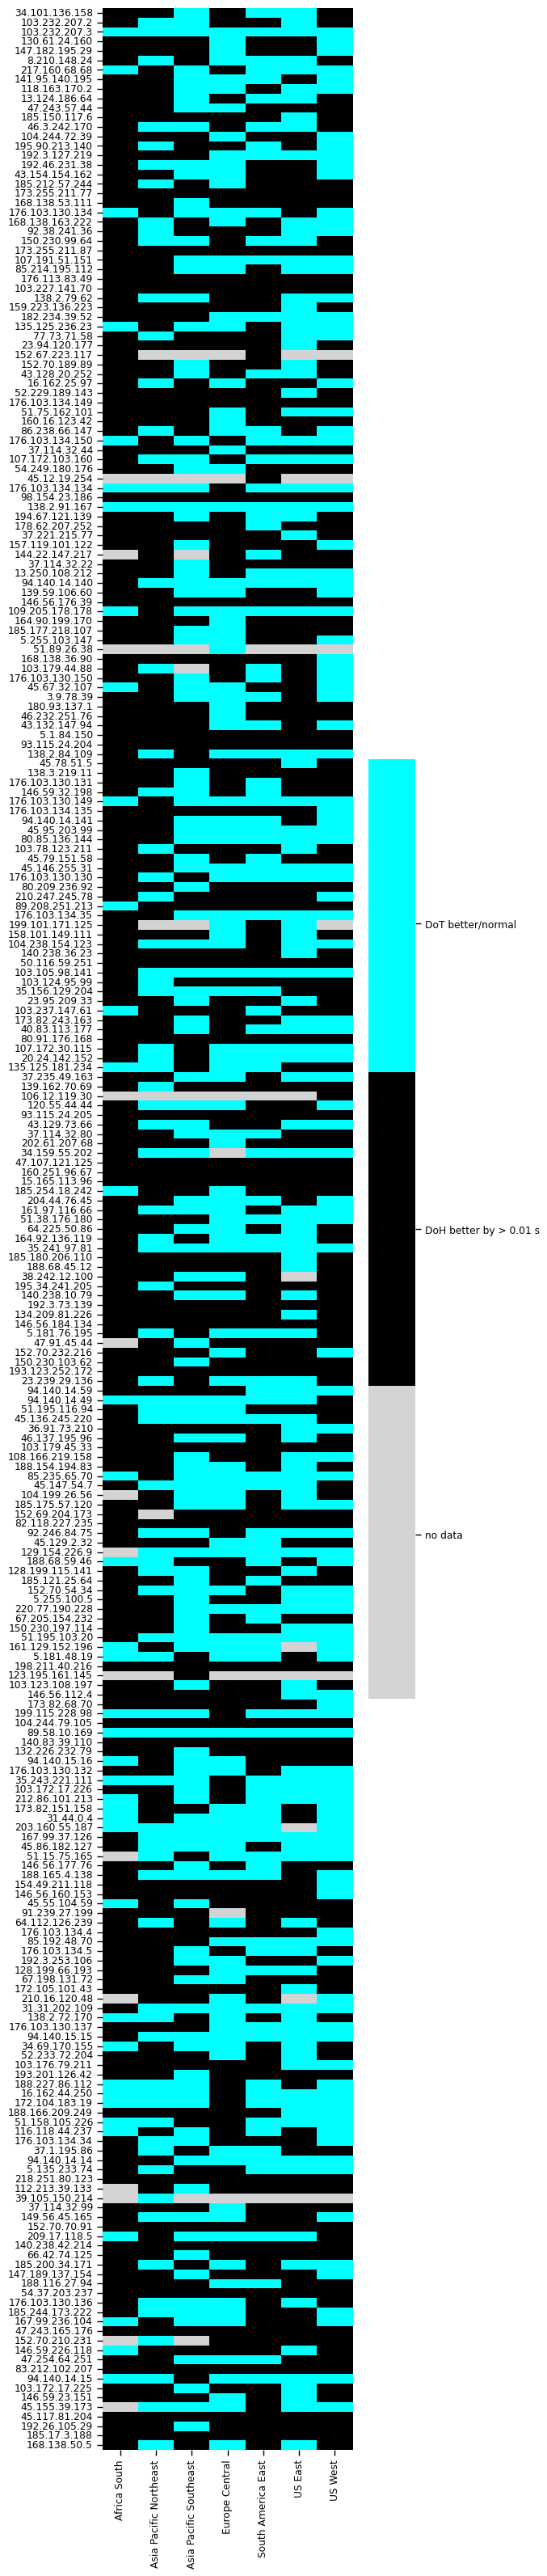

In [1119]:
plt.figure(figsize = (5,40))
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', ['lightgray', 'black', 'cyan'], 3)

ax = sns.heatmap(df_heatmap_.transpose(), cmap=cmap, xticklabels=True, yticklabels=True)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-.65, 0, .65])
colorbar.set_ticklabels(['no data', 'DoH better by > 0.01 s', 'DoT better/normal'])
#plt.savefig('figures/heatmap-vp-server-dot-and-doh-outlier.pdf', format='pdf', bbox_inches='tight')

In [1116]:
len(df_heatmap_.transpose())

257

In [1121]:
df_start_time.domain.unique()

array(['aqz-KE-bpKQ', 'lqiN98z6Dak'], dtype=object)

aqz-KE-bpKQ
all vantage points:
1062
680
1742
intersection across vantage points:
26
5


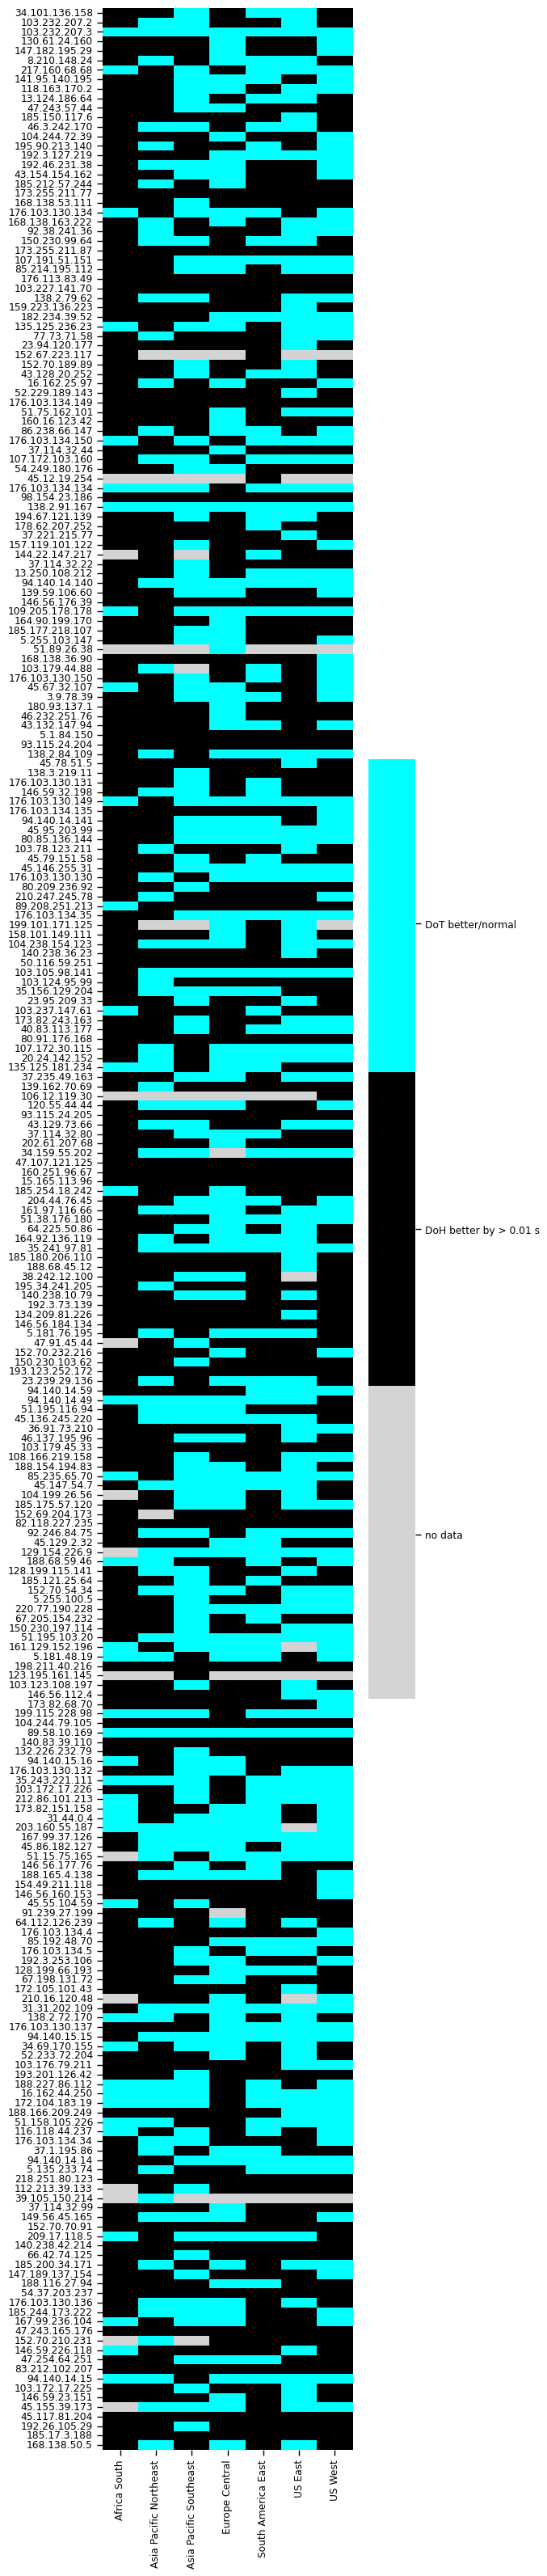

In [1123]:
print('aqz-KE-bpKQ')
df_test = df_start_time[df_start_time.domain == 'aqz-KE-bpKQ'].groupby(['vantagePoint','server', 'protocol']).agg(startup_delay=('startup_delay', 'median')).unstack().reset_index()
df_test.columns = [''.join(col).strip().replace('startup_delay', "", 1) for col in df_test.columns.values]
median_doh_better = 0
median_dot_better = 0
doh_better_vp = dict()
dot_better_vp = dict()
for vp in df_test.vantagePoint.unique():
    doh_better_vp[vp] = set()
    dot_better_vp[vp] = set()
for idx, row in df_test.iterrows():
    #if row['DoT'] > row['DoH']:
    if row['DoT']-row['DoH'] > 0.01 :
        median_doh_better = median_doh_better+1
        doh_better_vp[row['vantagePoint']].add(row['server'])
    else:
        median_dot_better = median_dot_better+1
        dot_better_vp[row['vantagePoint']].add(row['server'])
print("all vantage points:")
print(median_doh_better)
print(median_dot_better)
print(median_dot_better+median_doh_better)
running_set_doh = set()
running_set_dot = set()
for vp in df_test.vantagePoint.unique():
    if len(running_set_doh) == 0:
        running_set_doh = doh_better_vp[vp]
        running_set_dot = dot_better_vp[vp]
    else:
        running_set_doh = running_set_doh.intersection(doh_better_vp[vp])
        running_set_dot = running_set_dot.intersection(dot_better_vp[vp])
print("intersection across vantage points:")
print(len(running_set_doh))
print(len(running_set_dot))
df_heatmap_first_video = pd.DataFrame(index=df_test.vantagePoint.unique(), columns=resolvers_in_order_from_target_list)
for vp in df_test.vantagePoint.unique():
    resolvers_doh_better = doh_better_vp[vp]
    for resolver in resolvers_doh_better:
        df_heatmap_first_video.loc[vp][resolver] = 0
    resolvers_dot_better = dot_better_vp[vp]
    for resolver in resolvers_dot_better:
        df_heatmap_first_video.loc[vp][resolver] = 1
df_heatmap_first_video.dropna(axis=1, how='all', inplace=True)
df_heatmap_first_video.fillna(-1, inplace=True)
plt.figure(figsize = (5,40))
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', ['lightgray', 'black', 'cyan'], 3)

ax = sns.heatmap(df_heatmap_.transpose(), cmap=cmap, xticklabels=True, yticklabels=True)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-.65, 0, .65])
colorbar.set_ticklabels(['no data', 'DoH better by > 0.01 s', 'DoT better/normal'])
#plt.savefig('figures/heatmap-vp-server-dot-and-doh-outlier.pdf', format='pdf', bbox_inches='tight')

lqiN98z6Dak
all vantage points:
977
765
1742
intersection across vantage points:
22
5


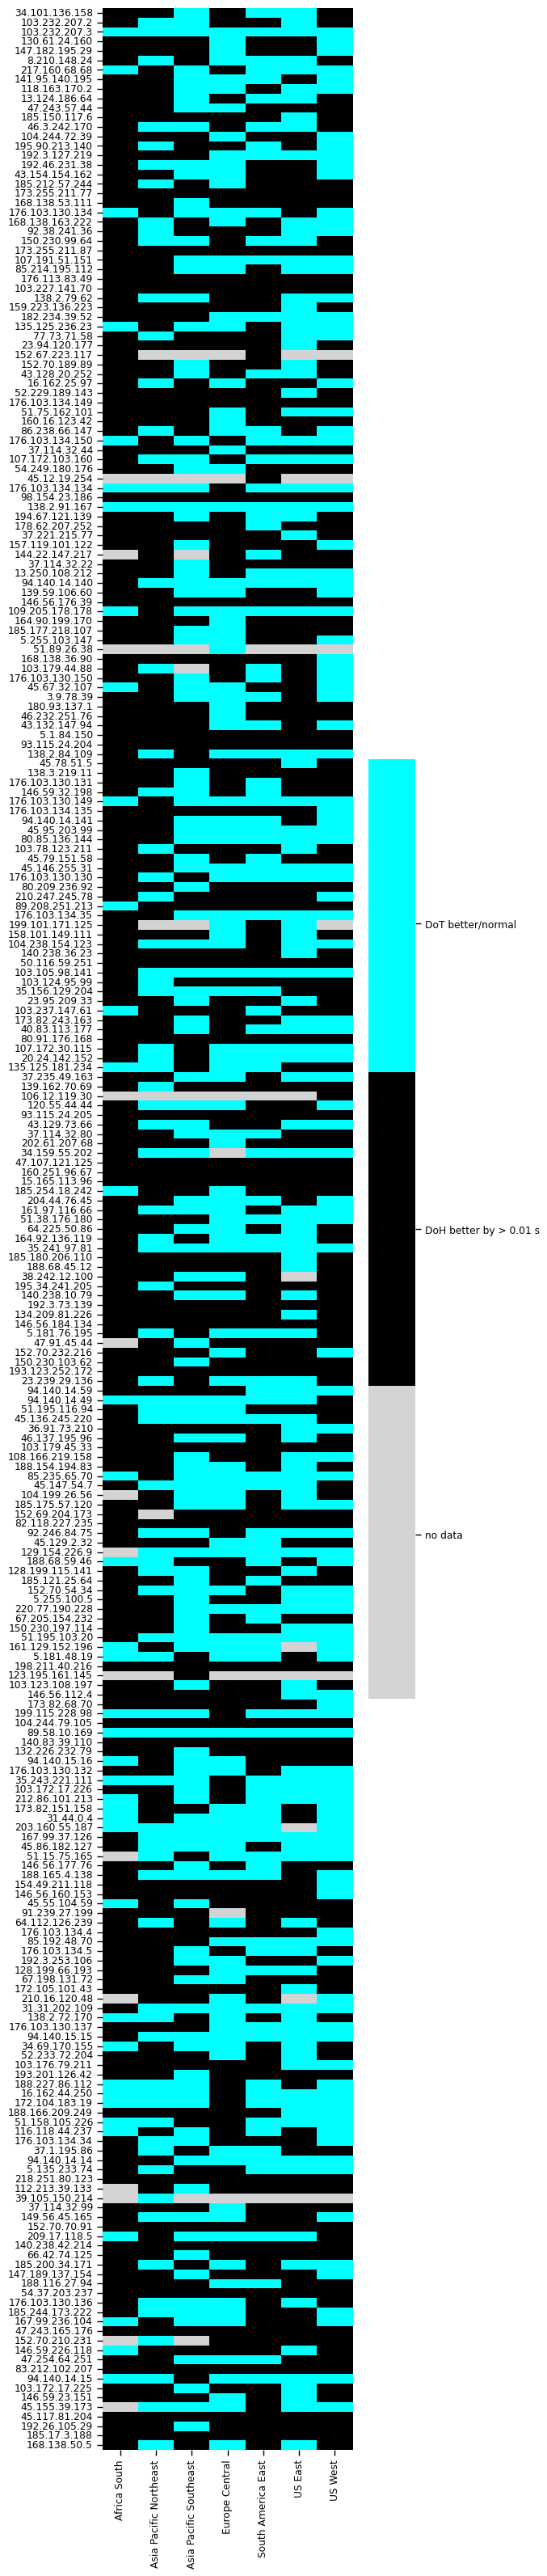

In [1124]:
print('lqiN98z6Dak')
df_test = df_start_time[df_start_time.domain == 'lqiN98z6Dak'].groupby(['vantagePoint','server', 'protocol']).agg(startup_delay=('startup_delay', 'median')).unstack().reset_index()
df_test.columns = [''.join(col).strip().replace('startup_delay', "", 1) for col in df_test.columns.values]
median_doh_better = 0
median_dot_better = 0
doh_better_vp = dict()
dot_better_vp = dict()
for vp in df_test.vantagePoint.unique():
    doh_better_vp[vp] = set()
    dot_better_vp[vp] = set()
for idx, row in df_test.iterrows():
    #if row['DoT'] > row['DoH']:
    if row['DoT']-row['DoH'] > 0.01 :
        median_doh_better = median_doh_better+1
        doh_better_vp[row['vantagePoint']].add(row['server'])
    else:
        median_dot_better = median_dot_better+1
        dot_better_vp[row['vantagePoint']].add(row['server'])
print("all vantage points:")
print(median_doh_better)
print(median_dot_better)
print(median_dot_better+median_doh_better)
running_set_doh = set()
running_set_dot = set()
for vp in df_test.vantagePoint.unique():
    if len(running_set_doh) == 0:
        running_set_doh = doh_better_vp[vp]
        running_set_dot = dot_better_vp[vp]
    else:
        running_set_doh = running_set_doh.intersection(doh_better_vp[vp])
        running_set_dot = running_set_dot.intersection(dot_better_vp[vp])
print("intersection across vantage points:")
print(len(running_set_doh))
print(len(running_set_dot))
df_heatmap_first_video = pd.DataFrame(index=df_test.vantagePoint.unique(), columns=resolvers_in_order_from_target_list)
for vp in df_test.vantagePoint.unique():
    resolvers_doh_better = doh_better_vp[vp]
    for resolver in resolvers_doh_better:
        df_heatmap_first_video.loc[vp][resolver] = 0
    resolvers_dot_better = dot_better_vp[vp]
    for resolver in resolvers_dot_better:
        df_heatmap_first_video.loc[vp][resolver] = 1
df_heatmap_first_video.dropna(axis=1, how='all', inplace=True)
df_heatmap_first_video.fillna(-1, inplace=True)
plt.figure(figsize = (5,40))
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', ['lightgray', 'black', 'cyan'], 3)

ax = sns.heatmap(df_heatmap_.transpose(), cmap=cmap, xticklabels=True, yticklabels=True)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-.65, 0, .65])
colorbar.set_ticklabels(['no data', 'DoH better by > 0.01 s', 'DoT better/normal'])
#plt.savefig('figures/heatmap-vp-server-dot-and-doh-outlier.pdf', format='pdf', bbox_inches='tight')

In [1133]:
df_query_googlevideo_all

msm_id  \
34       17915357-f2e4-81b4-acf7-b71255703ed8   
66       8297db7d-70e2-96ab-3824-ef58929e52d6   
100      fb06c88b-3fed-edba-5b29-27e4972a583a   
147      1d2e67cb-91c8-112f-f2eb-1d9f3db0d4b2   
195      d94c98d2-b7ae-30cf-1b77-0d03406c2669   
234      56791d63-e17d-3cab-230c-54fe853c1f61   
266      cbdcf805-b233-cc76-2836-09a1c01d347a   
300      ce2a8412-3b21-5bc7-50a8-7ab8d74df195   
347      92a81b81-1f99-7a2b-f22b-62682d1299d0   
395      352f07a3-9739-eeda-febf-5d3000a3ae5b   
434      c7b739f5-eb61-8ade-2446-0c01e5ec5bc9   
466      8aff5c01-f9c4-c266-b3ca-1fcd9bccb8fa   
500      2aa05e51-e240-2222-abf9-cd28ffa8224a   
547      f2d0712b-4fbd-9d4e-0c86-0ac236a535c6   
595      47067281-0499-10d6-820b-8a4ab1fb312d   
634      0b5e43c3-1cfa-7ea9-8126-510d9e6f79a1   
666      7fd2cb76-ac59-9160-5c09-d625f613486f   
700      32848d5a-8070-a9cc-91c1-90d7015a5e67   
747      f157ddd8-fd7b-b65e-9fca-c38ce6cce954   
795      77c8050d-8d3d-ccc3-1bc3-334af8cc8f64   
834      27062d86-4d3a-00ba-6ae0-adfb10b9c426   
866      4e0cd21b-10d1-0122-647f-ca17c5cdf118   
898      d6ec7dc6-2edb-6d93-3343-7c5e65e4b8ab   
945      0ff38e77-1d5a-4a5f-e46c-5c5e18badeff   
993      d30241d7-6dc3-fe7e-2fe0-6af1b028c712   
...                                       ...   
4937844  3ded8c07-32c4-1f40-5e5e-f38b3fa70432   
4937891  e4060454-6a23-c41a-c2ce-b7128f181320   
4937939  ac052934-9cb5-962d-8e6f-52578f135729   
4937978  facdfa87-28bb-d614-e532-97401814e57b   
4938010  cde0868b-54f0-4d08-0b4d-498e10a99043   
4938048  e1951402-ba3e-ef8f-5e61-758171de9677   
4938092  ac73b2f5-4724-12de-117d-afe3ee00e2a3   
4938143  50790dcc-e14a-4c7a-dc4e-5e8bf0c294bd   
4938182  e6b4bb66-e925-5df6-d6ce-2fb39fa5c257   
4938214  06827fa1-62d3-86fd-4df3-96050022bfd5   
4938248  623bd1f7-bbe3-8101-12c7-e5ac4198d887   
4938295  f6f0aead-cc88-8e26-9a62-3c9769d7cbfa   
4938301  f6f0aead-cc88-8e26-9a62-3c9769d7cbfa   
4938392  ba86c998-a5ca-868a-0719-1bfb50c24c8a   
4938424  8fe0b72d-b8e8-b1eb-f8a8-bbb9fd30b71e   
4938458  c881cf06-c6b0-6e48-ef96-b7ef3b0fec59   
4938505  9b675110-27eb-9b36-f237-e6c6aa72817a   
4938553  33a6aa8d-827b-dbc9-ca39-d7f3529b0be4   
4938592  08a2d00a-8951-9748-8dc7-ee34bdbf8923   
4938624  4b735559-a6d4-b2cc-f612-cf9dca1c613d   
4938658  4d828157-98c1-20e7-ac56-0015c06a69c0   
4938705  1bd2d12f-81cf-c509-c55b-a4cd2cd743ea   
4938711  1bd2d12f-81cf-c509-c55b-a4cd2cd743ea   
4938756  d4f5957a-65ea-4b8c-86ad-2e494eebd37b   
4938762  d4f5957a-65ea-4b8c-86ad-2e494eebd37b   

                                                    metric  \
34       DoT query duration for [;rr1---sn-woc7ln7y.goo...   
66       DoH query (and likely handshake) duration for ...   
100      DoQ query duration for [;rr1---sn-woc7ln7y.goo...   
147      DoTCP query duration for [;rr1---sn-woc7ln7y.g...   
195      DoUDP query duration for [;rr1---sn-woc7ln7y.g...   
234      DoT query duration for [;rr4---sn-woc7ln7y.goo...   
266      DoH query (and likely handshake) duration for ...   
300      DoQ query duration for [;rr4---sn-woc7ln7y.goo...   
347      DoTCP query duration for [;rr4---sn-woc7ln7y.g...   
395      DoUDP query duration for [;rr4---sn-woc7ln7y.g...   
434      DoT query duration for [;rr1---sn-woc7ln7y.goo...   
466      DoH query (and likely handshake) duration for ...   
500      DoQ query duration for [;rr1---sn-woc7ln7y.goo...   
547      DoTCP query duration for [;rr1---sn-woc7ln7y.g...   
595      DoUDP query duration for [;rr1---sn-woc7ln7y.g...   
634      DoT query duration for [;rr4---sn-woc7ln7y.goo...   
666      DoH query (and likely handshake) duration for ...   
700      DoQ query duration for [;rr4---sn-woc7ln7y.goo...   
747      DoTCP query duration for [;rr4---sn-woc7ln7y.g...   
795      DoUDP query duration for [;rr4---sn-woc7ln7y.g...   
834      DoT query duration for [;rr1---sn-woc7ln7y.goo...   
866      DoH query (and likely handshake) duration for ...   
898      DoQ query duration for [;rr1---sn-woc7ln7y.goo...   
94

all vantage points:
1410
332
1742
intersection across vantage points:
118
4
118


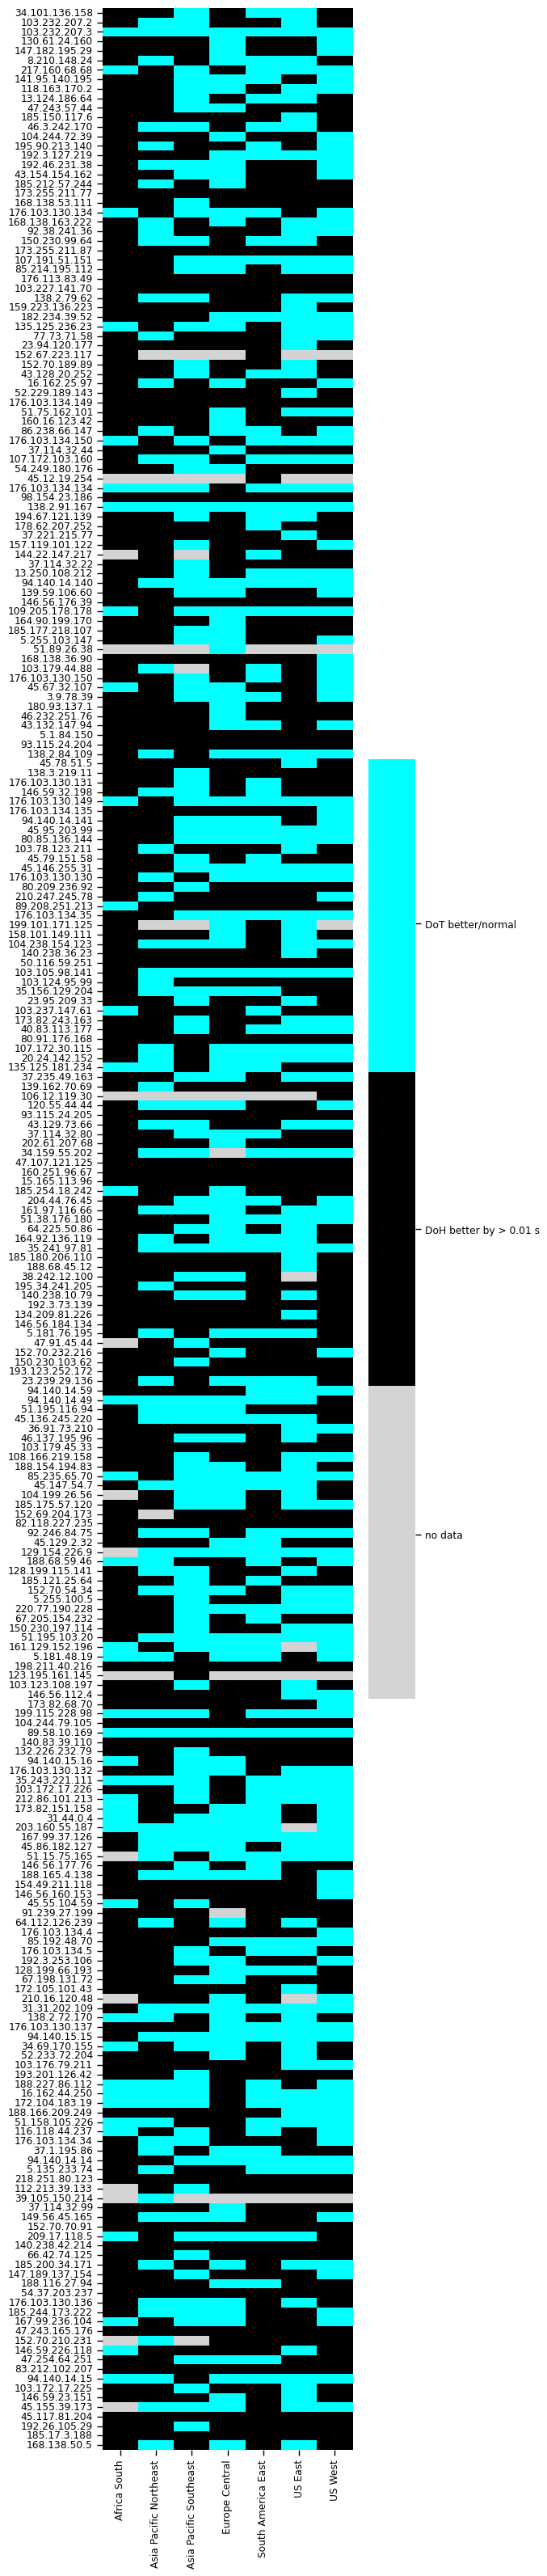

In [1180]:

df_test = pd.merge(df_query_googlevideo_all, measurements[['msm_id', 'vantagePoint', 'server']], on='msm_id').groupby(['vantagePoint','server', 'protocol']).agg(duration=('duration', 'median')).unstack().reset_index()
df_test.columns = [''.join(col).strip().replace('duration', "", 1) for col in df_test.columns.values]
median_doh_better = 0
median_dot_better = 0
doh_better_vp = dict()
dot_better_vp = dict()
for vp in df_test.vantagePoint.unique():
    doh_better_vp[vp] = set()
    dot_better_vp[vp] = set()
for idx, row in df_test.iterrows():
    #if row['DoT'] > row['DoH']:
    if row['DoT']-row['DoH'] > 0.01 :
        median_doh_better = median_doh_better+1
        doh_better_vp[row['vantagePoint']].add(row['server'])
    else:
        median_dot_better = median_dot_better+1
        dot_better_vp[row['vantagePoint']].add(row['server'])
print("all vantage points:")
print(median_doh_better)
print(median_dot_better)
print(median_dot_better+median_doh_better)
running_set_doh = set()
running_set_dot = set()
for vp in df_test.vantagePoint.unique():
    if len(running_set_doh) == 0:
        running_set_doh = doh_better_vp[vp]
    else:
        running_set_doh = running_set_doh.intersection(doh_better_vp[vp])
    if len(running_set_dot) == 0:
        running_set_dot = dot_better_vp[vp]
    else:
        running_set_dot = running_set_dot.intersection(dot_better_vp[vp])
print("intersection across vantage points:")
print(len(running_set_doh))
print(len(running_set_dot))
running_set_doh_across = set()
for server in df_test.server.unique():
    vps_doh_better = []
    for vp in df_test.vantagePoint.unique():
        dot_better_tmp = dot_better_vp[vp]
        doh_better_tmp = doh_better_vp[vp]
        if server in doh_better_tmp:
            vps_doh_better.append(vp)
    if len(vps_doh_better) == 7:
        running_set_doh_across.add(server)
print(len(running_set_doh_across))
df_heatmap_first_video = pd.DataFrame(index=df_test.vantagePoint.unique(), columns=resolvers_in_order_from_target_list)
for vp in df_test.vantagePoint.unique():
    resolvers_doh_better = doh_better_vp[vp]
    for resolver in resolvers_doh_better:
        df_heatmap_first_video.loc[vp][resolver] = 0
    resolvers_dot_better = dot_better_vp[vp]
    for resolver in resolvers_dot_better:
        df_heatmap_first_video.loc[vp][resolver] = 1
df_heatmap_first_video.dropna(axis=1, how='all', inplace=True)
df_heatmap_first_video.fillna(-1, inplace=True)
plt.figure(figsize = (5,40))
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom', ['lightgray', 'black', 'cyan'], 3)

ax = sns.heatmap(df_heatmap_.transpose(), cmap=cmap, xticklabels=True, yticklabels=True)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-.65, 0, .65])
colorbar.set_ticklabels(['no data', 'DoH better by > 0.01 s', 'DoT better/normal'])
#plt.savefig('figures/heatmap-vp-server-dot-and-doh-outlier.pdf', format='pdf', bbox_inches='tight')

DoT query
count    13204.000000
mean       209.454499
std        136.061202
min          0.604537
10%         49.444894
20%         96.348608
25%        121.474143
30%        144.305223
40%        171.517700
50%        199.061070
60%        225.755701
70%        258.492601
75%        279.803080
80%        300.113396
90%        360.302783
100%      2314.246701
max       2314.246701
Name: duration, dtype: float64
DoH lazy-init-handshake-and-query
count    13044.000000
mean       203.726205
std        191.316379
min          0.757622
10%         40.731443
20%         92.695391
25%        108.458565
30%        135.265710
40%        160.589511
50%        187.510663
60%        210.057624
70%        240.694993
75%        261.359222
80%        281.098967
90%        337.384516
100%      4124.334013
max       4124.334013
Name: duration, dtype: float64
DoQ query
count    13164.000000
mean       183.494609
std        113.424952
min          0.753320
10%         38.476211
20%         89.624347
25% 

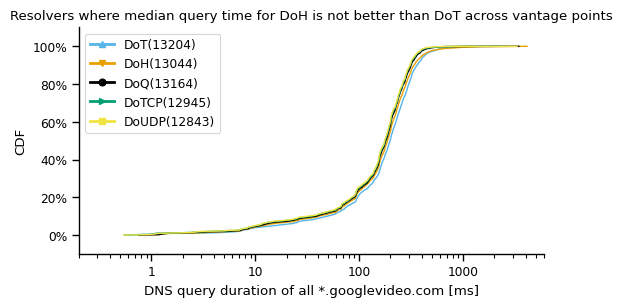

In [1138]:
df_plt = pd.merge(df_query_googlevideo_all, measurements[['msm_id', 'server']], on='msm_id')
df_plt = df_plt[~df_plt.server.isin(running_set_doh)].copy()
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_plt['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = 1
mrksize = 0
log=True
for col_val_ in legend_labels:
    for metric_type in df_plt.metric_type.unique():
        df_tmp = df_plt[(df_plt.protocol == col_val_) & (df_plt.metric_type == metric_type)]
        if len(df_tmp['duration']) == 0:
            continue
        sample_size[col_val_].append(str(len(df_tmp['duration'])))
        print(col_val_ + " " + metric_type)
        print(df_tmp['duration'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))

        dfplt = make_cdf(df_tmp['duration'])
        dfplt.plot(ax=ax, label=col_val_+" "+metric_type, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], linestyle='-', linewidth=lnwidth, logx=log)

ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('axes', -0.0))
ax.spines['left'].set_position(('axes', -0.0))
if log:
    ax.set_xscale('log')


ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
ax.tick_params(axis='x', which='minor', labelsize=6)
ax.xaxis.set_tick_params(labelbottom=True, which='both')


ax.set_title('Resolvers where median query time for DoH is not better than DoT across vantage points')

ax.set_xlabel('DNS query duration of all *.googlevideo.com [ms]')

ax.set_ylabel("CDF")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0.2,6000)



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

#if log:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter-log.pdf', format='pdf', bbox_inches='tight')
#else:
#    fig.savefig('figures/cdf-query-all-vps-all-rlsv-all-googlevideo-median-startup-delay-filter.pdf', format='pdf', bbox_inches='tight')
plt.show()

DoT
count    12187.000000
mean         0.776613
std          0.335902
min          0.238000
10%          0.410560
20%          0.502020
25%          0.550150
30%          0.591280
40%          0.661000
50%          0.722600
60%          0.791800
70%          0.867220
75%          0.913450
80%          0.972700
90%          1.183300
100%         3.353700
max          3.353700
Name: startup_delay, dtype: float64
DoH
count    12083.00000
mean         0.76528
std          0.35757
min          0.23680
10%          0.40602
20%          0.50180
25%          0.54540
30%          0.58236
40%          0.64744
50%          0.70970
60%          0.77322
70%          0.84530
75%          0.88625
80%          0.93860
90%          1.12746
100%         4.63340
max          4.63340
Name: startup_delay, dtype: float64
DoQ
count    12216.000000
mean         0.740653
std          0.310161
min          0.242500
10%          0.399000
20%          0.494100
25%          0.538200
30%          0.574800
40%      

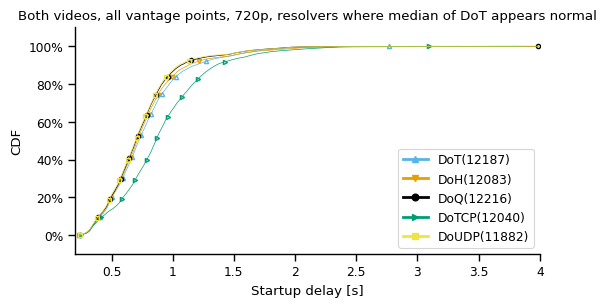

In [1141]:
fig, ax = plt.subplots(1, 1, sharex='all', sharey='all', figsize=(6,3))
line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
sample_size = dict()
legend_labels = df_start_time['protocol'].unique()
for legend_label in legend_labels:
    sample_size[legend_label] = []
lnwidth = .5
mrksize = 3
log=False
for col_val_ in legend_labels:
    sample_size[col_val_].append(str(len(df_start_time[(df_start_time['protocol'] == col_val_) & (~df_start_time.server.isin(running_set_doh))]['startup_delay'])))
    if len(df_start_time[(df_start_time['protocol'] == col_val_) & (~df_start_time.server.isin(running_set_doh))]['startup_delay']) == 0:
        continue
    cdf = Cdf.MakeCdfFromList(df_start_time[(df_start_time['protocol'] == col_val_) & (~df_start_time.server.isin(running_set_doh))]['startup_delay'])
    print(col_val_)
    print(df_start_time[(df_start_time['protocol'] == col_val_) & (~df_start_time.server.isin(running_set_doh))]['startup_delay'].describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.,.25,.75]))
    ax.plot(cdf.xs, cdf.ps, label=col_val_,
                linestyle='-', linewidth=lnwidth, 
                markersize=mrksize, fillstyle='none', 
                markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                color=colors[col_val_], marker=markers[col_val_]
            )
    #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
    #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('axes', -0.0))
    ax.spines['left'].set_position(('axes', -0.0))
    if log:
        ax.set_xscale('log')


    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
    ax.tick_params(axis='x', which='minor', labelsize=6)
    ax.xaxis.set_tick_params(labelbottom=True, which='both')


    ax.set_title('Both videos, all vantage points, 720p, resolvers where median of DoT appears normal')

    ax.set_xlabel('Startup delay [s]')

    ax.set_ylabel("CDF")
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim([0.2,4])



legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item+"("+",".join(sample_size[legend_item])+")", marker=markers[legend_item]) for legend_item in legend_labels]

plt.gca().legend(handles=legend_elements, loc='best')#loc='center', ncol=2, bbox_to_anchor=(0.5, -.5))

#if log:
#    fig.savefig('figures/cdf-startup-delay-both-videos-all-vps-dot-better-than-doh-log.pdf', format='pdf', bbox_inches='tight')
#else:
#    fig.savefig('figures/cdf-startup-delay-both-videos-all-vps-dot-better-than-doh.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [1140]:
running_set_doh

{'103.123.108.197',
 '103.124.95.99',
 '103.172.17.225',
 '103.172.17.226',
 '103.179.45.33',
 '103.227.141.70',
 '103.232.207.2',
 '104.238.154.123',
 '104.244.72.39',
 '104.244.79.105',
 '109.205.178.178',
 '116.118.44.237',
 '128.199.66.193',
 '13.124.186.64',
 '130.61.24.160',
 '134.209.81.226',
 '135.125.181.234',
 '138.3.219.11',
 '139.162.70.69',
 '140.238.10.79',
 '140.238.36.23',
 '140.238.42.214',
 '140.83.39.110',
 '146.56.112.4',
 '146.56.160.153',
 '146.56.176.39',
 '146.56.177.76',
 '146.59.226.118',
 '147.189.137.154',
 '15.165.113.96',
 '150.230.103.62',
 '150.230.197.114',
 '150.230.99.64',
 '152.70.189.89',
 '152.70.54.34',
 '152.70.70.91',
 '154.49.211.118',
 '158.101.149.111',
 '160.251.96.67',
 '161.97.116.66',
 '164.90.199.170',
 '164.92.136.119',
 '167.99.236.104',
 '168.138.36.90',
 '168.138.50.5',
 '172.105.101.43',
 '173.255.211.77',
 '173.255.211.87',
 '173.82.243.163',
 '173.82.68.70',
 '176.103.134.149',
 '178.62.207.252',
 '185.121.25.64',
 '185.150.117.6'

In [1143]:
measurements[measurements.server.isin(running_set_doh)].server.nunique()

118

In [1144]:
measurements[~measurements.server.isin(running_set_doh)].server.nunique()

139

In [1146]:
df_asn_dot_better.index.nunique()

93

In [1147]:
df_asn_doh_better.index.nunique()

164

In [1167]:

df_asn_resolvers = pd.concat([df_asn_dot_better, df_asn_doh_better]).reset_index()

In [1168]:
df_asn_resolvers.index.nunique()

257

In [1169]:
df_asn_resolvers.rename(columns=lambda x: x.replace('index', 'server'), inplace=True)

In [1170]:
df_asn_resolvers[df_asn_resolvers.server.isin(running_set_doh)].asn.value_counts()

[(31898, 'ORACLE-BMC-31898')]                                                     20
[(14061, 'DIGITALOCEAN-ASN')]                                                      9
[(63949, 'LINODE-AP Linode')]                                                      7
[(16509, 'AMAZON-02')]                                                             5
[(197540, 'NETCUP-AS - netcup GmbH')]                                              5
[(49581, 'FERDINANDZINK - Ferdinand Zink trading as Tube-Hosting')]                4
[(16276, 'OVH - OVH SAS')]                                                         4
[(25820, 'IT7NET')]                                                                3
[(36352, 'AS-COLOCROSSING')]                                                       3
[(16125, 'CHERRYSERVERS1-AS - UAB Cherry Servers')]                                3
[(45102, 'ALIBABA-CN-NET Alibaba US Technology Co.')]                              3
[(35916, 'MULTA-ASN1')]                                          

In [1171]:
df_asn_resolvers[~df_asn_resolvers.server.isin(running_set_doh)].asn.value_counts()

[(199274, 'MNGTNET - Serveroid, LLC')]                                            16
[(31898, 'ORACLE-BMC-31898')]                                                     15
[(16276, 'OVH - OVH SAS')]                                                        11
[(212772, 'ADGUARD - AdGuard Software Limited')]                                   8
[(14061, 'DIGITALOCEAN-ASN')]                                                      6
[(36352, 'AS-COLOCROSSING')]                                                       4
[(16509, 'AMAZON-02')]                                                             4
[(132203, 'TENCENT-NET-AP-CN Tencent Building')]                                   4
[(396982, 'GOOGLE-CLOUD-PLATFORM')]                                                3
[(197540, 'NETCUP-AS - netcup GmbH')]                                              2
[(197695, 'AS-REGRU - "Domain names registrar REG.RU", Ltd')]                      2
[(15169, 'GOOGLE')]                                              

In [1173]:
for idx_rslv in range(len(resolvers_in_order_from_target_list)):
    rslv = resolvers_in_order_from_target_list[idx_rslv]
    if rslv in running_set_doh:
        print(str(idx_rslv)+', '+rslv)

0, 34.101.136.158
2, 103.232.207.2
5, 130.61.24.160
7, 8.210.148.24
11, 13.124.186.64
14, 185.150.117.6
16, 104.244.72.39
19, 192.3.127.219
23, 185.212.57.244
24, 173.255.211.77
29, 92.38.241.36
30, 150.230.99.64
33, 173.255.211.87
38, 103.227.141.70
50, 152.70.189.89
53, 52.229.189.143
54, 176.103.134.149
64, 37.114.32.44
66, 54.249.180.176
70, 98.154.23.186
75, 178.62.207.252
76, 37.221.215.77
81, 37.114.32.22
88, 146.56.176.39
89, 109.205.178.178
90, 164.90.199.170
92, 5.255.103.147
95, 168.138.36.90
100, 3.9.78.39
103, 46.232.251.76
105, 5.1.84.150
106, 93.115.24.204
108, 45.78.51.5
110, 138.3.219.11
121, 45.79.151.58
123, 45.146.255.31
125, 80.209.236.92
127, 89.208.251.213
130, 158.101.149.111
131, 104.238.154.123
132, 140.238.36.23
133, 50.116.59.251
135, 103.124.95.99
137, 23.95.209.33
139, 173.82.243.163
141, 80.91.176.168
144, 135.125.181.234
146, 139.162.70.69
149, 93.115.24.205
151, 37.114.32.80
152, 202.61.207.68
154, 47.107.121.125
155, 160.251.96.67
156, 15.165.113.96
16

In [1174]:
df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoQ')].groupby('msm_id').size().value_counts(normalize=True)

1    1.0
dtype: float64

In [1175]:
df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')].groupby('msm_id').size().value_counts(normalize=True)

3    0.767615
4    0.097546
2    0.096101
5    0.021601
1    0.016286
6    0.000468
7    0.000340
8    0.000043
dtype: float64

In [1176]:
df_dns_perf_metrics[(df_dns_perf_metrics.metric_type == 'handshake') & (df_dns_perf_metrics.protocol == 'DoT')]

msm_id  \
15       17915357-f2e4-81b4-acf7-b71255703ed8   
22       17915357-f2e4-81b4-acf7-b71255703ed8   
23       17915357-f2e4-81b4-acf7-b71255703ed8   
215      56791d63-e17d-3cab-230c-54fe853c1f61   
222      56791d63-e17d-3cab-230c-54fe853c1f61   
223      56791d63-e17d-3cab-230c-54fe853c1f61   
415      c7b739f5-eb61-8ade-2446-0c01e5ec5bc9   
422      c7b739f5-eb61-8ade-2446-0c01e5ec5bc9   
423      c7b739f5-eb61-8ade-2446-0c01e5ec5bc9   
615      0b5e43c3-1cfa-7ea9-8126-510d9e6f79a1   
622      0b5e43c3-1cfa-7ea9-8126-510d9e6f79a1   
623      0b5e43c3-1cfa-7ea9-8126-510d9e6f79a1   
815      27062d86-4d3a-00ba-6ae0-adfb10b9c426   
822      27062d86-4d3a-00ba-6ae0-adfb10b9c426   
823      27062d86-4d3a-00ba-6ae0-adfb10b9c426   
1013     6438a808-934e-3f88-2b77-841bb62c50b4   
1020     6438a808-934e-3f88-2b77-841bb62c50b4   
1021     6438a808-934e-3f88-2b77-841bb62c50b4   
1250     f05aa738-7204-05bf-ab7b-8ea1e0559a81   
1257     f05aa738-7204-05bf-ab7b-8ea1e0559a81   
1258     f05aa738-7204-05bf-ab7b-8ea1e0559a81   
1259     f05aa738-7204-05bf-ab7b-8ea1e0559a81   
1452     b614b9f6-e1bf-9c12-0660-13d597589a59   
1459     b614b9f6-e1bf-9c12-0660-13d597589a59   
1460     b614b9f6-e1bf-9c12-0660-13d597589a59   
...                                       ...   
4936961  c00da17c-16e5-7ca2-e34d-b13972b930b5   
4937155  3b5774df-fe1a-e5d0-7113-9a43d75b267f   
4937162  3b5774df-fe1a-e5d0-7113-9a43d75b267f   
4937165  3b5774df-fe1a-e5d0-7113-9a43d75b267f   
4937355  22f0ff7f-bfb7-5e31-07ad-05c59219f24c   
4937362  22f0ff7f-bfb7-5e31-07ad-05c59219f24c   
4937363  22f0ff7f-bfb7-5e31-07ad-05c59219f24c   
4937557  70c4c509-372e-a643-6553-b8fe9d89e65f   
4937564  70c4c509-372e-a643-6553-b8fe9d89e65f   
4937565  70c4c509-372e-a643-6553-b8fe9d89e65f   
4937757  4964cafe-2ed0-2156-5910-badadc5a45b4   
4937764  4964cafe-2ed0-2156-5910-badadc5a45b4   
4937765  4964cafe-2ed0-2156-5910-badadc5a45b4   
4937959  facdfa87-28bb-d614-e532-97401814e57b   
4937966  facdfa87-28bb-d614-e532-97401814e57b   
4937969  facdfa87-28bb-d614-e532-97401814e57b   
4938163  e6b4bb66-e925-5df6-d6ce-2fb39fa5c257   
4938170  e6b4bb66-e925-5df6-d6ce-2fb39fa5c257   
4938171  e6b4bb66-e925-5df6-d6ce-2fb39fa5c257   
4938373  ba86c998-a5ca-868a-0719-1bfb50c24c8a   
4938380  ba86c998-a5ca-868a-0719-1bfb50c24c8a   
4938381  ba86c998-a5ca-868a-0719-1bfb50c24c8a   
4938573  08a2d00a-8951-9748-8dc7-ee34bdbf8923   
4938580  08a2d00a-8951-9748-8dc7-ee34bdbf8923   
4938581  08a2d00a-8951-9748-8dc7-ee34bdbf8923   

                                                    metric metric_type  \
15       DoT TLS handshake duration from Apr 18 00:00:1...   handshake   
22       DoT TLS handshake duration from Apr 18 00:00:2...   handshake   
23       DoT TLS handshake duration from Apr 18 00:00:2...   handshake   
215      DoT TLS handshake duration from Apr 18 00:02:4...   handshake   
222      DoT TLS handshake duration from Apr 18 00:02:5...   handshake   
223      DoT TLS handshake duration from Apr 18 00:02:5...   handshake   
415      DoT TLS handshake duration from Apr 18 00:05:2...   handshake   
422      DoT TLS handshake duration from Apr 18 00:05:2...   handshake   
423      DoT TLS handshake duration from Apr 18 00:05:2...   handshake   
615      DoT TLS handshake duration from Apr 18 00:07:3...   handshake   
622      DoT TLS handshake duration from Apr 18 00:07:3...   handshake   
623      DoT TLS handshake duration from Apr 18 00:07:3...   handshake   
815      DoT TLS handshake duration from Apr 18 00:09:4...   handshake   
822      DoT TLS handshake duration from Apr 18 00:09:4...   handshake   
823      DoT TLS handshake duration from Apr 18 00:09:4...   handshake   
1013     DoT TLS handshake duration from Apr 18 00:11:5...   handshake   
1020     DoT TLS handshake duration from Apr 18 00:12:0...   handshake   
1021     DoT TLS handshake duration from Apr 18 00:12:0...   handshake   
1250     DoT TLS handshake duration from Apr 18 00:18:2...   handshake   
1257     D